In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'
import koreanize_matplotlib
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
votes_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")

In [3]:
top_bottom_df = pd.read_csv("/home/sprintda05/final/master_table_v6.csv")

In [4]:
friend_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_friendrequest.parquet")

# Ï≤´ Ìà¨Ìëú Ï†Ñ ÏπúÍµ¨ Ïàò

In [6]:
# 1. ÏπúÍµ¨ ÏöîÏ≤≠ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò® ÏÉÅÌÉú: friend_df
#    ‚Üí ÏàòÎùΩÎêú(friend accepted) ÏπúÍµ¨ Í¥ÄÍ≥ÑÎßå ÌïÑÌÑ∞
accepted_df = friend_df[friend_df["status"] == "A"].copy()

# 2. ÏπúÍµ¨ ÏàòÎùΩ ÏãúÏ†ê Ïª¨Îüº ÏÇ¨Ïö© (updated_at)
accepted_df["updated_at"] = pd.to_datetime(accepted_df["updated_at"])

# 3. Î≥¥ÎÇ∏ ÏÇ¨Îûå Í∏∞Ï§Ä
sent_df = accepted_df[["send_user_id", "updated_at"]].rename(
    columns={"send_user_id": "user_id", "updated_at": "friend_accepted_at"}
)

# 4. Î∞õÏùÄ ÏÇ¨Îûå Í∏∞Ï§Ä
recv_df = accepted_df[["receive_user_id", "updated_at"]].rename(
    columns={"receive_user_id": "user_id", "updated_at": "friend_accepted_at"}
)

# 5. Î≥¥ÎÇ∏ Ï™Ω + Î∞õÏùÄ Ï™Ω Î™®Îëê Ìï©ÏπòÍ∏∞ ‚Üí Ìïú Ïú†Ï†Ä Í∏∞Ï§ÄÏúºÎ°ú Ï†ÑÏ≤¥ ÏàòÎùΩ Î°úÍ∑∏ ÎßåÎì§Í∏∞
friend_accept_df = pd.concat([sent_df, recv_df], axis=0)

# 6. first_vote_dateÎ≥¥Îã§ ÏπúÍµ¨ ÏàòÎùΩ ÏãúÏ†êÏù¥ Îπ†Î•∏ Í≤ΩÏö∞Îßå ÌïÑÌÑ∞
merged = friend_accept_df.merge(
    top_bottom_df[["user_id", "first_vote_date"]],
    on="user_id",
    how="left"
)

# 7. Ï≤´ Ìà¨Ìëú Ï†ÑÏóê ÏàòÎùΩÎêú ÏπúÍµ¨Îßå ÌïÑÌÑ∞
friend_before_vote_df = merged[merged["friend_accepted_at"] < merged["first_vote_date"]]

# 8. Ïú†Ï†ÄÎ≥Ñ ÏπúÍµ¨ Ïàò ÏßëÍ≥Ñ
friend_count_before_vote_df = (
    friend_before_vote_df.groupby("user_id")
    .size()
    .reset_index(name="friend_count_before_vote")
)

# 9. ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú ÎßàÏä§ÌÑ∞ ÌÖåÏù¥Î∏îÏóê Î≥ëÌï©
top_bottom_df = top_bottom_df.merge(
    friend_count_before_vote_df,
    on="user_id",
    how="left"
)

# 10. Í≤∞Ï∏°ÏπòÎäî 0ÏúºÎ°ú ÎåÄÏ≤¥ (ÏπúÍµ¨Í∞Ä ÏïÑÏòà ÏóÜÏóàÎçò Ïú†Ï†Ä)
top_bottom_df["friend_count_before_vote"] = top_bottom_df["friend_count_before_vote"].fillna(0).astype(int)


In [7]:
top_bottom_df.groupby("retention_group")["friend_count_before_vote"].mean()

retention_group
bottom25    3.102894
top25       3.475851
Name: friend_count_before_vote, dtype: float64

In [9]:
from scipy.stats import ttest_ind

# Í∑∏Î£π Î∂ÑÎ¶¨
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["friend_count_before_vote"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["friend_count_before_vote"]

# Îì±Î∂ÑÏÇ∞ Í∞ÄÏ†ï ÏóÜÏù¥ t-test
t_stat, p_val = ttest_ind(top, bottom, equal_var=False)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.4f}")


t-statistic: 1.582
p-value: 0.1139


# Ï≤´ Ìà¨Ìëú Ï†Ñ ÏπúÍµ¨ Ïó¨Î∂Ä

In [41]:
top_bottom_df["has_friend_before_first_vote"] = (
    (top_bottom_df["sign_up_date"] <= top_bottom_df["first_vote_date"]) &
    (top_bottom_df["period_friend_count"] > 0)
).astype(int)

In [42]:
top_bottom_df["has_friend_before_first_vote"] 

0       1
1       1
2       1
3       1
4       1
       ..
2502    1
2503    1
2504    1
2505    1
2506    1
Name: has_friend_before_first_vote, Length: 2507, dtype: int64

In [43]:
# ÍµêÏ∞®Ìëú ÎßåÎì§Í∏∞
table = pd.crosstab(top_bottom_df["retention_group"], top_bottom_df["has_friend_before_first_vote"])

# ÏÉÅÌïòÏúÑ Í∑∏Î£πÏùò '1'Ïù∏ Í∞í (Ï¶â, ÏπúÍµ¨Í∞Ä ÏûàÏóàÎçò Ïú†Ï†Ä Ïàò)
count = table.loc[["top25", "bottom25"], 1].values

# Í∞Å Í∑∏Î£πÏùò Ï†ÑÏ≤¥ Ïù∏Ïõê Ïàò
nobs = table.loc[["top25", "bottom25"]].sum(axis=1).values

# z-test Ïã§Ìñâ
zstat, pval = proportions_ztest(count, nobs)

print(f"Z-statistic: {zstat:.3f}")
print(f"P-value: {pval:.4f}")

Z-statistic: 0.399
P-value: 0.6902


# Ïú†Ï†ÄÍ∞Ä Í∞ÄÏûÖ ÌõÑ 1Ïùº/2Ïùº/3Ïùº Ïù¥ÎÇ¥Ïóê ÌôïÎ≥¥Ìïú ÏπúÍµ¨ Ïàò

In [10]:
# 1. ÏπúÍµ¨ ÏöîÏ≤≠ ÌÖåÏù¥Î∏îÏóêÏÑú ÏàòÎùΩÎêú ÏöîÏ≤≠Îßå ÌïÑÌÑ∞
accepted_df = friend_df[friend_df["status"] == "A"].copy()
accepted_df["updated_at"] = pd.to_datetime(accepted_df["updated_at"])
accepted_df = accepted_df[
    (accepted_df["updated_at"] >= "2023-04-28") &
    (accepted_df["updated_at"] < "2023-08-01")
].copy()


In [11]:
accepted_df["updated_at"].max()

Timestamp('2023-07-31 23:55:02')

In [12]:
# 2. Î≥¥ÎÇ∏ ÏÇ¨ÎûåÍ≥º Î∞õÏùÄ ÏÇ¨Îûå Î™®Îëê ÏπúÍµ¨ Í¥ÄÍ≥ÑÎ°ú Ï∑®Í∏â
sent_df = accepted_df[["send_user_id", "updated_at"]].rename(
    columns={"send_user_id": "user_id", "updated_at": "friend_accepted_at"}
)
recv_df = accepted_df[["receive_user_id", "updated_at"]].rename(
    columns={"receive_user_id": "user_id", "updated_at": "friend_accepted_at"}
)

In [13]:
# 3. Îëê Î∞©Ìñ• Í≤∞Ìï©
friend_accept_df = pd.concat([sent_df, recv_df], axis=0)

In [14]:
# 4. ÎßàÏä§ÌÑ∞ ÌÖåÏù¥Î∏îÏóêÏÑú Ïú†Ï†ÄÎ≥Ñ Í∞ÄÏûÖÏùº Í∞ÄÏ†∏Ïò§Í∏∞
user_signup_df = top_bottom_df[["user_id", "sign_up_date"]].copy()

In [15]:
# 5. Í∞ÄÏûÖÏùº Î≥ëÌï© ‚Üí ÏπúÍµ¨ ÏàòÎùΩ ÏãúÏ†êÍ≥º Í∞ÄÏûÖÏùº Ï∞®Ïù¥ Í≥ÑÏÇ∞
friend_accept_df = friend_accept_df.merge(user_signup_df, on="user_id", how="left")
friend_accept_df["sign_up_date"] = pd.to_datetime(friend_accept_df["sign_up_date"])
friend_accept_df["days_since_signup"] = (
    (friend_accept_df["friend_accepted_at"] - friend_accept_df["sign_up_date"]).dt.days
)

In [16]:
# 6. Í∞Å Ïú†Ï†ÄÍ∞Ä Í∞ÄÏûÖ ÌõÑ NÏùº Ïù¥ÎÇ¥ ÏπúÍµ¨ Ï∂îÍ∞ÄÌïú Ïàò Í≥ÑÏÇ∞
growth_day1 = friend_accept_df[friend_accept_df["days_since_signup"] <= 1].groupby("user_id").size().reset_index(name="friend_growth_day1")
growth_day2 = friend_accept_df[friend_accept_df["days_since_signup"] <= 2].groupby("user_id").size().reset_index(name="friend_growth_day2")
growth_day3 = friend_accept_df[friend_accept_df["days_since_signup"] <= 3].groupby("user_id").size().reset_index(name="friend_growth_day3")
growth_day4 = friend_accept_df[friend_accept_df["days_since_signup"] <= 4].groupby("user_id").size().reset_index(name="friend_growth_day4")
growth_day5 = friend_accept_df[friend_accept_df["days_since_signup"] <= 5].groupby("user_id").size().reset_index(name="friend_growth_day5")
growth_day6 = friend_accept_df[friend_accept_df["days_since_signup"] <= 6].groupby("user_id").size().reset_index(name="friend_growth_day6")
growth_day7 = friend_accept_df[friend_accept_df["days_since_signup"] <= 7].groupby("user_id").size().reset_index(name="friend_growth_day7")
growth_day8 = friend_accept_df[friend_accept_df["days_since_signup"] <= 8].groupby("user_id").size().reset_index(name="friend_growth_day8")
growth_day9 = friend_accept_df[friend_accept_df["days_since_signup"] <= 9].groupby("user_id").size().reset_index(name="friend_growth_day9")

In [17]:
# 7. ÎßàÏä§ÌÑ∞ ÌÖåÏù¥Î∏îÏóê Î≥ëÌï©
top_bottom_df = top_bottom_df.merge(growth_day1, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day2, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day3, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day4, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day5, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day6, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day7, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day8, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day9, on="user_id", how="left")



In [18]:
# 8. Í≤∞Ï∏°Ïπò ‚Üí ÏπúÍµ¨ Ïàò 0Î™ÖÏúºÎ°ú Ï≤òÎ¶¨
for col in ["friend_growth_day1", "friend_growth_day2", "friend_growth_day3","friend_growth_day4","friend_growth_day5","friend_growth_day6","friend_growth_day7","friend_growth_day8","friend_growth_day9"]:
    top_bottom_df[col] = top_bottom_df[col].fillna(0).astype(int)

In [19]:
top_bottom_df

Unnamed: 0  user_id  total_votes  unique_days  first_vote   last_vote  \
0              0   838466          129            7  2023-05-02  2023-06-02   
1              1   838642           10            2  2023-04-28  2023-04-29   
2              2   840512          141            8  2023-05-02  2023-07-11   
3              3   840685          567           21  2023-05-02  2023-06-06   
4              4   840902          250           14  2023-05-02  2023-05-27   
...          ...      ...          ...          ...         ...         ...   
2502        2502  1497413          335           13  2023-05-24  2023-07-28   
2503        2503  1497699           15            2  2023-05-24  2023-05-25   
2504        2504  1498168          268           15  2023-05-24  2023-06-09   
2505        2505  1498266            4            1  2023-05-24  2023-05-24   
2506        2506  1499419           37            2  2023-05-24  2023-05-25   

      active_days  cohort_day  retention_day8 gender  ...  \
0              31  2023-05-02        0.569444      F  ...   
1               1  2023-04-28        0.560000      F  ...   
2              70  2023-05-02        0.569444      M  ...   
3              35  2023-05-02        0.569444      F  ...   
4              25  2023-05-02        0.569444      F  ...   
...           ...         ...             ...    ...  ...   
2502           65  2023-05-24        0.294118      M  ...   
2503            1  2023-05-24        0.294118      M  ...   
2504           16  2023-05-24        0.294118      M  ...   
2505            0  2023-05-24        0.294118      F  ...   
2506            1  2023-05-24        0.294118      M  ...   

      friend_count_before_vote  friend_growth_day1  friend_growth_day2  \
0                           14                   0                   0   
1                            0                   0                   0   
2                            0                   0                   0   
3                            9                   0                   0   
4                            4                   0                   0   
...                        ...                 ...                 ...   
2502                         0                  27                  30   
2503                         0                   0                   1   
2504                         0                  11                  14   
2505                         0                  20                  24   
2506                         0                  24                  25   

      friend_growth_day3  friend_growth_day4 friend_growth_day5  \
0                      0                   0                  0   
1                      0                   0                  0   
2                      0                   0                  0   
3                      0                   0                  0   
4                      0                   0                  0   
...                  ...                 ...                ...   
2502                  32                  32                 35   
2503                   2                   2                  2   
2504                  18                  20                 20   
2505                  25                  28                 28   
2506                  25                  25                 25   

     friend_growth_day6  friend_growth_day7 friend_growth_day8  \
0                     0                   0                  0   
1                     0                   0                  1   
2                     0                   0                  0   
3                     0                   0                  0   
4                     0                   0                  0   
...                 ...                 ...                ...   
2502                 35                  35                 35   
2503                  2                   2                  2   
2504                 21             

In [20]:
top_bottom_df.groupby("retention_group")[["friend_growth_day1", "friend_growth_day2", "friend_growth_day3","friend_growth_day4","friend_growth_day5","friend_growth_day6","friend_growth_day7","friend_growth_day8","friend_growth_day9"]].mean()


friend_growth_day1  friend_growth_day2  friend_growth_day3  \
retention_group                                                               
bottom25                  30.364952           34.151125           36.200965   
top25                     25.307205           30.121932           34.301663   

                 friend_growth_day4  friend_growth_day5  friend_growth_day6  \
retention_group                                                               
bottom25                  37.587621           38.567524           39.127010   
top25                     37.207443           39.295329           41.149644   

                 friend_growth_day7  friend_growth_day8  friend_growth_day9  
retention_group                                                              
bottom25                  39.460611           39.713023           39.919614  
top25                     42.608076           43.463183           44.197941

In [68]:
retention_by_day = []

for day in range(1, 10):
    col = f"friend_growth_day{day}"
    top = top_bottom_df[top_bottom_df["retention_group"] == "top25"][col].mean()
    bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"][col].mean()
    diff = top - bottom
    retention_by_day.append((day, round(bottom, 4), round(top, 4), round(diff, 4)))

retention_df = pd.DataFrame(retention_by_day, columns=["Day", "Bottom25 Retention", "Top25 Retention", "Diff"])
display(retention_df)


Day  Bottom25 Retention  Top25 Retention    Diff
0    1             30.3650          25.3072 -5.0577
1    2             34.1511          30.1219 -4.0292
2    3             36.2010          34.3017 -1.8993
3    4             37.5876          37.2074 -0.3802
4    5             38.5675          39.2953  0.7278
5    6             39.1270          41.1496  2.0226
6    7             39.4606          42.6081  3.1475
7    8             39.7130          43.4632  3.7502
8    9             39.9196          44.1979  4.2783

In [69]:
from scipy.stats import ttest_ind
import pandas as pd

# Í≤∞Í≥º Ï†ÄÏû• Î¶¨Ïä§Ìä∏
results = []

# 1~9ÏùºÏ∞® Î£®ÌîÑ
for day in range(1, 10):
    col = f"friend_growth_day{day}"
    top_values = top_bottom_df[top_bottom_df["retention_group"] == "top25"][col]
    bottom_values = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"][col]
    
    t_stat, p_val = ttest_ind(top_values, bottom_values, equal_var=False)
    
    results.append({
        "ÏùºÏ∞®": f"{day}ÏùºÏ∞®",
        "top25 ÌèâÍ∑†": round(top_values.mean(), 2),
        "bottom25 ÌèâÍ∑†": round(bottom_values.mean(), 2),
        "t-statistic": round(t_stat, 2),
        "p-value": "< 0.001" if p_val < 0.001 else round(p_val, 3),
        "Ïú†ÏùòÏÑ±": "‚úÖ Ïú†Ïùò" if p_val < 0.05 else "‚ùå ÏóÜÏùå"
    })

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôò
ttest_df = pd.DataFrame(results)


In [70]:
ttest_df 

ÏùºÏ∞®  top25 ÌèâÍ∑†  bottom25 ÌèâÍ∑†  t-statistic  p-value   Ïú†ÏùòÏÑ±
0  1ÏùºÏ∞®     25.31        30.36        -6.28  < 0.001  ‚úÖ Ïú†Ïùò
1  2ÏùºÏ∞®     30.12        34.15        -4.63  < 0.001  ‚úÖ Ïú†Ïùò
2  3ÏùºÏ∞®     34.30        36.20        -2.06    0.039  ‚úÖ Ïú†Ïùò
3  4ÏùºÏ∞®     37.21        37.59        -0.39    0.693  ‚ùå ÏóÜÏùå
4  5ÏùºÏ∞®     39.30        38.57         0.73    0.466  ‚ùå ÏóÜÏùå
5  6ÏùºÏ∞®     41.15        39.13         2.00    0.046  ‚úÖ Ïú†Ïùò
6  7ÏùºÏ∞®     42.61        39.46         3.08    0.002  ‚úÖ Ïú†Ïùò
7  8ÏùºÏ∞®     43.46        39.71         3.65  < 0.001  ‚úÖ Ïú†Ïùò
8  9ÏùºÏ∞®     44.20        39.92         4.14  < 0.001  ‚úÖ Ïú†Ïùò

In [49]:
from scipy.stats import ttest_ind

top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["friend_growth_day1"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["friend_growth_day1"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")


t = -6.283, p = 0.0000


In [23]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["friend_growth_day2"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["friend_growth_day2"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")

t = -4.633, p = 0.0000


In [51]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["friend_growth_day3"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["friend_growth_day3"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")

t = -2.061, p = 0.0394


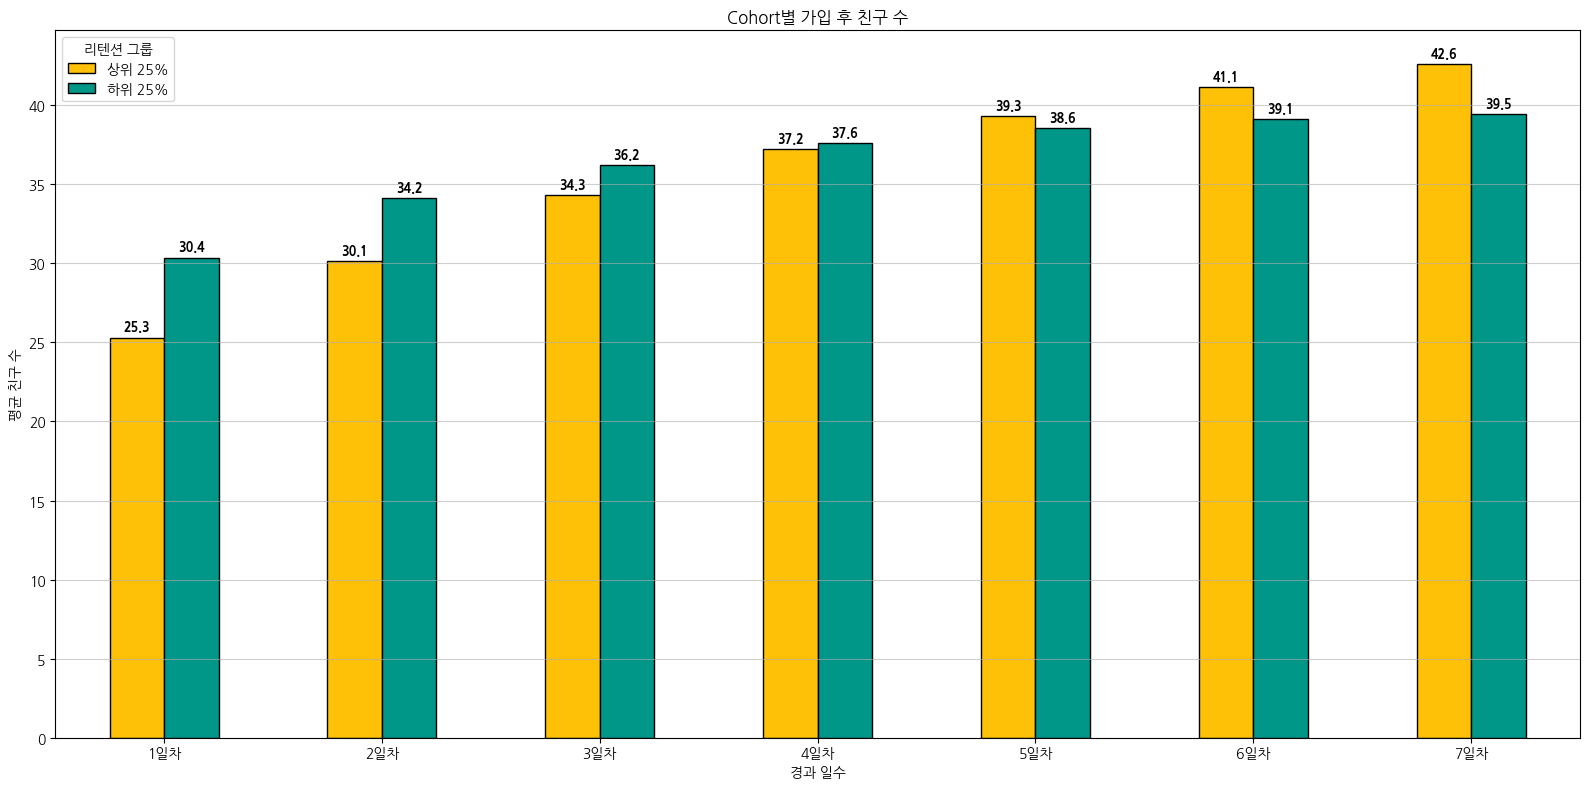

In [111]:
import matplotlib.pyplot as plt

# retention_group Í∞íÏùÑ ÌïúÍ∏ÄÎ°ú Îß§Ìïë
top_bottom_df["retention_group_kor"] = top_bottom_df["retention_group"].replace({
    "bottom25": "ÌïòÏúÑ 25%",
    "top25": "ÏÉÅÏúÑ 25%"
})

# 1. Ïª¨ÎüºÎ™ÖÍ≥º ÎåÄÏùëÎêòÎäî ÌïúÍ∏Ä Î†àÏù¥Î∏î ÏßÄÏ†ï
day_labels = ['1ÏùºÏ∞®', '2ÏùºÏ∞®', '3ÏùºÏ∞®', '4ÏùºÏ∞®', '5ÏùºÏ∞®', '6ÏùºÏ∞®', '7ÏùºÏ∞®',]
columns = ["friend_growth_day1", "friend_growth_day2", "friend_growth_day3",
           "friend_growth_day4", "friend_growth_day5", "friend_growth_day6",
           "friend_growth_day7"]

# 2. Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏπúÍµ¨ Ïàò Í≥ÑÏÇ∞ (ÌïúÍ∏Ä Ïª¨Îüº ÏÇ¨Ïö©)
growth_summary = top_bottom_df.groupby("retention_group_kor")[columns].mean().T
growth_summary.index = day_labels  # xÏ∂ï ÌïúÍ∏ÄÎ°ú ÏÑ§Ï†ï

# 3. ÏãúÍ∞ÅÌôî
ax = growth_summary.plot(kind="bar", figsize=(16, 8), color=["#ffc107", "#009688"], edgecolor="black")

# 4. Î∞î ÏúÑÏóê ÏàòÏπò ÌëúÏãú
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3, fontweight='bold',fontsize=9)

# 5. Í∏∞ÌÉÄ ÏÑ§Ï†ï
plt.title("CohortÎ≥Ñ Í∞ÄÏûÖ ÌõÑ ÏπúÍµ¨ Ïàò")
plt.ylabel("ÌèâÍ∑† ÏπúÍµ¨ Ïàò")
plt.xlabel("Í≤ΩÍ≥º ÏùºÏàò")
plt.xticks(rotation=0)
plt.legend(title="Î¶¨ÌÖêÏÖò Í∑∏Î£π")
plt.grid(axis="y", linestyle="-", alpha=0.6)
plt.tight_layout()
plt.show()


In [35]:
top_bottom_df[['days_to_vote','user_id']]

days_to_vote  user_id
0               13   838466
1                8   838642
2               11   840512
3               11   840685
4               10   840902
...            ...      ...
2502             0  1497413
2503             0  1497699
2504             0  1498168
2505             0  1498266
2506             0  1499419

[2507 rows x 2 columns]

# 3ÏùºÏù¥ÎÇ¥ Ìà¨Ìëú Ïàò 

In [36]:
# 3ÏùºÏù¥ÎÇ¥ Ìà¨Ìëú Ïàò ÌèâÍ∑†
print("\nÎ¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ 3ÏùºÏù¥ÎÇ¥ Ìà¨Ìëú ÌöüÏàò ÌèâÍ∑†Í∞í")
print(top_bottom_df.groupby("retention_group")["votes_within_3d"].mean())


Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ 3ÏùºÏù¥ÎÇ¥ Ìà¨Ìëú ÌöüÏàò ÌèâÍ∑†Í∞í
retention_group
bottom25    106.104502
top25       110.818686
Name: votes_within_3d, dtype: float64


In [41]:
top_3d = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["votes_within_3d"]
bottom_3d = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["votes_within_3d"]

t_stat, p_val = ttest_ind(top_3d, bottom_3d, equal_var=False)  # Welch‚Äôs t-test Í∂åÏû•

print("t-statistic:", round(t_stat, 4))
print("p-value:", round(p_val, 4))

t-statistic: 1.4829
p-value: 0.1382


# Ìà¨Ìëú ÎåÄÏÉÅ Ïàò 

In [42]:
# Ìà¨Ìëú ÎåÄÏÉÅ Ïàò ÌèâÍ∑†
print("\nÎ¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† Ìà¨Ìëú ÎåÄÏÉÅ Ïàò")
print(top_bottom_df.groupby("retention_group")["chosen_user_count"].mean())


Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† Ìà¨Ìëú ÎåÄÏÉÅ Ïàò
retention_group
bottom25    34.342444
top25       40.473476
Name: chosen_user_count, dtype: float64


In [35]:
top_vns = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["chosen_user_count"]
bottom_vns = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["chosen_user_count"]

t_stat, p_val = ttest_ind(top_vns, bottom_vns, equal_var=False)  # Welch‚Äôs t-test Í∂åÏû•

print("t-statistic:", round(t_stat, 4))
print("p-value:", round(p_val, 4))

t-statistic: 7.5522
p-value: 0.0


In [44]:
top_bottom_df["voted_over_10"] = (top_bottom_df["chosen_user_count"] >= 10).astype(int)


# ÏπúÍµ¨ Ïàò 

In [71]:
print("\nÎ¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏπúÍµ¨ Ïàò")
print(top_bottom_df.groupby("retention_group")["period_friend_count"].mean())


Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏπúÍµ¨ Ïàò
retention_group
bottom25    41.774116
top25       48.811560
Name: period_friend_count, dtype: float64


In [36]:
# ÏπúÍµ¨ Ïàò
top_friends = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["period_friend_count"]
bottom_friends = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["period_friend_count"]

t_stat2, p_val2 = ttest_ind(top_friends, bottom_friends, equal_var=False)

print("t-statistic:", round(t_stat2, 4))
print ("p-value:", round(p_val2, 4))

t-statistic: 6.5227
p-value: 0.0


In [74]:
from scipy.stats import shapiro

# Í∞Å Í∑∏Î£π Ï†ïÍ∑úÏÑ± Í≤ÄÏ†ï
shapiro_top = shapiro(top_friends)
shapiro_bottom = shapiro(bottom_friends)

print("Top25 Ï†ïÍ∑úÏÑ± p-value:", round(shapiro_top.pvalue, 4))
print("Bottom25 Ï†ïÍ∑úÏÑ± p-value:", round(shapiro_bottom.pvalue, 4))

Top25 Ï†ïÍ∑úÏÑ± p-value: 0.0
Bottom25 Ï†ïÍ∑úÏÑ± p-value: 0.0


In [75]:
from scipy.stats import mannwhitneyu

u_stat, mw_p = mannwhitneyu(top_friends, bottom_friends, alternative='two-sided')
print("Mann-Whitney U test p-value:", round(mw_p, 4))

Mann-Whitney U test p-value: 0.0


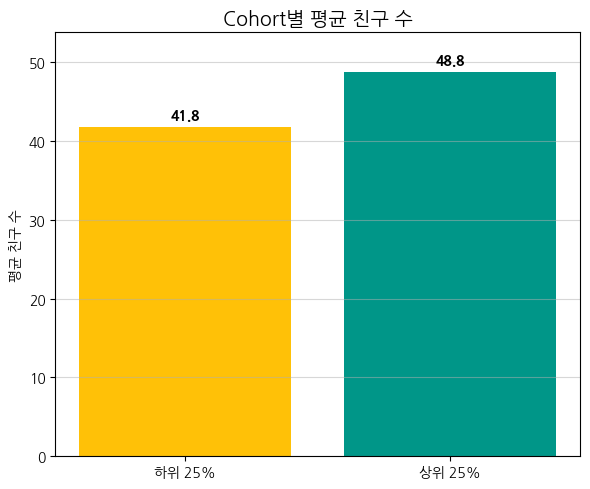

In [110]:
import matplotlib.pyplot as plt

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
avg_friends = top_bottom_df.groupby("retention_group")["period_friend_count"].mean()
avg_friends = avg_friends.rename(index={"bottom25": "ÌïòÏúÑ 25%", "top25": "ÏÉÅÏúÑ 25%"})

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 5))
bars = plt.bar(avg_friends.index, avg_friends.values, color=["#ffc107", "#009688"])

# Î∞î ÏúÑÏóê ÏàòÏπò ÌëúÏãú
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}", ha='center',fontweight='bold', fontsize=10)

# Ïä§ÌÉÄÏùº
plt.title("CohortÎ≥Ñ ÌèâÍ∑† ÏπúÍµ¨ Ïàò", fontsize=14)
plt.ylabel("ÌèâÍ∑† ÏπúÍµ¨ Ïàò")
plt.ylim(0, max(avg_friends.values) + 5)
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


In [37]:
# ÏπúÍµ¨ Ïàò 50Î™Ö Ïù¥ÏÉÅ Ïó¨Î∂Ä Ïª¨Îüº ÏÉùÏÑ±
top_bottom_df["friend_50plus"] = top_bottom_df["period_friend_count"] >= 50

In [38]:
# Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÎπÑÏú® Í≥ÑÏÇ∞
friend_rate = top_bottom_df.groupby("retention_group")["friend_50plus"].mean()

In [39]:
count = top_bottom_df.groupby("retention_group")["friend_50plus"].sum().values
nobs = top_bottom_df.groupby("retention_group")["friend_50plus"].count().values
z_stat, p_val = proportions_ztest(count, nobs)

# Í≤∞Í≥º Ï∂úÎ†•
print("Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÏπúÍµ¨ 50Î™Ö Ïù¥ÏÉÅ ÎπÑÏú®:")
print(friend_rate)
print(f"\nZ-stat: {z_stat:.3f}, p-value: {p_val:.4f}")

Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÏπúÍµ¨ 50Î™Ö Ïù¥ÏÉÅ ÎπÑÏú®:
retention_group
bottom25    0.319936
top25       0.439430
Name: friend_50plus, dtype: float64

Z-stat: -6.163, p-value: 0.0000


In [40]:
# ÏπúÍµ¨ Ïàò Íµ¨Í∞Ñ Î≤îÏ£ºÌòï Ïª¨Îüº ÏÉùÏÑ±
top_bottom_df["friend_count_bucket"] = pd.cut(
    top_bottom_df["period_friend_count"],
    bins=[-1, 10, 30, 50, float("inf")],
    labels=["0-10", "11-30", "31-50", "50+"]
)

In [41]:
# Íµ¨Í∞ÑÎ≥Ñ Ïù¥ÏßÑ Ïª¨Îüº ÏÉùÏÑ±
top_bottom_df["is_friend_0_10"] = (top_bottom_df["friend_count_bucket"] == "0-10").astype(int)
top_bottom_df["is_friend_11_30"] = (top_bottom_df["friend_count_bucket"] == "11-30").astype(int)
top_bottom_df["is_friend_31_50"] = (top_bottom_df["friend_count_bucket"] == "31-50").astype(int)
top_bottom_df["is_friend_50plus"] = (top_bottom_df["friend_count_bucket"] == "50+").astype(int)

In [42]:
# ÏπúÍµ¨ Ïàò Í∏∞Ï§Ä Ïù¥ÏßÑ Ïª¨Îüº ÏÉùÏÑ± (10+, 30+, 50+)
top_bottom_df["friend_10plus"] = (top_bottom_df["period_friend_count"] >= 10).astype(int)
top_bottom_df["friend_30plus"] = (top_bottom_df["period_friend_count"] >= 30).astype(int)
top_bottom_df["friend_50plus"] = (top_bottom_df["period_friend_count"] >= 50).astype(int)

In [43]:
top_bottom_df.groupby("retention_group")["friend_10plus"].mean()

retention_group
bottom25    0.950965
top25       0.958036
Name: friend_10plus, dtype: float64

In [44]:
top_bottom_df.groupby("retention_group")["friend_30plus"].mean()

retention_group
bottom25    0.624598
top25       0.734759
Name: friend_30plus, dtype: float64

In [45]:
top_bottom_df.groupby("retention_group")["friend_50plus"].mean()

retention_group
bottom25    0.319936
top25       0.439430
Name: friend_50plus, dtype: float64

In [46]:
from statsmodels.stats.proportion import proportions_ztest

for col in ["friend_10plus", "friend_30plus","friend_50plus"]:
    table = pd.crosstab(top_bottom_df["retention_group"], top_bottom_df[col])
    count = table.loc[["top25", "bottom25"], 1].values
    nobs = table.loc[["top25", "bottom25"]].sum(axis=1).values
    z, p = proportions_ztest(count, nobs)
    print(f"{col} ‚Üí z = {z:.3f}, p = {p:.4f}")

friend_10plus ‚Üí z = 0.850, p = 0.3955
friend_30plus ‚Üí z = 5.912, p = 0.0000
friend_50plus ‚Üí z = 6.163, p = 0.0000


In [47]:
top_bottom_df.groupby("retention_group")["friend_count_bucket"].value_counts(normalize=True).unstack()


friend_count_bucket      0-10     11-30     31-50       50+
retention_group                                            
bottom25             0.058682  0.338424  0.296624  0.306270
top25                0.049881  0.233571  0.284244  0.432304

In [48]:
top_bottom_df.groupby("friend_count_bucket")["retention_day8"].mean()

/tmp/ipykernel_1256135/2964969356.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_bottom_df.groupby("friend_count_bucket")["retention_day8"].mean()


friend_count_bucket
0-10     0.450292
11-30    0.420683
31-50    0.452017
50+      0.492431
Name: retention_day8, dtype: float64

In [49]:
pd.crosstab(top_bottom_df["retention_group"], top_bottom_df["friend_count_bucket"])


friend_count_bucket  0-10  11-30  31-50  50+
retention_group                             
bottom25               73    421    369  381
top25                  63    295    359  546

In [50]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(top_bottom_df["retention_group"], top_bottom_df["friend_count_bucket"])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f}")

Chi2 = 52.274, p-value = 0.0000


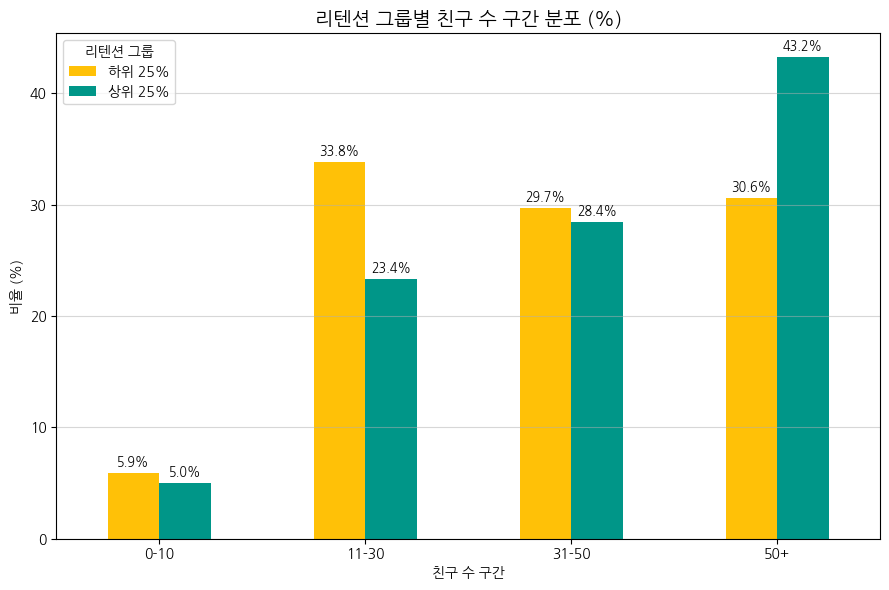

In [105]:
import matplotlib.pyplot as plt

# 1. ÍµêÏ∞®Ìëú + ÎπÑÏú® Î≥ÄÌôò (0~100%)
crosstab = pd.crosstab(
    top_bottom_df["retention_group"],
    top_bottom_df["friend_count_bucket"],
    normalize='index'
) * 100  # ‚Üê %Î°ú Î≥ÄÌôò

crosstab = crosstab.rename(index={"bottom25": "ÌïòÏúÑ 25%", "top25": "ÏÉÅÏúÑ 25%"})


# 2. ÏãúÍ∞ÅÌôî
ax = crosstab.T.plot(
    kind='bar',
    figsize=(9, 6),
    color=["#ffc107", "#009688"],
)

# 3. ÏàòÏπò ÌëúÏãú
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", fontsize=9, padding=3)

# 4. Ïä§ÌÉÄÏùºÎßÅ
plt.title("Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÏπúÍµ¨ Ïàò Íµ¨Í∞Ñ Î∂ÑÌè¨ (%)", fontsize=14)
plt.ylabel("ÎπÑÏú® (%)")
plt.xlabel("ÏπúÍµ¨ Ïàò Íµ¨Í∞Ñ")
plt.xticks(rotation=0)
plt.legend(title="Î¶¨ÌÖêÏÖò Í∑∏Î£π")
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


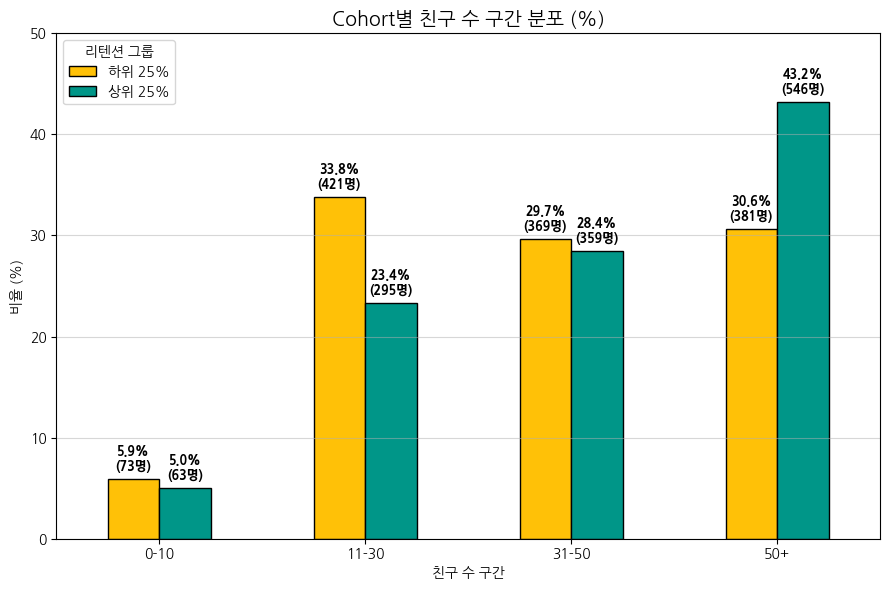

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. ÎπÑÏú® ÌÖåÏù¥Î∏î (%)
crosstab = pd.crosstab(
    top_bottom_df["retention_group"],
    top_bottom_df["friend_count_bucket"],
    normalize='index'
) * 100
crosstab = crosstab.rename(index={"bottom25": "ÌïòÏúÑ 25%", "top25": "ÏÉÅÏúÑ 25%"})

# 2. Í±¥Ïàò ÌÖåÏù¥Î∏î (Î™Ö Ïàò)
raw_counts = pd.crosstab(
    top_bottom_df["retention_group"],
    top_bottom_df["friend_count_bucket"]
)
raw_counts = raw_counts.rename(index={"bottom25": "ÌïòÏúÑ 25%", "top25": "ÏÉÅÏúÑ 25%"})

# 3. ÏãúÍ∞ÅÌôî
ax = crosstab.T.plot(
    kind='bar',
    figsize=(9, 6),
    color=["#ffc107", "#009688"],
    edgecolor='black'
)

# 4. ÏàòÏπò ÌëúÏãú (ÌçºÏÑºÌä∏ + Î™ÖÏàò, ÏàòÏßÅ ÏúÑÏπò Ï°∞Ï†à)
group_labels = list(crosstab.index)  

for i, bars in enumerate(ax.containers):  
    group = group_labels[i]
    for j, bar in enumerate(bars):  
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        bucket = crosstab.columns[j]
        count = raw_counts.loc[group, bucket]

        # üîßÏàòÏπò ÏúÑÏπò Ï°∞Ï†à (
        y_offset = 0.6  
        ax.text(
            x, height + y_offset,
            f"{height:.1f}%\n({count}Î™Ö)",
            ha='center', va='bottom',fontweight='bold',
            fontsize=9
        )

# 5. Ïä§ÌÉÄÏùº
plt.title("CohortÎ≥Ñ ÏπúÍµ¨ Ïàò Íµ¨Í∞Ñ Î∂ÑÌè¨ (%)", fontsize=14)
plt.ylim(0,50)
plt.ylabel("ÎπÑÏú® (%)")
plt.xlabel("ÏπúÍµ¨ Ïàò Íµ¨Í∞Ñ")
plt.xticks(rotation=0)
plt.legend(title="Î¶¨ÌÖêÏÖò Í∑∏Î£π")
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


# Í∞ÄÏûÖ ÌõÑ Ï≤´ Ìà¨ÌëúÍπåÏßÄ Í±∏Î¶∞ ÏùºÏàò

In [ ]:
top_dtv = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["days_to_vote"]
bottom_dtv = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["days_to_vote"]

t_stat, p_val = ttest_ind(top_dtv, bottom_dtv, equal_var=False)
print(" Í∞ÄÏûÖ ÌõÑ Ï≤´ Ìà¨ÌëúÍπåÏßÄ Í±∏Î¶∞ ÏùºÏàò t-test")
print(f"Top25 ÌèâÍ∑†: {top_dtv.mean():.2f}, Bottom25 ÌèâÍ∑†: {bottom_dtv.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

 Í∞ÄÏûÖ ÌõÑ Ï≤´ Ìà¨ÌëúÍπåÏßÄ Í±∏Î¶∞ ÏùºÏàò t-test
Top25 ÌèâÍ∑†: 0.57, Bottom25 ÌèâÍ∑†: 0.20
T-statistic: 5.746, P-value: 0.0000


# Î∞õÏùÄ ÏßàÎ¨∏ Ïó¥Îûå Ïàò

In [23]:
top_bottom_df["total_read"] = top_bottom_df["total_read"].fillna(0)

In [24]:
top_tr = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["total_read"]
bottom_tr = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["total_read"]

t_stat, p_val = ttest_ind(top_tr, bottom_tr, equal_var=False)
print(" Î∞õÏùÄ ÏßàÎ¨∏ Ïó¥Îûå Ïàò t-test")
print(f"Top25 ÌèâÍ∑†: {top_tr.mean():.2f}, Bottom25 ÌèâÍ∑†: {bottom_tr.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

 Î∞õÏùÄ ÏßàÎ¨∏ Ïó¥Îûå Ïàò t-test
Top25 ÌèâÍ∑†: 158.40, Bottom25 ÌèâÍ∑†: 90.67
T-statistic: 13.990, P-value: 0.0000


In [25]:
# Ï°∞Í±¥ Î≥ÄÏàò ÏÉùÏÑ± (Ïó¥Îûå Ïàò 100Ìöå Ïù¥ÏÉÅ Ïó¨Î∂Ä)
top_bottom_df["read_100plus"] = top_bottom_df["total_read"] >= 100

# Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÎπÑÏú® ÌôïÏù∏
print("Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÏßàÎ¨∏ Ïó¥Îûå 100Ìöå Ïù¥ÏÉÅ ÎπÑÏú®:")
print(top_bottom_df.groupby("retention_group")["read_100plus"].mean())

Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÏßàÎ¨∏ Ïó¥Îûå 100Ìöå Ïù¥ÏÉÅ ÎπÑÏú®:
retention_group
bottom25    0.337621
top25       0.540776
Name: read_100plus, dtype: float64


In [26]:
count = top_bottom_df.groupby("retention_group")["read_100plus"].sum()
nobs = top_bottom_df.groupby("retention_group")["read_100plus"].count()

z_stat, p_val = proportions_ztest(count, nobs)
print(f"\nZ-stat: {z_stat:.3f}, p-value: {p_val:.4f}")


Z-stat: -10.246, p-value: 0.0000


In [27]:
top_bottom_df["read_3d_100plus"] = (
    (top_bottom_df["total_read"] >= 100) & (top_bottom_df["days_to_vote"] <= 3)
)

In [28]:
# Í∑∏Î£πÎ≥Ñ Í∞úÏàò
group_counts = top_bottom_df.groupby("retention_group")["read_3d_100plus"].sum()
group_n = top_bottom_df["retention_group"].value_counts()

# Z-test
z_stat, p_val = proportions_ztest(count=group_counts, nobs=group_n)

print("Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ '3Ïùº ÎÇ¥ Ïó¥Îûå 100Ìöå Ïù¥ÏÉÅ' ÎπÑÏú®:")
print(group_counts / group_n)
print(f"\nZ-stat: {z_stat:.3f}, p-value: {p_val:.4f}")

Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ '3Ïùº ÎÇ¥ Ïó¥Îûå 100Ìöå Ïù¥ÏÉÅ' ÎπÑÏú®:
retention_group
bottom25    0.33119
top25       0.50673
dtype: float64

Z-stat: -9.550, p-value: 0.0000


# Ï§ëÍ∞Ñ Ï†ïÎ¶¨

###  Top25 vs Bottom25 Î¶¨ÌÖêÏÖò ÎπÑÍµê ÏöîÏïΩ (5Í∞ú ÏßÄÌëú)

| ÏßÄÌëúÎ™Ö | Top25 ÌèâÍ∑† | Bottom25 ÌèâÍ∑† | Ïú†ÏùòÎØ∏Ìïú Ï∞®Ïù¥ (p-value) | Ìï¥ÏÑù / Ïù∏ÏÇ¨Ïù¥Ìä∏ |
|--------|------------|----------------|--------------------------|------------------|
| **1. Í∞ÄÏûÖ ÌõÑ 3Ïùº Ïù¥ÎÇ¥ Ìà¨Ìëú Ïàò** (`votes_within_3d_count`) | 107.52 | 106.10 | 0.6534 | Î¶¨ÌÖêÏÖòÍ≥º ÌÅ¨Í≤å Í¥ÄÎ†® ÏóÜÏùå. Ï¥àÍ∏∞ ÌôúÎ∞úÌï® ÏûêÏ≤¥Îäî Ï§ëÏöîÌïòÏßÄ ÏïäÏùÑ Ïàò ÏûàÏùå |
| **2. Ìà¨Ìëú ÎåÄÏÉÅ Ïú†Ï†Ä Ïàò** (`vote_nunique_user_count`) | 35.51 | 32.53 | 0.0001 | Îã§ÏñëÌïú Ïú†Ï†ÄÏóêÍ≤å Ìà¨ÌëúÌïú ÏÇ¨ÎûåÏùºÏàòÎ°ù Î¶¨ÌÖêÏÖòÏù¥ ÎÜíÏùÄ Í≤ΩÌñ• |
| **3. ÏπúÍµ¨ Ïàò** (`period_friend_count`) | 45.51 | 41.17 | 0.0000 | **ÏÇ¨ÌöåÏ†Å Ïó∞Í≤∞(ÏπúÍµ¨ Ïàò)**Í∞Ä Î¶¨ÌÖêÏÖòÍ≥º Í∏çÏ†ïÏ†Å ÏÉÅÍ¥Ä Í∞ÄÎä•ÏÑ± |
| **4. Ï≤´ Ìà¨ÌëúÍπåÏßÄ Í±∏Î¶∞ ÏùºÏàò** (`days_to_vote`) | 0.65Ïùº | 0.25Ïùº | 0.0000 | Top Í∑∏Î£πÏùÄ Ï≤úÏ≤úÌûà ÏßÑÏûÖ. ‚Üí Îπ†Î•∏ ÏßÑÏûÖÎ≥¥Îã§ ÏàôÍ≥† ÌõÑ ÏßÑÏûÖÏù¥ Ïò§ÌûàÎ†§ ÏßÄÏÜçÏóê Ïú†Î¶¨Ìï† Ïàò ÏûàÏùå |
| **5. Î∞õÏùÄ ÏßàÎ¨∏ Ïó¥Îûå Ïàò** (`total_read`) | 161.19 | 90.75 | 0.0000 | ÏßàÎ¨∏ Ïó¥Îûå ÌôúÎèôÏù¥ ÎßéÏùÑÏàòÎ°ù Î¶¨ÌÖêÏÖò ÎÜíÏùå. Ï†ÅÍ∑πÏ†Å ÌÉêÏÉâ ÌñâÎèôÏù¥ Ïú†ÏßÄÏú®Ïóê Í∏çÏ†ïÏ†Å |


Î¶¨ÌÖêÏÖòÏù¥ ÎÜíÏùÄ Ïú†Ï†ÄÎäî...

Ï≤´ Ìà¨ÌëúÍπåÏßÄ ÏãúÍ∞ÑÏù¥ Ï°∞Í∏à Îçî Í±∏Î¶¨ÏßÄÎßå,

Îã§ÏñëÌïú Ïú†Ï†ÄÏóêÍ≤å Ìà¨ÌëúÌïòÍ≥†,

ÏπúÍµ¨ ÏàòÍ∞Ä ÎßéÍ≥†,

ÏßàÎ¨∏ÏùÑ ÎßéÏù¥ Ïó¥ÎûåÌïòÎ©∞,

Í∑∏Îü¨ÎÇò Ï¥àÍ∏∞ 3Ïùº ÌôúÎèôÎüâ ÏûêÏ≤¥Îäî Î¶¨ÌÖêÏÖòÍ≥º Î¨¥Í¥ÄÌï† Ïàò ÏûàÎã§.

Ï¥àÍ∏∞ ÏßÑÏûÖ Ïû•Î≤ΩÏùÑ ÏïΩÍ∞Ñ ÎÜíÏù¥Í±∞ÎÇò, Ï∂©Î∂ÑÌûà Ïï±ÏùÑ ÌÉêÏÉâÌï† Ïàò ÏûàÎèÑÎ°ù Ïú†ÎèÑÌïòÎäî Ï†ÑÎûµÏù¥ Î¶¨ÌÖêÏÖòÏóê Í∏çÏ†ïÏ†ÅÏùº Ïàò ÏûàÏùå.

Îã§ÏñëÌïú Ïú†Ï†ÄÏôÄÏùò ÏÉÅÌò∏ÏûëÏö© Ïú†ÎèÑ, ÏπúÍµ¨ Í∏∞Îä• Í∞ïÌôî, ÏßàÎ¨∏ Ïó¥Îûå Í≤ΩÌóò Í∞ïÏ°∞ Îì±Ïù¥ ÌïµÏã¨ Í∞úÏÑ† Ìè¨Ïù∏Ìä∏Î°ú Î≥¥ÏûÑ.

In [14]:
top_bottom_df 

Unnamed: 0  user_id  total_votes  unique_days  first_vote   last_vote  \
0              1   838466          127            6  2023-05-02  2023-05-07   
1              7   840512          131            7  2023-05-02  2023-05-16   
2              8   840685          547           16  2023-05-02  2023-05-23   
3              9   840902          245           13  2023-05-02  2023-05-17   
4             11   841576          227           11  2023-05-09  2023-05-21   
...          ...      ...          ...          ...         ...         ...   
2492        4672  1497413          118            2  2023-05-24  2023-05-25   
2493        4673  1497699           15            2  2023-05-24  2023-05-25   
2494        4674  1498168           30            2  2023-05-24  2023-05-25   
2495        4675  1498266            4            1  2023-05-24  2023-05-24   
2496        4676  1499419           37            2  2023-05-24  2023-05-25   

      active_days  cohort_day  retention_day8 ret_group  ... candidate_count  \
0               5  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            82.0   
1              14  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            90.0   
2              21  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...           102.0   
3              15  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            86.0   
4              12  2023-05-09        0.731602     50 Ïù¥ÏÉÅ  ...            89.0   
...           ...         ...             ...       ...  ...             ...   
2492            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...            11.0   
2493            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             NaN   
2494            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             8.0   
2495            0  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             NaN   
2496            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             4.0   

     chosen_count     ratio       address  student_count  school_type  \
0            37.0  0.451220      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
1            28.0  0.311111      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
2            27.0  0.264706      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
3            18.0  0.209302      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
4            23.0  0.258427       Í≤ΩÍ∏∞ÎèÑ Í¥ëÏ£ºÏãú            486            H   
...           ...       ...           ...            ...          ...   
2492          7.0  0.636364      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   
2493          NaN       NaN  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨            491            H   
2494          1.0  0.125000      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   
2495          NaN       NaN     Ïö∏ÏÇ∞Í¥ëÏó≠Ïãú Ïö∏Ï£ºÍµ∞            550            H   
2496          2.0  0.500000      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   

      firstquestion_id               first_question_text  \
0                  298                Ïò∑Ïù¥ Ï†úÏùº ÎßéÏùÑ Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
1                  219  ÎßàÏà†Ïù¥ ÎààÏÜçÏûÑÏù¥ ÏïÑÎãàÎùº ÎßàÎ≤ïÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌï† Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
2                  120             Î≥∏Ïù∏ Î∞©Ïù¥ Ï†úÏùº Íπ®ÎÅóÌï†Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
3                  332        ÏÑ†Î¨º Í≥†Î•¥Îäî ÏÑºÏä§Í∞Ä Í∞ÄÏû• Ï¢ãÏùÑ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
4                  410           Î∞úÎÉÑÏÉàÍ∞Ä Ìò∏ÎëêÍ≥ºÏûê ÎÉÑÏÉàÏùº Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
...                ...                               ...   
2492              1046       Ï°∏ÏóÖ ÌõÑ ÎèôÏ∞ΩÌöåÏóêÏÑú Ï≤≠Ï≤©Ïû• ÎèåÎ¶¥ Í≤É Í∞ôÏùÄ ÏπúÍµ¨Îäî?   
2493               336               Ï†úÎåÄÎ°ú ÎÜÄ Îïå Î∂ÄÎ•¥Í≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî?   
2494               911                 ÎãµÏû• ÏÜçÎèÑÍ∞Ä Í∞ÄÏû• Îπ†Î•∏ ÏÇ¨ÎûåÏùÄ?   
2495               914                 ÏòàÏà†Í∞êÍ∞ÅÏù¥ Í∞ÄÏû• Îõ∞Ïñ¥ÎÇú ÏπúÍµ¨Îäî?   
2496               831                         Í≥ºÏ¶ôÏÉÅÏù∏ ÏπúÍµ¨Îäî?   

      first_

In [15]:
top_bottom_df.columns

Index(['Unnamed: 0', 'user_id', 'total_votes', 'unique_days', 'first_vote',
       'last_vote', 'active_days', 'cohort_day', 'retention_day8', 'ret_group',
       'ret_group_over', 'ret_group_under', 'gender', 'group_id', 'school_id',
       'grade', 'votes_within_3d_count', 'reported_user_count',
       'vote_nunique_user_count', 'period_friend_count', 'sign_up_date',
       'first_vote_date', 'first_point_use_date', 'first_point_use_amount',
       'vote_sameday_signup', 'days_to_vote', 'days_to_point',
       'days_to_point_after_vote', 'first_vote_hour',
       'first_voteday_question_count', 'total_voted', 'total_read',
       'opposite_sex_votes_received_count', 'opposite_sex_vote_received_ratio',
       'candidate_count', 'chosen_count', 'ratio', 'address', 'student_count',
       'school_type', 'firstquestion_id', 'first_question_text',
       'first_question_category', 'retention_group'],
      dtype='object')

<Axes: xlabel='retention_group', ylabel='first_vote_hour'>

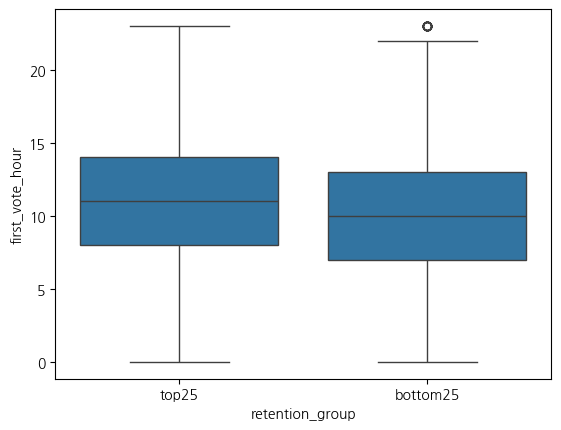

In [16]:
sns.boxplot(data=top_bottom_df, x="retention_group", y="first_vote_hour")


In [17]:
from scipy.stats import ttest_ind

top_hour = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["first_vote_hour"]
bottom_hour = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["first_vote_hour"]

t_stat, p_val = ttest_ind(top_hour, bottom_hour, equal_var=False)
print("Ï≤´ Ìà¨Ìëú ÏãúÍ∞ÑÎåÄ t-test Í≤∞Í≥º")
print(f"Top25 ÌèâÍ∑†: {top_hour.mean():.2f}, Bottom25 ÌèâÍ∑†: {bottom_hour.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")


Ï≤´ Ìà¨Ìëú ÏãúÍ∞ÑÎåÄ t-test Í≤∞Í≥º
Top25 ÌèâÍ∑†: 11.00, Bottom25 ÌèâÍ∑†: 9.75
T-statistic: 6.226, P-value: 0.0000


/tmp/ipykernel_678731/1969772371.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Î¶¨ÌÖêÏÖò Í∑∏Î£π")


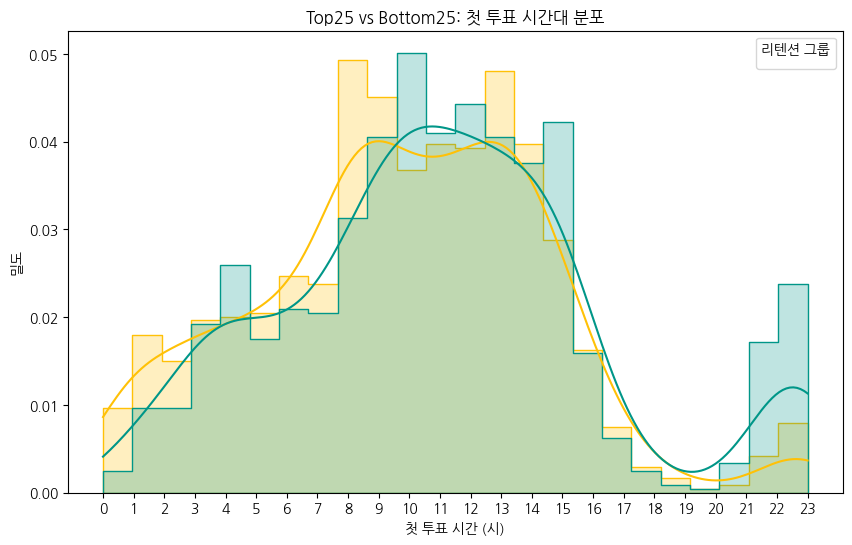

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=top_bottom_df, x="first_vote_hour", hue="retention_group", 
             bins=24, kde=True, element="step", stat="density", palette=["#009688", "#ffc107"])
plt.title("Top25 vs Bottom25: Ï≤´ Ìà¨Ìëú ÏãúÍ∞ÑÎåÄ Î∂ÑÌè¨")
plt.xlabel("Ï≤´ Ìà¨Ìëú ÏãúÍ∞Ñ (Ïãú)")
plt.ylabel("Î∞ÄÎèÑ")
plt.xticks(range(0, 24))
plt.legend(title="Î¶¨ÌÖêÏÖò Í∑∏Î£π")
plt.show()

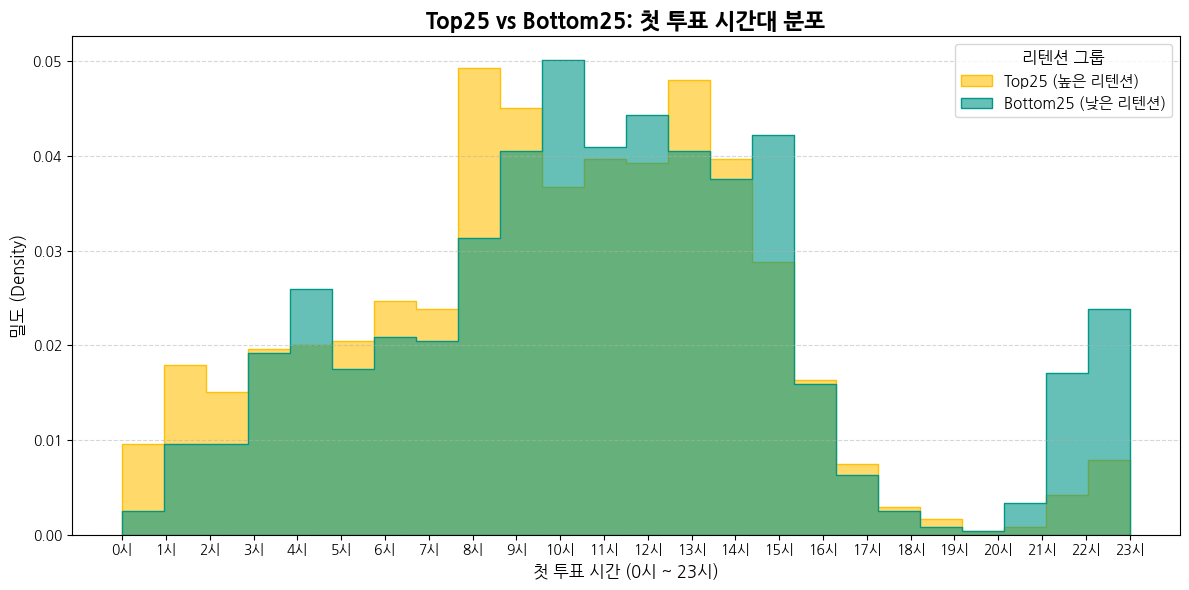

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=top_bottom_df,
    x="first_vote_hour",
    hue="retention_group",
    bins=24,
    kde=False,  # ÏïàÏ†ÑÌïòÍ≤å KDE Ï†úÍ±∞
    element="step",
    stat="density",
    palette={"top25": "#009688", "bottom25": "#ffc107"},
    alpha=0.6
)

plt.title("Top25 vs Bottom25: Ï≤´ Ìà¨Ìëú ÏãúÍ∞ÑÎåÄ Î∂ÑÌè¨", fontsize=16, weight="bold")
plt.xlabel("Ï≤´ Ìà¨Ìëú ÏãúÍ∞Ñ (0Ïãú ~ 23Ïãú)", fontsize=12)
plt.ylabel("Î∞ÄÎèÑ (Density)", fontsize=12)
plt.xticks(ticks=range(0, 24), labels=[f"{h}Ïãú" for h in range(0, 24)], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(
    title="Î¶¨ÌÖêÏÖò Í∑∏Î£π",
    title_fontsize=12,
    fontsize=11,
    labels=["Top25 (ÎÜíÏùÄ Î¶¨ÌÖêÏÖò)", "Bottom25 (ÎÇÆÏùÄ Î¶¨ÌÖêÏÖò)"],
    loc="upper right"
)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

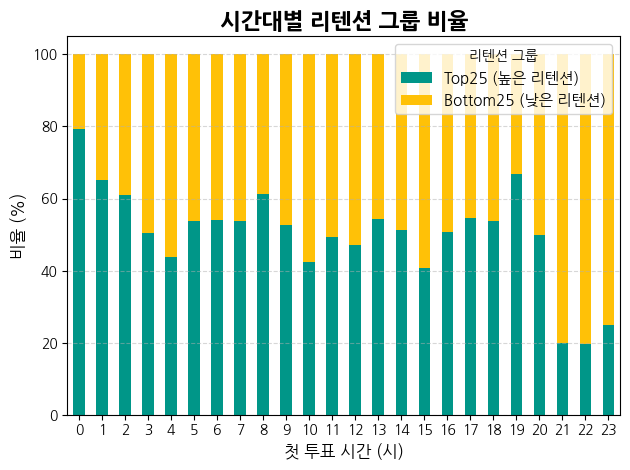

In [20]:
# ÏãúÍ∞ÑÎåÄÎ≥Ñ Î¶¨ÌÖêÏÖò Í∑∏Î£π Ïú†Ï†Ä Ïàò ÏßëÍ≥Ñ
hourly_counts = top_bottom_df.groupby(["first_vote_hour", "retention_group"])["user_id"].count().reset_index()
hourly_pivot = hourly_counts.pivot(index="first_vote_hour", columns="retention_group", values="user_id").fillna(0)

# ÎπÑÏú®(%) Í≥ÑÏÇ∞
hourly_pct = hourly_pivot.div(hourly_pivot.sum(axis=1), axis=0) * 100

# Î∞î Í∑∏ÎûòÌîÑ (Stacked)
plt.figure(figsize=(12, 6))
hourly_pct.plot(kind="bar", stacked=True, color=["#009688", "#ffc107"])

plt.title("ÏãúÍ∞ÑÎåÄÎ≥Ñ Î¶¨ÌÖêÏÖò Í∑∏Î£π ÎπÑÏú®", fontsize=16, weight="bold")
plt.xlabel("Ï≤´ Ìà¨Ìëú ÏãúÍ∞Ñ (Ïãú)", fontsize=12)
plt.ylabel("ÎπÑÏú® (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Î¶¨ÌÖêÏÖò Í∑∏Î£π", labels=["Top25 (ÎÜíÏùÄ Î¶¨ÌÖêÏÖò)", "Bottom25 (ÎÇÆÏùÄ Î¶¨ÌÖêÏÖò)"], fontsize=11)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib



In [3]:
hackle_df = pd.read_parquet("/home/sprintda05/final/hackle/2023-05-06.parquet")

In [58]:
hackle_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7106588 entries, 0 to 7106587
Data columns (total 13 columns):
 #   Column             Dtype                     
---  ------             -----                     
 0   timestamp          datetime64[ns, UTC]       
 1   event_key          object                    
 2   session_id         object                    
 3   user_id            object                    
 4   value              float64                   
 5   user_properties    object                    
 6   hackle_properties  object                    
 7   event_properties   object                    
 8   id                 object                    
 9   device_id          object                    
 10  date               object                    
 11  timestamp_kst      datetime64[ns, Asia/Seoul]
 12  hour               int32                     
dtypes: datetime64[ns, Asia/Seoul](1), datetime64[ns, UTC](1), float64(1), int32(1), object(9)
memory usage: 677.7+ MB


In [59]:
hackle_df

timestamp       event_key  \
0       2023-05-07 00:00:00.014000+00:00    $session_end   
1       2023-05-07 00:00:00.159000+00:00    $session_end   
2       2023-05-07 00:00:00.244000+00:00    $session_end   
3       2023-05-07 00:00:00.255000+00:00  $session_start   
4       2023-05-07 00:00:00.316000+00:00  $session_start   
...                                  ...             ...   
7106583 2023-05-12 23:59:59.718000+00:00    $session_end   
7106584 2023-05-12 23:59:59.767000+00:00    $session_end   
7106585 2023-05-12 23:59:59.774000+00:00    $session_end   
7106586 2023-05-12 23:59:59.982000+00:00    $session_end   
7106587 2023-05-12 23:59:59.997000+00:00  $session_start   

                                   session_id user_id  value user_properties  \
0                OoWMTpTWpUa4m8I1RiKOk75Xnvs1    None    0.0              []   
1                CrFi87nvwiVvHExxP9uSfIHOmBy1    None    0.0              []   
2                W6frWgWJtbWTJwdm6eVWPGKwY2Y2    None    0.0              []   
3        4EFB4D45-0AAF-424A-8E4E-2F19249C8892    None    0.0              []   
4                JdxVFvtz6AcxxOZVvl6plHayjYJ3    None    0.0              []   
...                                       ...     ...    ...             ...   
7106583          uPxxXXZYFmMGCLZdNhtSine1cgG3    None    0.0              []   
7106584          VxISYEYmoLOi13a50CPbfU9bGWY2    None    0.0              []   
7106585          fElOH2pD2xbMgPY39hVxmXD9lnd2    None    0.0              []   
7106586          suXh4zWRBIQgAu7r7qDVLRXFAag2    None    0.0              []   
7106587          ohsPlr8uEBfMUNIXZxqvHeNgRMD3    None    0.0              []   

                                         hackle_properties  \
0        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
1        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
4        {'language': 'ko', 'isapp': 'true', 'osversion...   
...                                                    ...   
7106583  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
7106584  {'language': 'ko', 'isapp': 'true', 'osversion...   
7106585  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
7106586  {'language': 'ko', 'isapp': 'true', 'osversion...   
7106587  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   

                                event_properties  \
0        {'sessionid': '1683384973159.076d488c'}   
1        {'sessionid': '1683377977126.ecbb48be'}   
2        {'sessionid': '1683385158861.10bc1ad8'}   
3        {'sessionid': '1683385200255.b26bcb8c'}   
4        {'sessionid': '1683385200316.4c60e55a'}   
...                                          ...   
7106583  {'sessionid': '1683901438592.b17e8706'}   
7106584  {'sessionid': '1683900321215.63cd03a9'}   
7106585  {'sessionid': '1683901254482.75e0403d'}   
7106586  {'sessionid': '1683898466941.22557276'}   
7106587  {'sessionid': '1683903599997.526fb289'}   

                                           id  \
0        af49a3ac-cf10-49c9-a846-75c6350a331e   
1        ea3608d7-51f7-417f-9560-484896fb265d   
2        0d9da666-4047-4d40-a5ac-992876799cf4   
3        947d1fff-5e4c-44e2-b106-f23cddbe0dc4   
4        28e3afe4-098a-4bef-a699-4e3fa325b3ab   
...                                       ...   
7106583  f22b1603-2460-44c7-b7b2-b86a34b7d0fc   
7106584  edc147d8-827e-4ec0-a50f-b6aa3af95247   
7106585  bb3e735e-7ec5-479f-9b7c-4c87dae32ebe   
7106586  3a27db8e-39dd-46bd-ab83-06ea374e3a18   
7106587  b02eeb3c-e83b-4fbd-94e7-e44b5ac17d25   

                                    device_id        date  \
0        498dbc0f-4537-41dc-93ec-f4406302a3b0  2023-05-07   
1        7770afa8-e228-4736-aa2a-658ebe2e3d25  2023-05-07   
2        9fbdc45d-a74a-4d9f-9d40-0f400b72877e  2023-05-07   
3        4efb4d45-0aaf-424a-8e4e-2f19249c8892  2023-05-07   
4        96348488-4d6a-49a8-8995-452718157fd7  2023-05-07   
...                     

In [60]:
hackle_df['device_id']

0          498dbc0f-4537-41dc-93ec-f4406302a3b0
1          7770afa8-e228-4736-aa2a-658ebe2e3d25
2          9fbdc45d-a74a-4d9f-9d40-0f400b72877e
3          4efb4d45-0aaf-424a-8e4e-2f19249c8892
4          96348488-4d6a-49a8-8995-452718157fd7
                           ...                 
7106583    6a95d3bc-552a-4cf1-a080-c57b481097ae
7106584    5b225c86-adb5-4813-87e7-fb9bee753f31
7106585    88107386-2186-45b5-9edb-ec9f0b8f0283
7106586    ef3d802d-e80d-4657-92ac-fe3b1a2ddb7e
7106587    e1eb42ec-727b-4ccc-9156-1fabbad3dc9a
Name: device_id, Length: 7106588, dtype: object

In [5]:
hackle_df['Asia/Seoul'].min()

'2023-05-07T00:00:00.014Z'

In [6]:
hackle_df['Asia/Seoul'].max()

'2023-05-12T23:59:59.997Z'

In [11]:
hackle_df["event_key"].nunique()

2

In [14]:
hackle_df["event_key"]

0            $session_end
1            $session_end
2            $session_end
3          $session_start
4          $session_start
                ...      
7106583      $session_end
7106584      $session_end
7106585      $session_end
7106586      $session_end
7106587    $session_start
Name: event_key, Length: 7106588, dtype: object

In [8]:
hackle_df["event_key"].value_counts()

event_key
$session_start    3706889
$session_end      3399699
Name: count, dtype: int64

In [10]:
hackle_df.isnull().sum()


Asia/Seoul                 0
event_key                  0
session_id                 0
user_id              7106588
value                      0
user_properties            0
hackle_properties          0
event_properties           0
id                         0
device_id                  0
dtype: int64

In [16]:
# timestampÎäî 'Asia/Seoul'Ïù¥ÎùºÎäî ÏûòÎ™ªÎêú Ïª¨ÎüºÎ™ÖÏóê ÏûàÏùå ‚Üí Ïù¥Î¶Ñ Î≥ÄÍ≤Ω ÌïÑÏàò!
hackle_df = hackle_df.rename(columns={'Asia/Seoul': 'timestamp'})
hackle_df['timestamp'] = pd.to_datetime(hackle_df['timestamp'], utc=True)
hackle_df['timestamp_kst'] = hackle_df['timestamp'].dt.tz_convert('Asia/Seoul')
hackle_df['date'] = hackle_df['timestamp'].dt.tz_convert('Asia/Seoul').dt.date


In [17]:
dau_df = hackle_df.groupby('date')['device_id'].nunique().reset_index(name='DAU')


In [18]:
dau_df

date     DAU
0  2023-05-07   70817
1  2023-05-08  125260
2  2023-05-09  144107
3  2023-05-10  184233
4  2023-05-11  199929
5  2023-05-12  218113
6  2023-05-13  188763

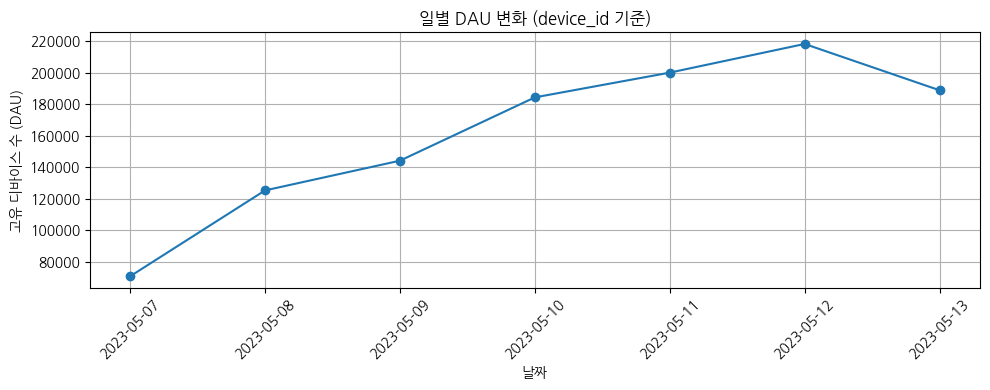

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(dau_df['date'], dau_df['DAU'], marker='o')
plt.title("ÏùºÎ≥Ñ DAU Î≥ÄÌôî (device_id Í∏∞Ï§Ä)")
plt.xlabel("ÎÇ†Ïßú")
plt.ylabel("Í≥†Ïú† ÎîîÎ∞îÏù¥Ïä§ Ïàò (DAU)")
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [43]:
# ÏÑ∏ÏÖò ÏãúÏûë: device_id Ìè¨Ìï®Ìï¥ÏÑú ÏÑ†ÌÉù
session_start = hackle_df[hackle_df['event_key'] == '$session_start'][['session_id', 'timestamp_kst', 'device_id']]
session_end = hackle_df[hackle_df['event_key'] == '$session_end'][['session_id', 'timestamp_kst']]

# Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨
session_start = session_start.rename(columns={'timestamp_kst': 'start_time'})
session_end = session_end.rename(columns={'timestamp_kst': 'end_time'})

# Î≥ëÌï©
session = pd.merge(session_start, session_end, on='session_id', how='inner')

# ÏÑ∏ÏÖò Í∏∏Ïù¥ Í≥ÑÏÇ∞
session['duration_sec'] = (session['end_time'] - session['start_time']).dt.total_seconds()

# Ïù¥ÏÉÅÏπò Ï†úÍ±∞
session = session[(session['duration_sec'] > 0) & (session['duration_sec'] < 7200)]

# ÎÇ†Ïßú Ïª¨Îüº
session['date'] = session['start_time'].dt.date



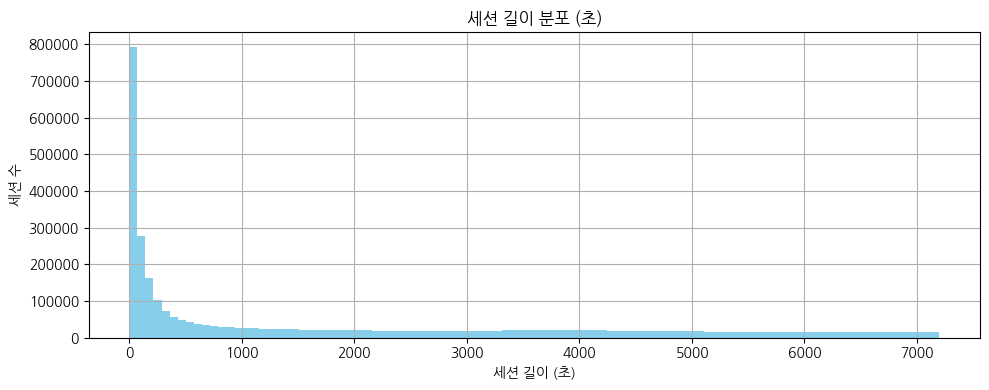

In [24]:
plt.figure(figsize=(10, 4))
plt.hist(session['duration_sec'], bins=100, color='skyblue')
plt.title("ÏÑ∏ÏÖò Í∏∏Ïù¥ Î∂ÑÌè¨ (Ï¥à)")
plt.xlabel("ÏÑ∏ÏÖò Í∏∏Ïù¥ (Ï¥à)")
plt.ylabel("ÏÑ∏ÏÖò Ïàò")
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
session['duration_sec'].max()

7199.999

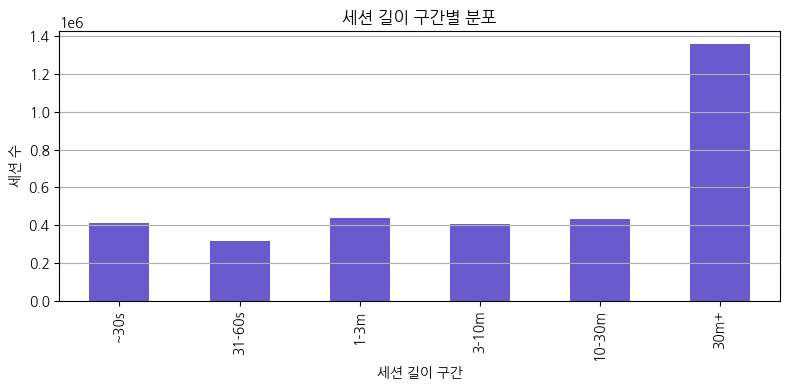

In [25]:
# ÏÑ∏ÏÖò Í∏∏Ïù¥ Íµ¨Í∞Ñ ÏÑ§Ï†ï (Ï¥à Îã®ÏúÑ)
bins = [0, 30, 60, 180, 600, 1800, 7200]
labels = ['~30s', '31-60s', '1-3m', '3-10m', '10-30m', '30m+']
session['duration_group'] = pd.cut(session['duration_sec'], bins=bins, labels=labels)

# Î∂ÑÌè¨ ÏßëÍ≥Ñ
group_distribution = session['duration_group'].value_counts().sort_index()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 4))
group_distribution.plot(kind='bar', color='slateblue')
plt.title("ÏÑ∏ÏÖò Í∏∏Ïù¥ Íµ¨Í∞ÑÎ≥Ñ Î∂ÑÌè¨")
plt.xlabel("ÏÑ∏ÏÖò Í∏∏Ïù¥ Íµ¨Í∞Ñ")
plt.ylabel("ÏÑ∏ÏÖò Ïàò")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [27]:
daily_avg_session = session.groupby('date')['duration_sec'].mean().reset_index(name='avg_session_duration_sec')


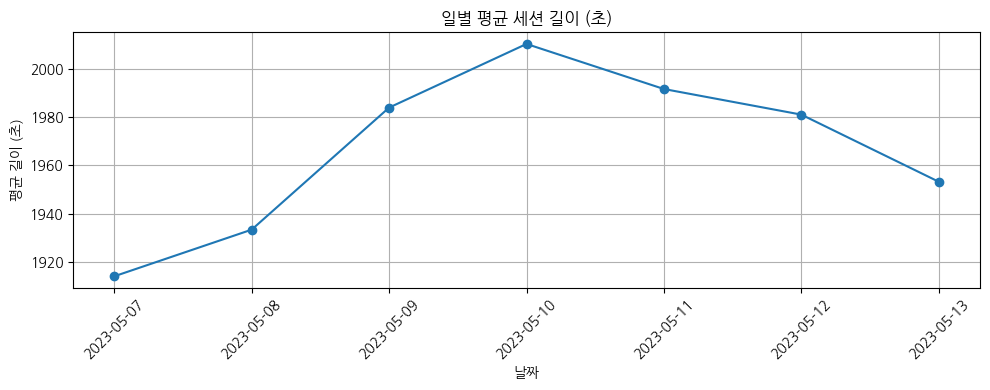

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(daily_avg_session['date'], daily_avg_session['avg_session_duration_sec'], marker='o')
plt.title("ÏùºÎ≥Ñ ÌèâÍ∑† ÏÑ∏ÏÖò Í∏∏Ïù¥ (Ï¥à)")
plt.xlabel("ÎÇ†Ïßú")
plt.ylabel("ÌèâÍ∑† Í∏∏Ïù¥ (Ï¥à)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
hackle_df['hour'] = hackle_df['timestamp_kst'].dt.hour


In [30]:
hackle_df['hour'] 

0          9
1          9
2          9
3          9
4          9
          ..
7106583    8
7106584    8
7106585    8
7106586    8
7106587    8
Name: hour, Length: 7106588, dtype: int32

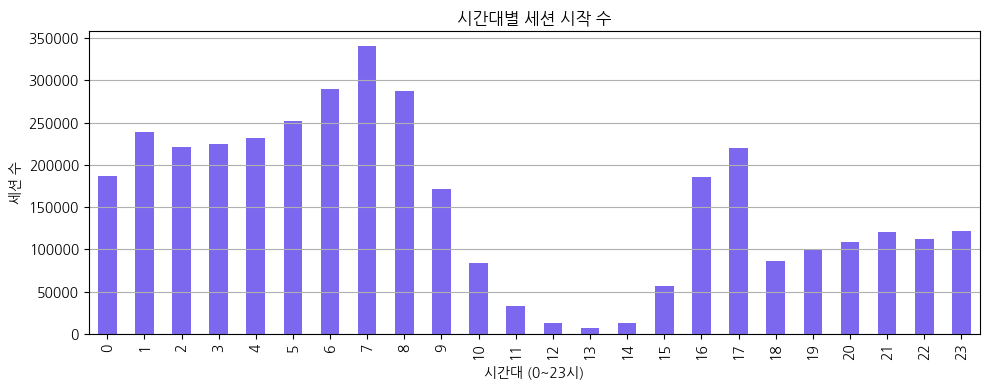

In [31]:
session_start = hackle_df[hackle_df['event_key'] == '$session_start']
hourly_session_count = session_start['hour'].value_counts().sort_index()


plt.figure(figsize=(10, 4))
hourly_session_count.plot(kind='bar', color='mediumslateblue')
plt.title("ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏÑ∏ÏÖò ÏãúÏûë Ïàò")
plt.xlabel("ÏãúÍ∞ÑÎåÄ (0~23Ïãú)")
plt.ylabel("ÏÑ∏ÏÖò Ïàò")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


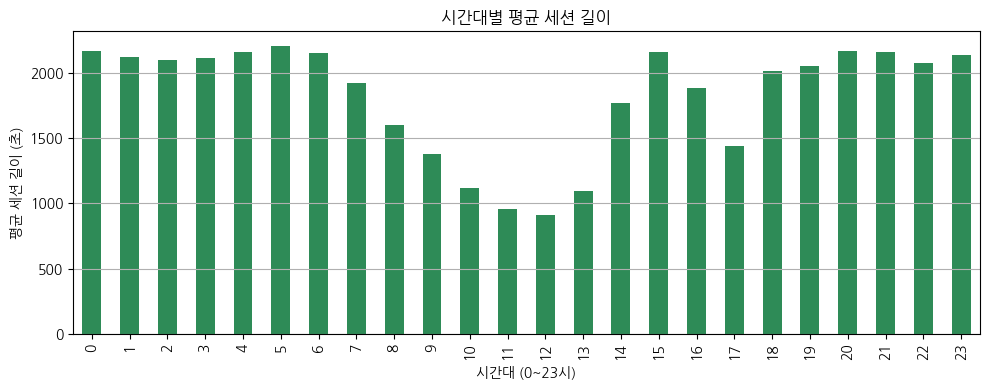

In [32]:
# session ÌÖåÏù¥Î∏îÏóê hour Î∂ôÏù¥Í∏∞
session['hour'] = session['start_time'].dt.hour

hourly_avg_duration = session.groupby('hour')['duration_sec'].mean()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 4))
hourly_avg_duration.plot(kind='bar', color='seagreen')
plt.title("ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌèâÍ∑† ÏÑ∏ÏÖò Í∏∏Ïù¥")
plt.xlabel("ÏãúÍ∞ÑÎåÄ (0~23Ïãú)")
plt.ylabel("ÌèâÍ∑† ÏÑ∏ÏÖò Í∏∏Ïù¥ (Ï¥à)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [33]:
# ÏÑ∏ÏÖò ÏãúÏûë Í∏∞Ï§ÄÏúºÎ°ú device_idÎãπ ÏÑ∏ÏÖò Ïàò ÏßëÍ≥Ñ
session_start = hackle_df[hackle_df['event_key'] == '$session_start']

device_session_count = session_start.groupby('device_id')['session_id'].nunique().reset_index(name='session_count')


In [34]:
mean_session_per_device = device_session_count['session_count'].mean()
print(f"ÎîîÎ∞îÏù¥Ïä§Îãπ ÌèâÍ∑† ÏÑ∏ÏÖò Ïàò: {mean_session_per_device:.2f}")


ÎîîÎ∞îÏù¥Ïä§Îãπ ÌèâÍ∑† ÏÑ∏ÏÖò Ïàò: 1.77


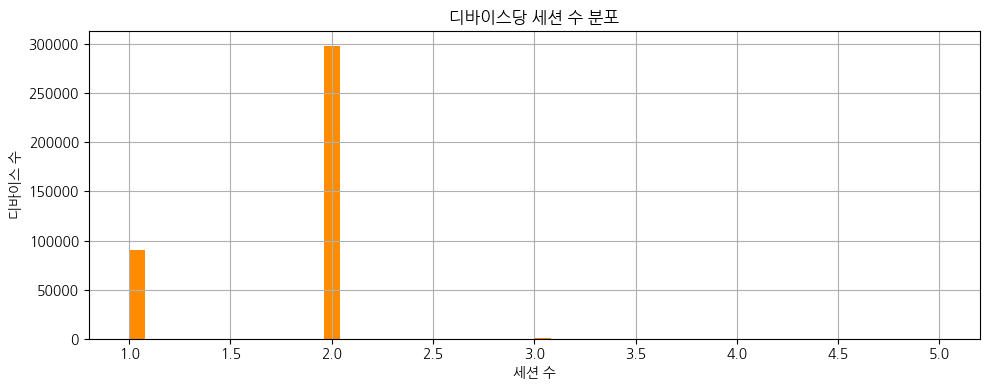

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(device_session_count['session_count'], bins=50, color='darkorange')
plt.title("ÎîîÎ∞îÏù¥Ïä§Îãπ ÏÑ∏ÏÖò Ïàò Î∂ÑÌè¨")
plt.xlabel("ÏÑ∏ÏÖò Ïàò")
plt.ylabel("ÎîîÎ∞îÏù¥Ïä§ Ïàò")
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# 2. device_idÏôÄ dateÏùò Ï°∞Ìï©ÏùÑ Ï§ëÎ≥µ ÏóÜÏù¥ Ï∂îÏ∂ú
device_date = session_start[['device_id', 'date']].drop_duplicates()

# 3. device_idÎ≥Ñ Î∞©Î¨∏Ïùº Ïàò Í≥ÑÏÇ∞
device_visit_days = device_date.groupby('device_id').size().reset_index(name='visit_days')

In [37]:
mean_visit_days = device_visit_days['visit_days'].mean()
print(f"ÎîîÎ∞îÏù¥Ïä§Îãπ ÌèâÍ∑† Î∞©Î¨∏Ïùº Ïàò: {mean_visit_days:.2f}Ïùº")


ÎîîÎ∞îÏù¥Ïä§Îãπ ÌèâÍ∑† Î∞©Î¨∏Ïùº Ïàò: 2.83Ïùº


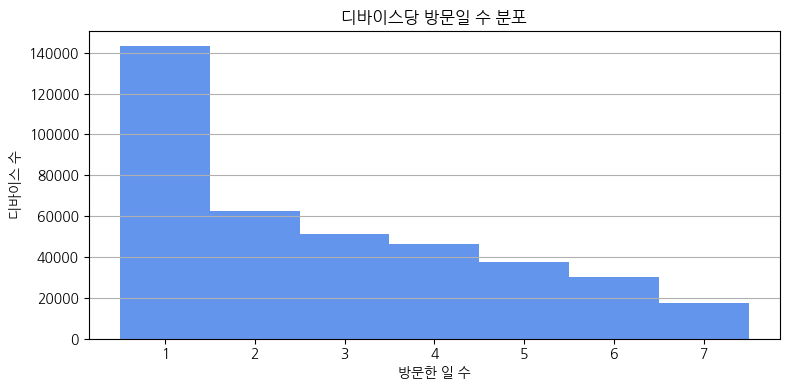

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(device_visit_days['visit_days'], bins=range(1, device_visit_days['visit_days'].max() + 2), align='left', color='cornflowerblue')
plt.title("ÎîîÎ∞îÏù¥Ïä§Îãπ Î∞©Î¨∏Ïùº Ïàò Î∂ÑÌè¨")
plt.xlabel("Î∞©Î¨∏Ìïú Ïùº Ïàò")
plt.ylabel("ÎîîÎ∞îÏù¥Ïä§ Ïàò")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [40]:
device_date = session_start[['device_id', 'date']].drop_duplicates()
visit_days = device_date.groupby('device_id').size().reset_index(name='visit_days')


In [44]:
avg_duration = session.groupby('device_id')['duration_sec'].mean().reset_index(name='avg_duration')


In [45]:
# Î≥ëÌï©
user_quality = pd.merge(visit_days, avg_duration, on='device_id')

# ÏßÑÏÑ± Ïú†Ï†Ä Ï°∞Í±¥ Ï†ÅÏö©
user_quality['is_core_user'] = (user_quality['visit_days'] >= 3) & (user_quality['avg_duration'] >= 1000)

# ÏßÑÏÑ± Ïú†Ï†Ä Ïàò ÌôïÏù∏
core_user_count = user_quality['is_core_user'].sum()
total_user_count = len(user_quality)

print(f"ÏßÑÏÑ± Ïú†Ï†Ä Ïàò: {core_user_count}")
print(f"Ï†ÑÏ≤¥ Ïú†Ï†Ä Ïàò: {total_user_count}")
print(f"ÏßÑÏÑ± Ïú†Ï†Ä ÎπÑÏú®: {core_user_count / total_user_count:.2%}")


ÏßÑÏÑ± Ïú†Ï†Ä Ïàò: 145581
Ï†ÑÏ≤¥ Ïú†Ï†Ä Ïàò: 336160
ÏßÑÏÑ± Ïú†Ï†Ä ÎπÑÏú®: 43.31%


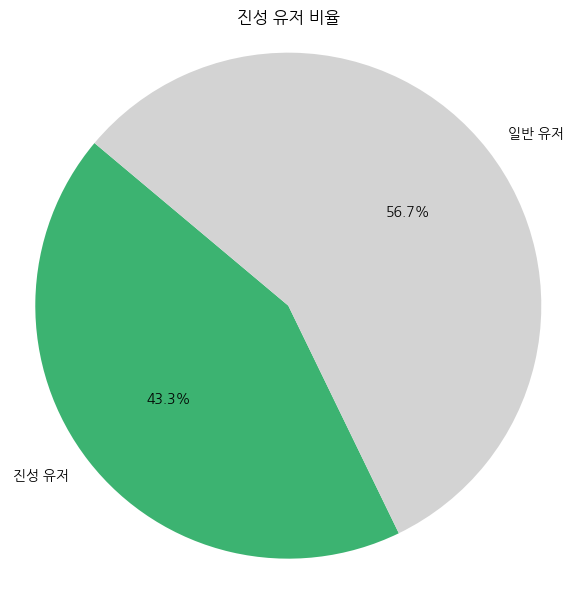

In [64]:
labels = ['ÏßÑÏÑ± Ïú†Ï†Ä', 'ÏùºÎ∞ò Ïú†Ï†Ä']
sizes = [core_user_count, total_user_count - core_user_count]
colors = ['mediumseagreen', 'lightgray']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("ÏßÑÏÑ± Ïú†Ï†Ä ÎπÑÏú®")
plt.axis('equal')
plt.tight_layout()
plt.show()

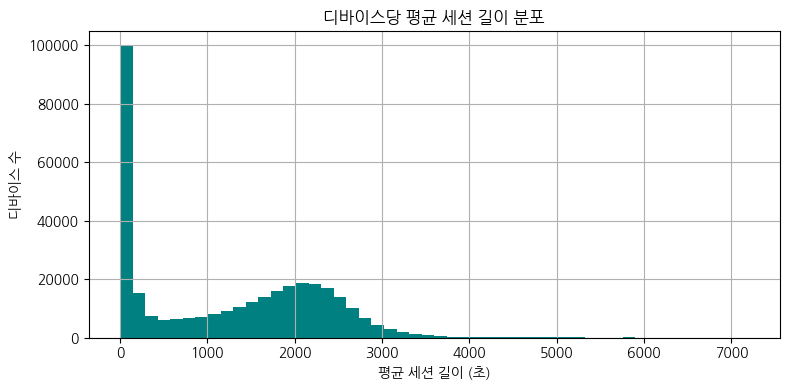

In [46]:
plt.figure(figsize=(8, 4))
user_quality['avg_duration'].hist(bins=50, color='teal')
plt.title("ÎîîÎ∞îÏù¥Ïä§Îãπ ÌèâÍ∑† ÏÑ∏ÏÖò Í∏∏Ïù¥ Î∂ÑÌè¨")
plt.xlabel("ÌèâÍ∑† ÏÑ∏ÏÖò Í∏∏Ïù¥ (Ï¥à)")
plt.ylabel("ÎîîÎ∞îÏù¥Ïä§ Ïàò")
plt.grid(True)
plt.tight_layout()
plt.show()


# Ïù¥ÏÉÅ ÏÑ∏ÏÖò ÌÉêÏÉâ

In [ ]:
# Í∞ÄÏû• Í∏¥ ÏÑ∏ÏÖò 20
top_long_sessions = session.sort_values(by='duration_sec', ascending=False).head(20)
top_long_sessions[['device_id', 'duration_sec']].reset_index(drop=True)


device_id  duration_sec
0   23dba8ec-dfe3-4290-a0e9-f607a0328819      7199.999
1   0f7b607c-3715-4ba1-bad4-3d584e106492      7199.996
2   21456a08-7788-4e3f-a743-7de9e3476270      7199.989
3   5be237f6-3c31-47c1-865b-fd8f6415fdc3      7199.989
4   c699753f-3cdc-4ee1-bd03-03129021dc5c      7199.982
5   6897be7e-e0a9-470d-978e-a7e0a28c77e8      7199.976
6   bec0966d-4f9b-499a-b721-8c82db207ad7      7199.973
7   853f361a-028b-4c9d-89a7-40f5c37a69c2      7199.968
8   b63a5a46-9b69-4586-b5ae-0d7cec7a5063      7199.966
9   24995a98-4c5e-43dc-93df-3ebf7a23cbeb      7199.962
10  ecb4f95f-e105-46dd-b319-f28a048e9344      7199.959
11  d50a623f-0165-49c7-a8bf-cfbdcde047c0      7199.958
12  997e2dff-763f-4786-9310-2cc0e5e5c86e      7199.950
13  1c14bfd4-a856-47ab-82c1-d9537793164f      7199.944
14  c3a41c39-2399-480b-b014-3c8c9d3b027e      7199.938
15  0a7447de-fc0e-44ba-ac1f-a7ae8f07cc4f      7199.938
16  9a65c362-63e7-4695-bdd9-edb27b0628d9      7199.934
17  ab07987c-c6b9-43ed-9826-9d086f5bff27      7199.934
18  f44f61e9-44c3-4b6e-b823-dadd7f99ed6b      7199.925
19  306a96f0-0a1c-4de9-8c99-56646f0a465f      7199.917

In [49]:
# ÎîîÎ∞îÏù¥Ïä§Î≥Ñ ÏÑ∏ÏÖò Ïàò 20
device_session_count = session.groupby('device_id')['session_id'].nunique().reset_index(name='session_count')
top_session_device = device_session_count.sort_values(by='session_count', ascending=False).head(20)


In [51]:
device_session_count

device_id  session_count
0       00002245-458f-4cdd-8533-b448cd43dbd2              1
1       00008546-4b7b-47cc-8b61-2ac9ac0745ae              2
2       00018a1a-4204-4efe-8a7f-b4b591d7bb2d              2
3       0001a959-ec5a-4710-b0ed-85edbad96b45              2
4       0001c735-62f3-4888-b063-53ddc0a1a655              2
...                                      ...            ...
336155  fffef670-cab3-40c8-bba1-43c7c86334c8              1
336156  ffff1739-5144-401e-a62b-ab5660cc39a3              2
336157  ffff2485-894d-4854-b4f0-a3b5c79c23d5              1
336158  ffff80ca-d517-40f4-bdef-e759411e1fe7              2
336159  ffffdc9e-e971-4225-8ae7-f5374d747a99              1

[336160 rows x 2 columns]

In [52]:
top_session_device 

device_id  session_count
186591  8e58be93-9978-46f7-b847-4e837c99a535              5
331279  fc3acb43-399d-43d1-97f7-dd8148dbbd9f              4
245646  bb47b31f-cf5b-41b6-b859-aafbd375b519              4
191659  92346f6a-8417-433f-8654-41203a970d0e              4
83984   40029085-5fa8-4244-9631-6bd7b769ce8a              4
165134  7e00cbd3-294f-4af5-9114-4ac58e466442              4
316284  f0b14e0e-074b-47a2-a4b7-1aae5e66883e              4
22525   113c0e6e-5bed-4b8b-a2f2-9b8e0a3f46b7              4
292326  dec58292-39e2-4c5c-a79d-41e4103cc6d3              4
323376  f62bb851-b8c7-4e87-96f0-85fccd7259a2              4
81062   3dbc3128-fea3-4124-ac3b-38f6d40a286a              4
88415   4379815b-9099-4a34-ae35-49a38841c8d8              3
18446   0e143fda-986b-42be-9723-e9088d55143d              3
11779   08fb7dcb-cde7-4e73-b440-3a4c84fd2500              3
228724  ae96d1b4-2900-46cb-932e-befc82b9ff69              3
190857  91a01041-dfe5-4c92-aec1-74acef491dfd              3
333174  fdacc593-aa2a-4337-84eb-4e26022eee09              3
270008  cdadc76a-a19b-49b2-af3b-9d990062865e              3
100146  4c7b73ad-59b4-4b36-ba7d-103c3c406142              3
249091  bdea07ae-0f6f-4213-aa31-c95ee0efdd47              3

In [2]:
hackle_df2 = pd.read_parquet("/home/sprintda05/final/hackle/2023-05-12.parquet")

In [9]:
hackle_df2.head()

Asia/Seoul       event_key                    session_id  \
0  2023-05-13T00:00:00.004Z  $session_start  6zkImM4PD0MHIbJ9zRVXs6vX6e62   
1  2023-05-13T00:00:00.027Z    $session_end  Sq5vui6fg2Nhz2EHeC8e4PWyxo13   
2  2023-05-13T00:00:00.027Z    $session_end  RyWeiMNMACUhbawb63ITBMX1c1U2   
3  2023-05-13T00:00:00.046Z  $session_start  3OaNLuqTVDTkMEc8IsZNBxF9hsH2   
4  2023-05-13T00:00:00.070Z    $session_end  rWBKAsEaG3cpHuAPRyohFr3k6PB2   

  user_id  value user_properties  \
0    None    0.0              []   
1    None    0.0              []   
2    None    0.0              []   
3    None    0.0              []   
4    None    0.0              []   

                                   hackle_properties  \
0  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
1  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3  {'language': 'en-KR', 'isapp': 'true', 'osvers...   
4  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   

                          event_properties  \
0  {'sessionid': '1683903600004.61f310fc'}   
1  {'sessionid': '1683842599653.352c730d'}   
2  {'sessionid': '1683900796167.a890b61a'}   
3  {'sessionid': '1683903600046.c1c1e138'}   
4  {'sessionid': '1683901976729.1eb5ec3e'}   

                                     id                             device_id  
0  503333bc-ef79-40b6-a060-6bf08e8d0353  cb7a48f6-6882-4223-98fd-4fe73cb3903b  
1  64d52400-7b37-4692-b201-d3740bd39098  b2512274-1161-4fd2-a4e8-b40f1ecc0372  
2  671935f0-2170-4f1b-b869-60277c6a4993  75f9bcd9-78c8-4dd6-a91e-0faf85a10526  
3  17da605e-f1e9-42d5-af6a-95531a49f3b7  380ebcac-4f9d-4004-968d-cf6372908adc  
4  0fa8ba80-404a-47af-be12-e285c7d6248d  290b1a00-659d-4d24-a26d-5524d7ac44ce

In [10]:
hackle_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12188804 entries, 0 to 12188803
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Asia/Seoul         object 
 1   event_key          object 
 2   session_id         object 
 3   user_id            object 
 4   value              float64
 5   user_properties    object 
 6   hackle_properties  object 
 7   event_properties   object 
 8   id                 object 
 9   device_id          object 
dtypes: float64(1), object(9)
memory usage: 929.9+ MB


In [19]:
hackle_df2.isnull().sum()

timestamp                   0
event_key                   0
session_id                  0
user_id              12188804
value                       0
user_properties             0
hackle_properties           0
event_properties            0
id                          0
device_id                   0
timestamp_kst               0
date                        0
dtype: int64

In [11]:
hackle_df2['Asia/Seoul'].min()

'2023-05-13T00:00:00.004Z'

In [12]:
hackle_df2['Asia/Seoul'].max()

'2023-05-18T23:59:59.977Z'

In [5]:
hackle_df2["event_key"].nunique()

2

In [6]:
hackle_df2["event_key"].count()

12188804

In [8]:
hackle_df2["event_key"].value_counts()

event_key
$session_start    6219538
$session_end      5969266
Name: count, dtype: int64

In [4]:
# ÏõêÎ≥∏ Î≥¥Ï°¥ + Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω + ÏãúÍ∞Ñ Î≥ÄÌôò
hackle_df2_cleaned = hackle_df2.copy()
hackle_df2_cleaned = hackle_df2_cleaned.rename(columns={'Asia/Seoul': 'timestamp'})
hackle_df2_cleaned['timestamp'] = pd.to_datetime(hackle_df2_cleaned['timestamp'], utc=True)
hackle_df2_cleaned['timestamp_kst'] = hackle_df2_cleaned['timestamp'].dt.tz_convert('Asia/Seoul')
hackle_df2_cleaned['date'] = hackle_df2_cleaned['timestamp_kst'].dt.date


In [6]:
# ÏõêÎ≥∏ÏóêÏÑú copyÌïú Í∞ÄÍ≥µ Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©
dau_df2 = hackle_df2_cleaned.groupby('date')['device_id'].nunique().reset_index(name='DAU')


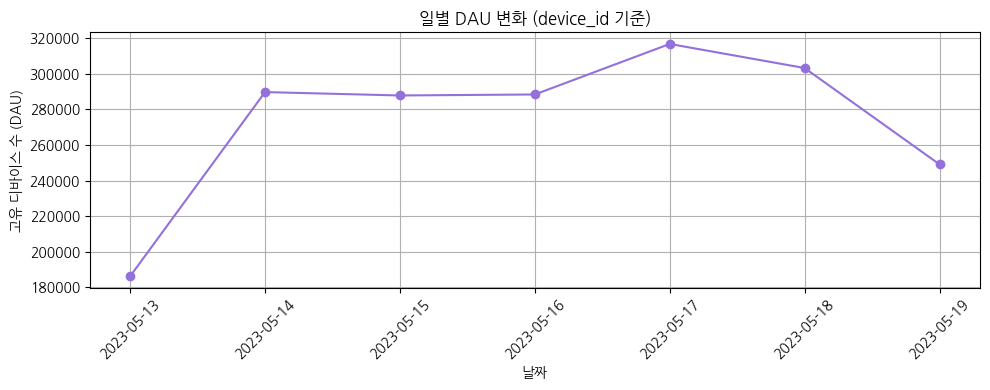

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(dau_df2['date'], dau_df2['DAU'], marker='o', color='mediumpurple')
plt.title("ÏùºÎ≥Ñ DAU Î≥ÄÌôî (device_id Í∏∞Ï§Ä)")
plt.xlabel("ÎÇ†Ïßú")
plt.ylabel("Í≥†Ïú† ÎîîÎ∞îÏù¥Ïä§ Ïàò (DAU)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ÏÑ∏ÏÖò

In [5]:
# session_start, session_endÎßå ÌïÑÌÑ∞ÎßÅ
session_df2 = hackle_df2_cleaned[hackle_df2_cleaned['event_key'].isin(['$session_start', '$session_end'])].copy()


In [6]:
# ÏÑ∏ÏÖò Î∂ÑÏÑùÏùÑ ÏúÑÌï¥ Ï†ïÎ†¨
session_df2 = session_df2.sort_values(by=['device_id', 'timestamp_kst'])

In [7]:
# session_startÎßå Ï∂îÏ∂ú
session_start_df2 = session_df2[session_df2['event_key'] == '$session_start'].copy()
session_start_df2 = session_start_df2.rename(columns={'timestamp_kst': 'start_time'})

# session_endÎßå Ï∂îÏ∂ú
session_end_df2 = session_df2[session_df2['event_key'] == '$session_end'].copy()
session_end_df2 = session_end_df2.rename(columns={'timestamp_kst': 'end_time'})

# ÏÑ∏ÏÖò ID Í∏∞Ï§Ä Î≥ëÌï©
merged_session_df2 = pd.merge(session_start_df2[['session_id', 'device_id', 'start_time']],
                              session_end_df2[['session_id', 'end_time']],
                              on='session_id',
                              how='inner')

# ÏÑ∏ÏÖò Í∏∏Ïù¥ Í≥ÑÏÇ∞
merged_session_df2['duration_sec'] = (merged_session_df2['end_time'] - merged_session_df2['start_time']).dt.total_seconds()


: 

In [1]:
hackle_df3 = pd.read_parquet("/home/sprintda05/final/hackle/2023-05-18.parquet")

NameError: name 'pd' is not defined

In [3]:
hackle_df3 

Asia/Seoul       event_key  \
0        2023-05-19T00:00:00.033Z  $session_start   
1        2023-05-19T00:00:00.038Z    $session_end   
2        2023-05-19T00:00:00.068Z  $session_start   
3        2023-05-19T00:00:00.087Z  $session_start   
4        2023-05-19T00:00:00.102Z  $session_start   
...                           ...             ...   
8224551  2023-05-24T23:59:59.711Z  $session_start   
8224552  2023-05-24T23:59:59.798Z  $session_start   
8224553  2023-05-24T23:59:59.808Z  $session_start   
8224554  2023-05-24T23:59:59.853Z  $session_start   
8224555  2023-05-24T23:59:59.993Z  $session_start   

                                   session_id user_id  value user_properties  \
0                nALWgF7izudSzKXArsiAOaYYsr23    None    0.0              []   
1        E9A0131C-A70A-4917-88D8-257223F0A767    None    0.0              []   
2                euhK4oLwdGPVT6sPNNN1Rs7xEKz1    None    0.0              []   
3                TYAFQPAWozbqfQ3I296QuXJnWrx1    None    0.0              []   
4                XhhuxAQvEcXdlD1JjbPC8H3AF602    None    0.0              []   
...                                       ...     ...    ...             ...   
8224551          E7GRJH6M6HO5tk23McYZ3OOfKEw2    None    0.0              []   
8224552          MiQwwQpYfrMe2LNKZCmBQ6W2JuJ2    None    0.0              []   
8224553  5743e913-4f88-468a-8a9e-a92914c5c74b    None    0.0              []   
8224554          lHkHpfN8twZxOWKFkfcDPrfwO842    None    0.0              []   
8224555          1vNBSPlAgXVXnETkYnluiuCORLY2    None    0.0              []   

                                         hackle_properties  \
0        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
1        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
4        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
...                                                    ...   
8224551  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
8224552  {'language': 'ko', 'isapp': 'true', 'osversion...   
8224553  {'language': 'ko', 'isapp': 'true', 'osversion...   
8224554  {'language': 'en-KR', 'isapp': 'true', 'osvers...   
8224555  {'language': 'ko', 'isapp': 'true', 'osversion...   

                                event_properties  \
0        {'sessionid': '1684422000033.4a700b18'}   
1        {'sessionid': '1684421975647.1dc71535'}   
2        {'sessionid': '1684422000068.2f677e10'}   
3        {'sessionid': '1684422000087.caece7d8'}   
4        {'sessionid': '1684422000102.f169ebee'}   
...                                          ...   
8224551  {'sessionid': '1684940399711.984f2fc5'}   
8224552  {'sessionid': '1684940399798.def42a97'}   
8224553  {'sessionid': '1684940399808.0ead28b2'}   
8224554  {'sessionid': '1684940399853.f6e2f6bb'}   
8224555  {'sessionid': '1684940399993.825e8c9f'}   

                                           id  \
0        6fca7599-9f28-4cc1-9345-f97622e4b4fa   
1        2446011e-cad8-4a3b-9f5e-be8a0cad502f   
2        9d7899af-f7b5-4620-89b6-b5f1c5a6e3f1   
3        e5bb81b9-d29d-4a31-9157-3e91ee53f7ff   
4        8d10a9bb-6929-4e69-98fe-6f59dfcbd96a   
...                                       ...   
8224551  a2f9881d-d32c-45c7-8f84-8d7f617aa4d1   
8224552  601b7779-2a14-437e-b419-b43bd4adbc51   
8224553  0d0a99b7-c72d-4247-ab42-e6510d9a741d   
8224554  55f32b0d-09e5-4d13-9adf-91750e576b57   
8224555  2dd1ff38-ee84-4bba-a8d5-3cb3cd41c518   

                                    device_id  
0        c370e36d-b84c-4c97-af37-db356caf1741  
1        e9a0131c-a70a-4917-88d8-257223f0a767  
2        2ab9b1b1-41a7-4f6e-af31-85daac4509ea  
3        c3236b64-a328-4743-8afd-461f85f1f1e0  
4        efe3418d-ad59-4a20-a5f9-43d2195d1a08  
...                                       ...  
8224551  59312777-cce8-4d42-b204-de38186e6a3a  
8224552  dc91ad73-f676-428d-a5d1-997aaf08fb0a  
8224553  5743e913-4f88-468a-8a9e-a

In [4]:
hackle_df3.isnull().sum()

Asia/Seoul                 0
event_key                  0
session_id                 0
user_id              8224556
value                      0
user_properties            0
hackle_properties          0
event_properties           0
id                         0
device_id                  0
dtype: int64

In [5]:
hackle_df3["event_key"].nunique()

2

In [6]:
hackle_df3["event_key"]

0          $session_start
1            $session_end
2          $session_start
3          $session_start
4          $session_start
                ...      
8224551    $session_start
8224552    $session_start
8224553    $session_start
8224554    $session_start
8224555    $session_start
Name: event_key, Length: 8224556, dtype: object

In [4]:
hackle_df4 = pd.read_parquet("/home/sprintda05/final/hackle/2023-05-24.parquet")

In [8]:
hackle_df4 

Asia/Seoul       event_key  \
0        2023-05-25T00:00:00.219Z  $session_start   
1        2023-05-25T00:00:00.224Z  $session_start   
2        2023-05-25T00:00:00.275Z  $session_start   
3        2023-05-25T00:00:00.369Z  $session_start   
4        2023-05-25T00:00:00.493Z  $session_start   
...                           ...             ...   
2586323  2023-05-30T23:52:53.601Z  $session_start   
2586324  2023-05-30T23:53:02.743Z  $session_start   
2586325  2023-05-30T23:53:48.508Z  $session_start   
2586326  2023-05-30T23:54:24.437Z  $session_start   
2586327  2023-05-30T23:56:42.211Z  $session_start   

                                   session_id user_id  value user_properties  \
0                TeeVVRGrpuXE5q6f7pAu9ULVNvG3    None    0.0              []   
1                9tcpOeHvyldCUXMgRyFVQI86rf13    None    0.0              []   
2                aiDrtN8uHiQXRXmLMJhf27hKA4B3    None    0.0              []   
3                Oqmt3cCrCQZAa0TT3B4s2kTOG1k1    None    0.0              []   
4                GA1Nz2ehK2TmsRcqBzXQn6hkDHH2    None    0.0              []   
...                                       ...     ...    ...             ...   
2586323  84C9D6E4-94AF-498A-9B6A-1AEB7935F43E    None    0.0              []   
2586324          xPstDUYkLncLOIVVd3BeYfhaLxo2    None    0.0              []   
2586325          yGciWUH7Pwam5VWWA93e0bsJH8Z2    None    0.0              []   
2586326          hDik7sTzWZN7fw0tpsnIvjy6Vws1    None    0.0              []   
2586327          GNuQEFmIEjatfVh2flHlW96T30k2    None    0.0              []   

                                         hackle_properties  \
0        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
1        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
4        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
...                                                    ...   
2586323  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2586324  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2586325  {'language': 'ko-GP', 'isapp': 'true', 'osvers...   
2586326  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2586327  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   

                                event_properties  \
0        {'sessionid': '1684940400219.62ee4573'}   
1        {'sessionid': '1684940400224.df939c47'}   
2        {'sessionid': '1684940400275.457b984b'}   
3        {'sessionid': '1684940400369.db2cd3ea'}   
4        {'sessionid': '1684940400493.8e886f45'}   
...                                          ...   
2586323  {'sessionid': '1685458373601.8a533a7e'}   
2586324  {'sessionid': '1685458382743.1652148d'}   
2586325  {'sessionid': '1685458428508.b85147b3'}   
2586326  {'sessionid': '1685458464437.c6ec6bf5'}   
2586327  {'sessionid': '1685458602211.9cf18e2c'}   

                                           id  \
0        75b35f77-565e-47d2-b12e-91848a30b6e4   
1        20a73b83-a331-4d0f-8d96-09ccb796ba4e   
2        eb282c48-17e1-46b7-badd-8a2145901ffe   
3        f466ccc8-f453-4008-b319-47a28ae844f9   
4        a7c5252f-0969-423d-8098-3372c9614a47   
...                                       ...   
2586323  84624cf2-35a8-4c2e-b4a0-ecea9b9e0972   
2586324  c92b6f3d-c891-4963-ba6b-1fb5f49fc2e3   
2586325  5594ec80-afd5-428f-a7bd-986bf974a89d   
2586326  1105c3ba-8fa8-4136-a780-945eeb33c6c0   
2586327  1c0b1454-ee10-41f2-a5c5-e6b2edc8061c   

                                    device_id  
0        b6afceaa-cc9c-4a66-b92f-9e202f9eb328  
1        54a8af4d-47bf-4951-87c2-1817b26d1c31  
2        b08ee1df-0bc6-4b38-9474-8cbc55fd6f17  
3        ace73d0e-04d6-4d03-9460-a0a1143253f7  
4        2adda5ce-1d37-43cd-8cbd-c75c06f84f74  
...                                       ...  
2586323  84c9d6e4-94af-498a-9b6a-1aeb7935f43e  
2586324  cc41e4a4-eec5-4c1c-a011-dfad5f9781d2  
2586325  4e920b46-b2a8-4788-ae81-5

In [9]:
hackle_df4["event_key"].nunique()

1

In [10]:
hackle_df4["event_key"]

0          $session_start
1          $session_start
2          $session_start
3          $session_start
4          $session_start
                ...      
2586323    $session_start
2586324    $session_start
2586325    $session_start
2586326    $session_start
2586327    $session_start
Name: event_key, Length: 2586328, dtype: object

In [5]:
import json

In [6]:
file_path = "/home/sprintda05/final/hackle/2023-05-30.json"

In [7]:
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [8]:
hackle_df5 = pd.DataFrame(data)
hackle_df5.head()

Asia/Seoul                                    id  \
0  2023-05-31T00:01:06.774Z  ea61928e-0642-4765-a5a7-6bf8f573784b   
1  2023-05-31T00:02:20.534Z  773f4cd7-00d1-4b79-bfe6-59788a145d01   
2  2023-05-31T00:02:46.447Z  8998b069-72fe-4a69-9b9c-310e7f631625   
3  2023-05-31T00:03:50.029Z  bcc3c519-7de5-4fd4-a66c-ab348d73de61   
4  2023-05-31T00:04:12.317Z  14b3131e-3c30-4457-a52d-215441d8df1d   

        event_key                            session_id  \
0  $session_start          VAb6ai91iKPZZQhGKenhHZpAG5B2   
1  $session_start  fe556647-de19-43ff-9152-b3c38a8b4d26   
2  $session_start          LsAqqCTVtQPpevfSHXI8oRepVs73   
3  $session_start          NBfi1jm5FKfB6We7YfVRHFgeJY83   
4  $session_start  3CBFC179-1BB1-40A2-84EF-C39EFBD40C14   

                              device_id user_id  value user_properties  \
0  6DA6A8DC-1E61-4643-963A-ED3D782BE77A    None    0.0              {}   
1  fe556647-de19-43ff-9152-b3c38a8b4d26    None    0.0              {}   
2  5D47D549-EF22-41F3-A0D2-AD9EC1D21A2B    None    0.0              {}   
3  FD419DE8-B3CE-4630-B234-959ADA5F47CF    None    0.0              {}   
4  3CBFC179-1BB1-40A2-84EF-C39EFBD40C14    None    0.0              {}   

                                   hackle_properties  \
0  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
1  {'language': 'ko', 'isapp': 'true', 'osversion...   
2  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
4  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   

                          event_properties  
0  {'sessionid': '1685458866774.78343b3e'}  
1  {'sessionid': '1685458940534.47bbaa49'}  
2  {'sessionid': '1685458966447.17499524'}  
3  {'sessionid': '1685459030029.9ef625ea'}  
4  {'sessionid': '1685459052317.fdf5aa30'}

In [18]:
hackle_df5["event_key"].nunique()

1

In [19]:
hackle_df5["event_key"].count()

2313

In [9]:
file_path1 = "/home/sprintda05/final/hackle/2023-06-05.json"

with open(file_path1, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [10]:
hackle_df6 = pd.DataFrame(data)
hackle_df6.head()

Asia/Seoul                                    id  \
0  2023-06-06T00:01:35.519Z  68f56e0b-4a74-4444-8c99-d5b4e9f41b2b   
1  2023-06-06T00:16:11.790Z  e4572df7-3b39-445b-9653-19ff676cb66c   
2  2023-06-06T00:27:07.180Z  fc00b675-848a-44d9-9a3c-81108214b774   
3  2023-06-06T00:28:38.522Z  b95591f9-9291-40b5-91e6-83491f16566d   
4  2023-06-06T00:44:06.441Z  d64634ec-34eb-4797-b7f8-db16ad1bab76   

        event_key                            session_id  \
0  $session_start  7918DF48-A239-45CE-AC1E-7E2E356454C4   
1  $session_start  02F51978-FDD9-4C66-AE8D-820943E00AEF   
2  $session_start          Ut9JqG0u4RQGihxUY3vjCTGgMIx2   
3  $session_start  92D752F2-E7B9-4C01-892B-C9B3F1416B74   
4  $session_start  47955d3d-b77f-47a6-9d3e-3fcb45a350df   

                              device_id user_id  value user_properties  \
0  7918DF48-A239-45CE-AC1E-7E2E356454C4    None    0.0              {}   
1  02F51978-FDD9-4C66-AE8D-820943E00AEF    None    0.0              {}   
2  E75FFCB7-5AAB-4674-AE34-7A231136C367    None    0.0              {}   
3  92D752F2-E7B9-4C01-892B-C9B3F1416B74    None    0.0              {}   
4  47955d3d-b77f-47a6-9d3e-3fcb45a350df    None    0.0              {}   

                                   hackle_properties event_properties  
0  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               {}  
1  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               {}  
2  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               {}  
3  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               {}  
4  {'language': 'ko', 'isapp': 'true', 'osversion...               {}

In [27]:
hackle_df6["event_key"].nunique()

1

In [28]:
hackle_df6["event_key"].count()

649

In [11]:
file_path2 = "/home/sprintda05/final/hackle/2023-06-11.json"

with open(file_path2, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [12]:
hackle_df7 = pd.DataFrame(data)
hackle_df7.head()

Asia/Seoul                                    id  \
0  2023-06-12T00:00:33.612Z  992ad7ef-4b37-4861-ab6e-845475eed154   
1  2023-06-12T00:10:18.093Z  8b4e52b5-213d-4c47-ad6b-b8cb6fcec039   
2  2023-06-12T00:17:21.980Z  52a8ba1d-d20a-4e55-b9e9-caae524bfc26   
3  2023-06-12T00:21:00.694Z  eeff4d81-8313-4aad-bcce-85dc01e8aac2   
4  2023-06-12T00:22:44.843Z  e7929f29-7f73-41d2-af0a-7e1cff1ff863   

        event_key                            session_id  \
0  $session_start          D25QsxpAUScwZKylPhMZ5GjRzWI3   
1  $session_start          CiBKSEGugUW5yGj62SsXbFUzYTb2   
2  $session_start  CD41A81E-8D5C-4E7A-8289-587AD8C306F5   
3  $session_start          m55IE2zGHIVkRJv19Yzok0xivr03   
4  $session_start  7FB46B64-B405-49C4-9378-8FABA73D4038   

                              device_id user_id  value user_properties  \
0  8A5F41F9-D126-453C-8EA8-E0C2484584E3    None    0.0              {}   
1  A81A2A45-6260-41C6-B81B-071F006D60BD    None    0.0              {}   
2  CD41A81E-8D5C-4E7A-8289-587AD8C306F5    None    0.0              {}   
3  5A92997F-362C-400B-8613-893A2FD6197F    None    0.0              {}   
4  7FB46B64-B405-49C4-9378-8FABA73D4038    None    0.0              {}   

                                   hackle_properties event_properties  
0  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               {}  
1  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               {}  
2  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               {}  
3  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               {}  
4  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               {}

In [29]:
hackle_df7["event_key"].nunique()

1

In [30]:
hackle_df7["event_key"].count()

263

In [1]:
hackle_df8 = pd.read_parquet("/home/sprintda05/final/hackle/2023-06-17.parquet")

NameError: name 'pd' is not defined

In [32]:
hackle_df8 

Asia/Seoul                   event_key  \
0        2023-06-18T00:07:08.014Z              $session_start   
1        2023-06-18T00:07:11.039Z                $session_end   
2        2023-06-18T00:07:34.065Z              $session_start   
3        2023-06-18T01:01:12.503Z              $session_start   
4        2023-06-18T02:30:47.469Z              $session_start   
...                           ...                         ...   
4120149  2023-06-23T23:59:59.811Z                  launch_app   
4120150  2023-06-23T23:59:59.869Z  complete_question_question   
4120151  2023-06-23T23:59:59.874Z        click_question_start   
4120152  2023-06-23T23:59:59.968Z         click_question_open   
4120153  2023-06-23T23:59:59.970Z            view_message_tap   

                                   session_id                       user_id  \
0                5cmi6ko54fPkNcJz6OftyN04nxL2                          None   
1                5cmi6ko54fPkNcJz6OftyN04nxL2                          None   
2                WrOTpJzMF0fUed9MlXQggRmyXbw2                          None   
3                nn7Kppgo3HfNTFkqiDCJsP2aOVI2                          None   
4                WrOTpJzMF0fUed9MlXQggRmyXbw2                          None   
...                                       ...                           ...   
4120149  17ee38c8-ca40-4587-8fec-677dfe1d77fb                          None   
4120150  ABE53DB9-B0AB-4DB5-B877-792F66148876  UxJj7PgTvfN1sXCIZGiSQzN7E6w1   
4120151  2b7ad8fc-88ee-409c-9ac0-01e182be56a8  mNLDRM56CjeiREW9NH8dHObLiTM2   
4120152          N244ztC28Be7LOGWNhPXNaDMWJH3  N244ztC28Be7LOGWNhPXNaDMWJH3   
4120153          QHGOgOTy7ZW0faKv2d61LMpZar13  QHGOgOTy7ZW0faKv2d61LMpZar13   

         value          user_properties  \
0          0.0                       []   
1          0.0                       []   
2          0.0                       []   
3          0.0                       []   
4          0.0                       []   
...        ...                      ...   
4120149    0.0                       []   
4120150    0.0                       []   
4120151    0.0   [(heart_balance, 822)]   
4120152    0.0                       []   
4120153    0.0  [(heart_balance, 1212)]   

                                         hackle_properties  \
0        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
1        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
4        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
...                                                    ...   
4120149  {'language': 'ko', 'isapp': 'true', 'osversion...   
4120150  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
4120151  {'language': 'ko', 'isapp': 'true', 'osversion...   
4120152  {'language': 'ko', 'isapp': 'true', 'osversion...   
4120153  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   

            event_properties                                    id  \
0                         []  1f3ac24a-d224-43d3-b2b7-a4d93329d5bc   
1                         []  9fdcd5e3-c9cf-4d40-821a-2a7ab78f4e74   
2                         []  94373dd4-7638-4b59-8b2c-fb1a62ebb3f0   
3                         []  e002e9b9-5cf6-4f0e-b470-f3a6277d42f6   
4                         []  e1df00c5-b260-4262-8352-7e4b732977a9   
...                      ...                                   ...   
4120149                   []  e98c8b3c-b6a9-4235-87e5-05e751c17dbc   
4120150                   []  76293541-e737-4fd2-b2b0-22afad7054f4   
4120151  [(page_name, home)]  0b0e0806-6896-4028-9f27-0486251cbe87   
4120152                   []  0d50a084-8836-4593-a95b-bde1e9e5142f   
4120153                   []  0a6186cf-4334-46dd-8eb2-0e0860ea618e   

                                    device_id  
0        8b6f9e35-473d-45d7-b8ad-884359609fdd  
1        8b6f9e35-473d-45d7-b8ad-884359609fdd  
2        4ff18855-0de6-4e51-a00c-7cdfe36bfc64 

In [35]:
hackle_df8["event_key"].nunique()

28

In [36]:
hackle_df8["event_key"].count()

4120154

In [39]:
hackle_df8["event_key"].value_counts()

event_key
view_home_tap                 990242
$session_start                427577
view_message_tap              371978
view_questions_tap            349860
launch_app                    301810
view_timeline_tap             297306
$session_end                  256364
click_question_open           210544
skip_question_question        140275
view_profile_tap              133186
click_question_ask            130080
view_friendplus_tap            90192
click_question_start           77050
view_question_question         76456
complete_question_question     54722
click_notice                   42649
click_notice_detail            37486
$properties                    35449
click_question_share           31616
view_login                     21969
view_signup                    21198
view_shop                      10721
click_purchase                  5223
click_profile_ask               4066
click_friend_invite              863
click_autoadd_contact            693
click_invite_friend         

In [27]:
hackle_df8.isnull().sum()

Asia/Seoul                0
event_key                 0
session_id                0
user_id              511078
value                     0
user_properties           0
hackle_properties         0
event_properties          0
id                        0
device_id                 0
dtype: int64

In [ ]:
hackle_df9 = pd.read_parquet("/home/sprintda05/final/hackle/2023-06-23.parquet")

In [ ]:
hackle_df10 = pd.read_parquet("/home/sprintda05/final/hackle/2023-06-29.parquet")

In [5]:
hackle_df11 = pd.read_parquet("/home/sprintda05/final/hackle/2023-07-05.parquet")

In [6]:
hackle_df9

Asia/Seoul               event_key  \
0        2023-06-24T00:00:00.023Z  view_question_question   
1        2023-06-24T00:00:00.064Z       view_timeline_tap   
2        2023-06-24T00:00:00.148Z        view_message_tap   
3        2023-06-24T00:00:00.169Z          $session_start   
4        2023-06-24T00:00:00.174Z           view_home_tap   
...                           ...                     ...   
6820310  2023-06-29T23:59:59.737Z        view_message_tap   
6820311  2023-06-29T23:59:59.838Z           view_home_tap   
6820312  2023-06-29T23:59:59.853Z           view_home_tap   
6820313  2023-06-29T23:59:59.879Z  skip_question_question   
6820314  2023-06-29T23:59:59.991Z     view_friendplus_tap   

                                   session_id                       user_id  \
0        2b7ad8fc-88ee-409c-9ac0-01e182be56a8  mNLDRM56CjeiREW9NH8dHObLiTM2   
1                XjKd6fh3CCfKJxobCxGssTIcoCp1  XjKd6fh3CCfKJxobCxGssTIcoCp1   
2                QepNLzWEkTNvfHSSkhCldJH5eMw2  QepNLzWEkTNvfHSSkhCldJH5eMw2   
3        C03B343F-B566-46BA-9030-8E441B71EC33  WVcHhMtN5uVbI9ZW7OM3iMWeXMl1   
4        C03B343F-B566-46BA-9030-8E441B71EC33  WVcHhMtN5uVbI9ZW7OM3iMWeXMl1   
...                                       ...                           ...   
6820310          tMd9MFQHazbW60EjyWco9Izxwq62  tMd9MFQHazbW60EjyWco9Izxwq62   
6820311  98db3fad-9ca5-405f-8ffc-8b354499e837  XkFy3ECurgYDbjZs7fRfPKie8ne2   
6820312          EFgKyXCPAzV1b6QYsgC8D2jsqA23  EFgKyXCPAzV1b6QYsgC8D2jsqA23   
6820313          6HfNGSadT4aWhTfAYrHev3ttOim2  6HfNGSadT4aWhTfAYrHev3ttOim2   
6820314          GRmszYpQ3JYlHUJCEfhhi6awB6x2  GRmszYpQ3JYlHUJCEfhhi6awB6x2   

         value         user_properties  \
0          0.0  [(heart_balance, 822)]   
1          0.0                      []   
2          0.0                      []   
3          0.0                      []   
4          0.0                      []   
...        ...                     ...   
6820310    0.0                      []   
6820311    0.0                      []   
6820312    0.0                      []   
6820313    0.0                      []   
6820314    0.0                      []   

                                         hackle_properties event_properties  \
0        {'language': 'ko', 'isapp': 'true', 'osversion...               []   
1        {'language': 'ko-KR', 'isapp': 'true', 'osvers...               []   
2        {'language': 'ko-US', 'isapp': 'true', 'osvers...               []   
3        {'language': 'ko-US', 'isapp': 'true', 'osvers...               []   
4        {'language': 'ko-US', 'isapp': 'true', 'osvers...               []   
...                                                    ...              ...   
6820310  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               []   
6820311  {'language': 'ko', 'isapp': 'true', 'osversion...               []   
6820312  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               []   
6820313  {'language': 'ko-KR', 'isapp': 'true', 'osvers...               []   
6820314  {'language': 'ko', 'isapp': 'true', 'osversion...               []   

                                           id  \
0        f13f1761-addc-4076-9d2d-14c6f80903bb   
1        4d28cfc7-3ea1-45fe-aa2b-a564ef7db359   
2        903df3b8-c2dd-4d17-b044-6034ad25adbb   
3        11931083-cc18-4a5a-bcba-a265d6434f8a   
4        f2127c1c-b8b6-42d2-9a46-5953df5f2541   
...                                       ...   
6820310  d08e5c37-c1e4-4661-9ad8-ee633d629bca   
6820311  ff3a437a-f972-40ba-942e-2932dbb81bba   
6820312  f10cc81b-688b-4066-a5e9-07aaf83598a8   
6820313  78727cae-e0ce-42fb-95b0-99590b878e7c   
6820314  5c055832-a4f6-4d96-9f94-ccca1a7a391b   

                                    device_id  
0        2b7ad8fc-88ee-409c-9ac0-01e182be56a8  
1        216d665c-7e79-414d-b9e4-100a9a1d4737  
2        b3de9810-5a82-4192-a69d-a2535307a88f  
3        c03b343f-b566-46ba-9030-8e441b71ec33  
4        c03b343f-b566-46ba-9030-8e441b71ec33  
...       

In [8]:
hackle_df9["event_key"].nunique()

28

In [9]:
hackle_df9["event_key"].count()

6820315

In [10]:
hackle_df9["event_key"].value_counts()

event_key
view_home_tap                 1588230
$session_start                 763483
launch_app                     624915
$session_end                   572026
view_questions_tap             548866
view_message_tap               538908
view_timeline_tap              427873
click_question_open            375059
skip_question_question         271173
view_profile_tap               193873
click_question_start           135637
view_friendplus_tap            135615
view_question_question         134667
complete_question_question     100274
click_question_ask              88560
$properties                     57044
click_notice_detail             55610
click_notice                    54760
click_question_share            52828
view_login                      40452
view_signup                     37555
view_shop                       11340
click_purchase                   4414
click_profile_ask                3944
click_friend_invite              1224
click_autoadd_contact             960
cl

In [24]:
hackle_df9.isnull().sum()

Asia/Seoul                0
event_key                 0
session_id                0
user_id              713619
value                     0
user_properties           0
hackle_properties         0
event_properties          0
id                        0
device_id                 0
dtype: int64

In [19]:
hackle_df10

Asia/Seoul                   event_key  \
0        2023-06-30T00:00:00.027Z                $session_end   
1        2023-06-30T00:00:00.111Z           view_timeline_tap   
2        2023-06-30T00:00:00.133Z         click_question_open   
3        2023-06-30T00:00:00.183Z               view_home_tap   
4        2023-06-30T00:00:00.211Z          view_questions_tap   
...                           ...                         ...   
3839967  2023-07-05T23:59:59.792Z            view_message_tap   
3839968  2023-07-05T23:59:59.804Z  complete_question_question   
3839969  2023-07-05T23:59:59.947Z               view_home_tap   
3839970  2023-07-05T23:59:59.951Z           view_timeline_tap   
3839971  2023-07-05T23:59:59.988Z                 view_signup   

                                   session_id                       user_id  \
0                kaNt4iJwceeJKD9JaQorHufsd9s1  kaNt4iJwceeJKD9JaQorHufsd9s1   
1                FKykiqRYlqbIBV2zfzs5GP1VBd93  FKykiqRYlqbIBV2zfzs5GP1VBd93   
2                5aXHRNZW53ONP3R6IUFZyT0HuVW2  5aXHRNZW53ONP3R6IUFZyT0HuVW2   
3                Cmni80eIOEQ8cnKxZR3wNvuUlYu2  Cmni80eIOEQ8cnKxZR3wNvuUlYu2   
4                3evjuZxKXUThPQjb1aVenDTzbXZ2  3evjuZxKXUThPQjb1aVenDTzbXZ2   
...                                       ...                           ...   
3839967          ATc6VrMRrrYYenvHOjkV8X45EPg1  ATc6VrMRrrYYenvHOjkV8X45EPg1   
3839968  b26d6756-511d-4d9c-90d6-6ca37480cfd6  0P6wJ9YZ9wXsoUWGHwiJNASGP522   
3839969  7694daa5-0870-4afa-8b12-3f46632607e4  10WO2EnKzpfejf81n4Chu2QLxUi2   
3839970          nlBJQw3tdnS7jMqQKikUCYy2iHa2  nlBJQw3tdnS7jMqQKikUCYy2iHa2   
3839971  fcee917a-3193-4b9d-bedb-4f22230fbcb4                          None   

         value user_properties  \
0          0.0              []   
1          0.0              []   
2          0.0              []   
3          0.0              []   
4          0.0              []   
...        ...             ...   
3839967    0.0              []   
3839968    0.0              []   
3839969    0.0              []   
3839970    0.0              []   
3839971    0.0              []   

                                         hackle_properties  \
0        {'language': 'ko', 'isapp': 'true', 'osversion...   
1        {'language': 'ko', 'isapp': 'true', 'osversion...   
2        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3        {'language': 'ko', 'isapp': 'true', 'osversion...   
4        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
...                                                    ...   
3839967  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3839968  {'language': 'ko', 'isapp': 'true', 'osversion...   
3839969  {'language': 'ko', 'isapp': 'true', 'osversion...   
3839970  {'language': 'ko', 'isapp': 'true', 'osversion...   
3839971  {'language': 'ko', 'isapp': 'true', 'osversion...   

           event_properties                                    id  \
0                        []  8857ee93-3cf1-4f99-99c5-7411f60befc4   
1                        []  1f029b7d-3717-441c-ae75-54c5cceae1d7   
2                        []  737f7f50-bb39-4d70-85e6-1a7b594cd087   
3                        []  18686219-c3e8-4283-95a7-f6b79dfcae1c   
4                        []  a3cf0763-1ce9-4925-8ca8-d09b03377a44   
...                     ...                                   ...   
3839967                  []  e3411e28-67cc-4341-96e2-1c6199d7414c   
3839968                  []  fbec526e-bc22-4483-b04b-e147d22bbf8f   
3839969                  []  451fa0c6-6e3c-47b1-bc74-18f764c8eaec   
3839970                  []  d566ec78-d37d-4668-a49b-fb6c702e72ca   
3839971  [(page_name, Ïó∞ÎùΩÏ≤ò)]  38781214-d54c-476d-b9c3-9c7ed7db27b1   

                                    device_id  
0        6a9bbd4a-7427-401c-80b3-6d82161ccb3b  
1        dfea6e11-6022-4bfa-800b-61b87dff0ac1  
2        ebb00523-9d18-445c-97ee-239dd8a68e59  
3        9652674b-57ea-4d32-8f9c-21c11308aaef  
4        40b75183-c3f4-4173-ab6f-9bc64cbc70de  
...             

In [11]:
hackle_df10["event_key"].nunique()

28

In [12]:
hackle_df10["event_key"].count()

3839972

In [13]:
hackle_df10["event_key"].value_counts()

event_key
view_home_tap                 919057
$session_start                407630
launch_app                    365123
view_questions_tap            324666
view_message_tap              303998
$session_end                  272776
view_timeline_tap             241735
click_question_open           222632
skip_question_question        176076
view_profile_tap              110754
click_question_start           83684
view_question_question         83081
view_friendplus_tap            78923
complete_question_question     60660
click_question_ask             34976
click_notice_detail            30142
click_question_share           29101
click_notice                   27824
$properties                    24795
view_login                     16109
view_signup                    15092
view_shop                       5908
click_purchase                  1937
click_profile_ask               1444
click_friend_invite              650
click_autoadd_contact            544
click_invite_friend         

In [20]:
hackle_df10

Asia/Seoul                   event_key  \
0        2023-06-30T00:00:00.027Z                $session_end   
1        2023-06-30T00:00:00.111Z           view_timeline_tap   
2        2023-06-30T00:00:00.133Z         click_question_open   
3        2023-06-30T00:00:00.183Z               view_home_tap   
4        2023-06-30T00:00:00.211Z          view_questions_tap   
...                           ...                         ...   
3839967  2023-07-05T23:59:59.792Z            view_message_tap   
3839968  2023-07-05T23:59:59.804Z  complete_question_question   
3839969  2023-07-05T23:59:59.947Z               view_home_tap   
3839970  2023-07-05T23:59:59.951Z           view_timeline_tap   
3839971  2023-07-05T23:59:59.988Z                 view_signup   

                                   session_id                       user_id  \
0                kaNt4iJwceeJKD9JaQorHufsd9s1  kaNt4iJwceeJKD9JaQorHufsd9s1   
1                FKykiqRYlqbIBV2zfzs5GP1VBd93  FKykiqRYlqbIBV2zfzs5GP1VBd93   
2                5aXHRNZW53ONP3R6IUFZyT0HuVW2  5aXHRNZW53ONP3R6IUFZyT0HuVW2   
3                Cmni80eIOEQ8cnKxZR3wNvuUlYu2  Cmni80eIOEQ8cnKxZR3wNvuUlYu2   
4                3evjuZxKXUThPQjb1aVenDTzbXZ2  3evjuZxKXUThPQjb1aVenDTzbXZ2   
...                                       ...                           ...   
3839967          ATc6VrMRrrYYenvHOjkV8X45EPg1  ATc6VrMRrrYYenvHOjkV8X45EPg1   
3839968  b26d6756-511d-4d9c-90d6-6ca37480cfd6  0P6wJ9YZ9wXsoUWGHwiJNASGP522   
3839969  7694daa5-0870-4afa-8b12-3f46632607e4  10WO2EnKzpfejf81n4Chu2QLxUi2   
3839970          nlBJQw3tdnS7jMqQKikUCYy2iHa2  nlBJQw3tdnS7jMqQKikUCYy2iHa2   
3839971  fcee917a-3193-4b9d-bedb-4f22230fbcb4                          None   

         value user_properties  \
0          0.0              []   
1          0.0              []   
2          0.0              []   
3          0.0              []   
4          0.0              []   
...        ...             ...   
3839967    0.0              []   
3839968    0.0              []   
3839969    0.0              []   
3839970    0.0              []   
3839971    0.0              []   

                                         hackle_properties  \
0        {'language': 'ko', 'isapp': 'true', 'osversion...   
1        {'language': 'ko', 'isapp': 'true', 'osversion...   
2        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3        {'language': 'ko', 'isapp': 'true', 'osversion...   
4        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
...                                                    ...   
3839967  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3839968  {'language': 'ko', 'isapp': 'true', 'osversion...   
3839969  {'language': 'ko', 'isapp': 'true', 'osversion...   
3839970  {'language': 'ko', 'isapp': 'true', 'osversion...   
3839971  {'language': 'ko', 'isapp': 'true', 'osversion...   

           event_properties                                    id  \
0                        []  8857ee93-3cf1-4f99-99c5-7411f60befc4   
1                        []  1f029b7d-3717-441c-ae75-54c5cceae1d7   
2                        []  737f7f50-bb39-4d70-85e6-1a7b594cd087   
3                        []  18686219-c3e8-4283-95a7-f6b79dfcae1c   
4                        []  a3cf0763-1ce9-4925-8ca8-d09b03377a44   
...                     ...                                   ...   
3839967                  []  e3411e28-67cc-4341-96e2-1c6199d7414c   
3839968                  []  fbec526e-bc22-4483-b04b-e147d22bbf8f   
3839969                  []  451fa0c6-6e3c-47b1-bc74-18f764c8eaec   
3839970                  []  d566ec78-d37d-4668-a49b-fb6c702e72ca   
3839971  [(page_name, Ïó∞ÎùΩÏ≤ò)]  38781214-d54c-476d-b9c3-9c7ed7db27b1   

                                    device_id  
0        6a9bbd4a-7427-401c-80b3-6d82161ccb3b  
1        dfea6e11-6022-4bfa-800b-61b87dff0ac1  
2        ebb00523-9d18-445c-97ee-239dd8a68e59  
3        9652674b-57ea-4d32-8f9c-21c11308aaef  
4        40b75183-c3f4-4173-ab6f-9bc64cbc70de  
...             

In [23]:
hackle_df10.isnull().sum()

Asia/Seoul                0
event_key                 0
session_id                0
user_id              235095
value                     0
user_properties           0
hackle_properties         0
event_properties          0
id                        0
device_id                 0
dtype: int64

In [14]:
hackle_df11["event_key"].nunique()

45

In [16]:
hackle_df11["event_key"].count()

2878668

In [18]:
hackle_df11["event_key"].value_counts()

event_key
view_home_tap                        572319
$session_start                       344292
launch_app                           311920
$session_end                         221556
click_question_open                  183015
view_questions_tap                   157063
view_message_tap                     140106
skip_question_question               131762
view_timeline_tap                    112446
$properties                           67048
click_question_start                  65857
click_bottom_navigation_questions     59781
click_bottom_navigation_timeline      55240
view_profile_tap                      52759
click_bottom_navigation_profile       51238
view_question_question                48975
complete_question_question            45335
view_friendplus_tap                   38308
click_notice_detail                   31383
click_question_ask                    28572
click_random_ask_shuffle              26750
click_question_share                  20205
click_appbar_alarm_cen

In [21]:
hackle_df11

Asia/Seoul                        event_key  \
0        2023-07-06T00:00:00.234Z                    view_home_tap   
1        2023-07-06T00:00:00.285Z                   $session_start   
2        2023-07-06T00:00:00.372Z                 view_profile_tap   
3        2023-07-06T00:00:00.397Z                       launch_app   
4        2023-07-06T00:00:00.473Z                   $session_start   
...                           ...                              ...   
2878663  2023-07-11T23:59:59.748Z          click_appbar_chat_rooms   
2878664  2023-07-11T23:59:59.807Z                      $properties   
2878665  2023-07-11T23:59:59.807Z                        view_shop   
2878666  2023-07-11T23:59:59.923Z  click_bottom_navigation_profile   
2878667  2023-07-11T23:59:59.937Z               click_question_ask   

                                   session_id                       user_id  \
0                GCZf2jHnnpSHH7DnviWmLLiG20j1  GCZf2jHnnpSHH7DnviWmLLiG20j1   
1                8PZ7GgUaVXSAGn3lPv2E51lfeir1  8PZ7GgUaVXSAGn3lPv2E51lfeir1   
2                ZeH6snQ1gxWQfRodLFDV6qMMcmG2  ZeH6snQ1gxWQfRodLFDV6qMMcmG2   
3                8PZ7GgUaVXSAGn3lPv2E51lfeir1  8PZ7GgUaVXSAGn3lPv2E51lfeir1   
4                raovhvckyKM8m1X2hKrIja8yIb92  raovhvckyKM8m1X2hKrIja8yIb92   
...                                       ...                           ...   
2878663  b59619fc-e46a-47ae-942f-e158c9cb4219                       1295623   
2878664          5wsqrkVYnibnaB901df37um0dBL2                        929125   
2878665          5wsqrkVYnibnaB901df37um0dBL2                        929125   
2878666          EEJCSDqBhzTFiAG6Hn1NP9ygAPz2                       1455409   
2878667  8e073a92-d5a1-4274-ade1-2b272f6c83d3                       1350765   

         value                                    user_properties  \
0          0.0                                                 []   
1          0.0                                                 []   
2          0.0                                                 []   
3          0.0                                                 []   
4          0.0                                                 []   
...        ...                                                ...   
2878663    0.0  [(school_id, 1196), (is_member, true), (gender...   
2878664    0.0  [(is_member, true), (gender, F), (school_id, 5...   
2878665    0.0  [(is_member, true), (gender, F), (school_id, 5...   
2878666    0.0  [(school_id, 836), (is_member, true), (gender,...   
2878667    0.0  [(school_id, 5109), (is_member, true), (gender...   

                                         hackle_properties  \
0        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
1        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
3        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
4        {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
...                                                    ...   
2878663  {'language': 'ko', 'isapp': 'true', 'osversion...   
2878664  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2878665  {'language': 'ko-KR', 'isapp': 'true', 'osvers...   
2878666  {'language': 'ko', 'isapp': 'true', 'osversion...   
2878667  {'language': 'ko', 'isapp': 'true', 'osversion...   

                          event_properties  \
0                                       []   
1                                       []   
2                                       []   
3                                       []   
4                                       []   
...                                    ...   
2878663                                 []   
2878664  [($set, {"heart_balance":"764"})]   
2878665                                 []   
2878666                                 []   
2878667                [(page_name, home)]   

                                           id  \
0        f0c6f1b5-2c63-4944-9755-f70f8c116829   
1       

In [22]:
hackle_df11.isnull().sum()

Asia/Seoul                0
event_key                 0
session_id                0
user_id              175799
value                     0
user_properties           0
hackle_properties         0
event_properties          0
id                        0
device_id                 0
dtype: int64

In [6]:
hackle_df11['Asia/Seoul'].max()

'2023-07-11T23:59:59.937Z'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
# Îç∞Ïù¥ÌÑ∞ Ìè¥Îçî Í≤ΩÎ°ú 
data_path = "/home/sprintda05/final/parquet"  

# Î™®Îì† parquet ÌååÏùº ÏùΩÍ∏∞
table_dict = {}

for file in os.listdir(data_path):
    if file.endswith(".parquet"):
        table_name = file.replace(".parquet", "")
        table_dict[table_name] = pd.read_parquet(os.path.join(data_path, file))
        print(f"{table_name} Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: {table_dict[table_name].shape}")

accounts_user Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (677085, 16)
accounts_pointhistory Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (2338918, 5)
accounts_userwithdraw Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (70764, 3)
polls_usercandidate Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (4769609, 4)
accounts_blockrecord Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (19482, 5)
accounts_user_contacts Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (5063, 4)
accounts_failpaymenthistory Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (163, 5)
polls_questionpiece Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (1265476, 5)
polls_questionreport Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (51424, 5)
accounts_userquestionrecord Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (1217558, 12)
accounts_paymenthistory Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (95140, 5)
accounts_friendrequest Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (17147175, 6)
accounts_timelinereport Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (208, 6)
accounts_school Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (5951, 4)
accounts_attendance Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (349637, 3)
polls_questionset Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (158384, 6)
accounts_group Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (84515, 4)
event_receipts Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å: (309, 5)
accounts_nearbyschool Î∂àÎü¨Ïò§Í∏∞ ÏôÑÎ£å:

In [4]:
summary = []

for name, df in table_dict.items():
    summary.append({
        "ÌÖåÏù¥Î∏îÎ™Ö": name,
        "Ìñâ Ïàò": df.shape[0],
        "Ïó¥ Ïàò": df.shape[1],
        "Í≤∞Ï∏°Ïπò ÏûàÎäî Ïª¨Îüº Ïàò": df.isnull().any().sum(),
        "ÎåÄÌëú Ïª¨Îüº": list(df.columns[:])  
    })

summary_df = pd.DataFrame(summary).sort_values(by="Ìñâ Ïàò", ascending=False)

summary_df

ÌÖåÏù¥Î∏îÎ™Ö       Ìñâ Ïàò  Ïó¥ Ïàò  Í≤∞Ï∏°Ïπò ÏûàÎäî Ïª¨Îüº Ïàò  \
11       accounts_friendrequest  17147175    6            0   
3           polls_usercandidate   4769609    4            0   
1         accounts_pointhistory   2338918    5            1   
7           polls_questionpiece   1265476    5            0   
9   accounts_userquestionrecord   1217558   12            0   
0                 accounts_user    677085   16            2   
14          accounts_attendance    349637    3            0   
15            polls_questionset    158384    6            0   
10      accounts_paymenthistory     95140    5            0   
16               accounts_group     84515    4            0   
2         accounts_userwithdraw     70764    3            0   
18        accounts_nearbyschool     59500    4            0   
8          polls_questionreport     51424    5            0   
4          accounts_blockrecord     19482    5            0   
13              accounts_school      5951    4            0   
5        accounts_user_contacts      5063    4            0   
20               polls_question      5025    3            0   
17               event_receipts       309    5            0   
12      accounts_timelinereport       208    6            0   
6   accounts_failpaymenthistory       163    5            1   
19                       events         3    6            0   

                                                ÎåÄÌëú Ïª¨Îüº  
11  [id, status, created_at, updated_at, receive_u...  
3        [id, created_at, question_piece_id, user_id]  
1   [id, delta_point, created_at, user_id, user_qu...  
7   [id, is_voted, created_at, question_id, is_ski...  
9   [id, status, created_at, chosen_user_id, quest...  
0   [id, is_superuser, is_staff, gender, point, fr...  
14                [id, attendance_date_list, user_id]  
15  [id, question_piece_id_list, opening_time, sta...  
10   [id, productId, phone_type, created_at, user_id]  
16                  [id, grade, class_num, school_id]  
2                            [id, reason, created_at]  
18        [id, distance, nearby_school_id, school_id]  
8      [id, reason, created_at, question_id, user_id]  
4    [id, reason, created_at, block_user_id, user_id]  
13          [id, address, student_count, school_type]  
5   [id, contacts_count, invite_user_id_list, user...  
20                    [id, question_text, created_at]  
17    [id, created_at, event_id, user_id, plus_point]  
12  [id, reason, created_at, reported_user_id, use...  
6    [id, productId, phone_type, created_at, user_id]  
19  [id, title, plus_point, event_type, is_expired...

In [5]:
from IPython.display import display, HTML

def detailed_eda_html(df, name):
    html = f"<h2 style='color: black;'>{name}</h2>"
    html += f"<p><b>Shape:</b> {df.shape}</p>"
    
    # Ïª¨Îüº Î¶¨Ïä§Ìä∏
    html += "<p><b>Ïª¨Îüº Î¶¨Ïä§Ìä∏:</b></p>"
    html += f"<div style='margin-bottom:10px;'>{df.columns.tolist()}</div>"

    # Í≤∞Ï∏°Ïπò Í∞úÏàò Î∞è ÎπÑÏú®
    null_df = df.isnull().sum().to_frame(name="Í≤∞Ï∏°Ïπò Ïàò")
    null_df["Í≤∞Ï∏°Ïπò ÎπÑÏú®(%)"] = (df.isnull().mean() * 100).round(2)
    html += "<p><b>Í≤∞Ï∏°Ïπò Í∞úÏàò Î∞è ÎπÑÏú®:</b></p>"
    html += null_df.to_html()

    # Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ
    html += "<p><b>Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ:</b></p>"
    html += df.dtypes.to_frame(name="dtype").to_html()

    # Í≥†Ïú†Í∞í Ïàò
    nunique_df = df.nunique().sort_values(ascending=False).to_frame(name="Í≥†Ïú†Í∞í Ïàò")
    html += "<p><b>Í≥†Ïú†Í∞í Ïàò (ÎÇ¥Î¶ºÏ∞®Ïàú):</b></p>"
    html += nunique_df.to_html()

    # Ïà´ÏûêÌòï Í∏∞Ïà†ÌÜµÍ≥Ñ
    html += "<p><b>Ïà´ÏûêÌòï Í∏∞Ïà†ÌÜµÍ≥Ñ:</b></p>"
    html += df.describe(include='number').T.to_html()

    # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞
    html += "<p><b>ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ (ÏÉÅÏúÑ 3Í∞ú):</b></p>"
    html += df.head(3).to_html()

    # Ï∂úÎ†•
    display(HTML(f"""
    <div style='max-height:600px; overflow-y:auto; border:1px solid #ccc; padding:10px; margin-bottom:20px; font-family:sans-serif; font-size:14px;'>
        {html}
    </div>
    """))



In [6]:
for name, df in table_dict.items():
    detailed_eda_html(df, name)

#Ïú†Ï†Ä 

In [7]:
user_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")

In [8]:
# Ìè¨Ïù∏Ìä∏ ÏÉÅÏúÑ Ïú†Ï†Ä Ï§ë Í¥ÄÎ¶¨Ïûê Ïó¨Î∂Ä ÌôïÏù∏
user_df.query("point > 1_000_000")[["id", "point", "is_superuser", "is_staff"]].sort_values(by="point", ascending=False)


id      point  is_superuser  is_staff
12       833041  885000006             0         0
671675  1577938   23115730             0         0
543379  1437875    9988541             0         0
8927     849763    9070657             0         0

In [9]:
def top_outlier_users(df, threshold=1_000_000, top_n=10):
    """
    Ìè¨Ïù∏Ìä∏Í∞Ä threshold Ïù¥ÏÉÅÏù∏ Ïú†Ï†Ä Ï§ë ÏÉÅÏúÑ NÎ™Ö Ï∂úÎ†•
    Í¥ÄÎ¶¨Ïûê(superuser/staff) Ïó¨Î∂Ä Ìè¨Ìï®
    """
    result = (
        df.query(f"point > {threshold}")
        [["id", "point", "is_superuser", "is_staff"]]
        .sort_values(by="point", ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )
    return result


In [10]:
top_outlier_users(user_df, threshold=1_000_000, top_n=10)

id      point  is_superuser  is_staff
0   833041  885000006             0         0
1  1577938   23115730             0         0
2  1437875    9988541             0         0
3   849763    9070657             0         0

In [11]:
# Í¥ÄÎ¶¨Ïûê Ïú†Ï†ÄÎßå ÌïÑÌÑ∞ÎßÅ
admin_users = user_df.query("is_superuser == 1 or is_staff == 1")[["id", "point", "is_superuser", "is_staff"]]
admin_users.sort_values(by="point", ascending=False).reset_index(drop=True)

id  point  is_superuser  is_staff
0   831956    600             1         1
1  1580626    300             1         0
2  1580627    300             0         1
3  1580689      0             0         1

In [12]:
Ïú†Ï†Ä ÌÖåÏù¥Î∏îÏóêÏÑú Î≥¥Ïú† Ìè¨Ïù∏Ìä∏Î•º Î¥§ÏùÑÎïå Ï§ëÍ∞ÑÍ∞íÏù¥ 965Ïù∏Îç∞ 8ÏñµÏùÑ ÎÑòÍ≤å Í∞ÄÏßÄÍ≥† ÏûàÎäî Ïú†Ï†ÄÍ∞Ä ÏûàÏùå 
Í¥ÄÎ¶¨Ïûê Í≥ÑÏ†ïÏù∏Í∞Ä ÌôïÏù∏ Ìï¥Î¥§ÎäîÎç∞ ÏïÑÎãò Í∑∏ÎÉ• Ïù¥ÏÉÅÌïú Ïú†Ï†Ä 

SyntaxError: invalid syntax (2735189098.py, line 1)

In [13]:
pointhistory_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_pointhistory.parquet").copy()

In [14]:
pointhistory_df.sort_values(by="delta_point", ascending=False).head(20)


id  delta_point          created_at  user_id  \
2310959  331514297         1000 2023-06-24 11:03:19  1213990   
2324752  336494312         1000 2023-07-23 08:35:43  1167356   
2326398  337184800         1000 2023-07-29 09:07:37  1307227   
2324685  336487071         1000 2023-07-23 07:51:08  1160581   
2320774  334533784         1000 2023-07-12 08:03:23   856172   
2324703  336490238         1000 2023-07-23 08:05:25  1157292   
2326329  337163190         1000 2023-07-29 03:56:09   883543   
2320706  334502090         1000 2023-07-12 03:04:50   857913   
2320679  334499731         1000 2023-07-12 02:31:47   852140   
2324743  336493691         1000 2023-07-23 08:34:05  1162477   
2324747  336494159         1000 2023-07-23 08:35:16  1165963   
2326301  337141684         1000 2023-07-28 18:15:27   875960   
2331059  338654442         1000 2023-08-21 11:37:33  1190046   
2320622  334482112         1000 2023-07-11 23:09:31   875481   
2324763  336494977         1000 2023-07-23 08:37:22  1167311   
2320620  334475985         1000 2023-07-11 22:36:37   885377   
2326276  337139560         1000 2023-07-28 17:30:33  1119663   
2320613  334467971         1000 2023-07-11 17:49:02   873730   
2324780  336496013         1000 2023-07-23 08:39:31  1159023   
2320593  334467372         1000 2023-07-11 17:29:28   886603   

         user_question_record_id  
2310959                      NaN  
2324752                      NaN  
2326398                      NaN  
2324685                      NaN  
2320774                      NaN  
2324703                      NaN  
2326329                      NaN  
2320706                      NaN  
2320679                      NaN  
2324743                      NaN  
2324747                      NaN  
2326301                      NaN  
2331059                      NaN  
2320622                      NaN  
2324763                      NaN  
2320620                      NaN  
2326276                      NaN  
2320613                      NaN  
2324780                      NaN  
2320593                      NaN

In [ ]:
print(pointhistory_df["user_id"].head())

0    849436
1    849436
2    849436
3    849436
4    849436
Name: user_id, dtype: int64


In [ ]:
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [ ]:
Ìà¨Ìëú

In [ ]:
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet").copy()

In [ ]:
# ÏùëÎãµÎ•† Í¥ÄÎ†® Î≥ÄÏàò Î∂ÑÌè¨ ÏöîÏïΩ
response_summary = {
    "Ï¥ù Ìà¨Ìëú Ïàò": len(userquestion_df),
    "ÏùΩÏùÄ ÎπÑÏú® (has_read == 1)": userquestion_df["has_read"].mean(),
    "ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨ (answer_status)": userquestion_df["answer_status"].value_counts(normalize=True),
    "Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)": userquestion_df["opened_times"].value_counts(normalize=True).sort_index()
}

# ÏùëÎãµÎ•† Ï†ïÎ¶¨Ïö©
summary_df = pd.DataFrame({
    "Ìï≠Î™©": ["ÏùΩÏùÄ ÎπÑÏú®", "ÎØ∏ÎãµÎ≥Ä(N)", "ÎπÑÍ≥µÍ∞ú(P)", "Í≥µÍ∞ú(A)", "Ïó¥Îûå 0Ìöå", "Ïó¥Îûå 1Ìöå", "Ïó¥Îûå 2Ìöå", "Ïó¥Îûå 3Ìöå"],
    "ÎπÑÏú®": [
        response_summary["ÏùΩÏùÄ ÎπÑÏú® (has_read == 1)"],
        response_summary["ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨ (answer_status)"].get("N", 0),
        response_summary["ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨ (answer_status)"].get("P", 0),
        response_summary["ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨ (answer_status)"].get("A", 0),
        response_summary["Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)"].get(0, 0),
        response_summary["Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)"].get(1, 0),
        response_summary["Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)"].get(2, 0),
        response_summary["Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)"].get(3, 0)
    ]
})

print(summary_df)

       Ìï≠Î™©        ÎπÑÏú®
0   ÏùΩÏùÄ ÎπÑÏú®  0.555153
1  ÎØ∏ÎãµÎ≥Ä(N)  0.901749
2  ÎπÑÍ≥µÍ∞ú(P)  0.006460
3   Í≥µÍ∞ú(A)  0.091791
4   Ïó¥Îûå 0Ìöå  0.950177
5   Ïó¥Îûå 1Ìöå  0.038505
6   Ïó¥Îûå 2Ìöå  0.009133
7   Ïó¥Îûå 3Ìöå  0.002185


In [ ]:
mismatch_df = userquestion_df[
    (userquestion_df["has_read"] == 1) & (userquestion_df["opened_times"] == 0)
]

print(f"has_read=1 & opened_times=0Ïù∏ Í≤ΩÏö∞: {len(mismatch_df)}Í±¥")

has_read=1 & opened_times=0Ïù∏ Í≤ΩÏö∞: 618901Í±¥


In [ ]:
# Ïã†Í≥† Í±¥Ïàò Î∂ÑÌè¨
report_summary = userquestion_df["report_count"].value_counts().sort_index()
total_votes = len(userquestion_df)

In [ ]:
# ÏöîÏïΩ ÌÖåÏù¥Î∏î ÏÉùÏÑ±
report_summary_df = pd.DataFrame({
    "Ïã†Í≥† ÌöüÏàò": report_summary.index,
    "Ìà¨Ìëú Ïàò": report_summary.values,
    "ÎπÑÏú®": (report_summary.values / total_votes).round(6)
})

# Ï∂úÎ†•
print(report_summary_df)

   Ïã†Í≥† ÌöüÏàò     Ìà¨Ìëú Ïàò        ÎπÑÏú®
0      0  1217389  0.999861
1      1      147  0.000121
2      2       15  0.000012
3      3        3  0.000002
4      4        1  0.000001
5      5        1  0.000001
6      6        1  0.000001
7     14        1  0.000001


In [ ]:
# chosen_user_id Í∏∞Ï§ÄÏúºÎ°ú Î∞õÏùÄ Ìà¨Ìëú Ïàò ÏßëÍ≥Ñ
chosen_counts_df = userquestion_df["chosen_user_id"].value_counts().reset_index()
chosen_counts_df.columns = ["user_id", "received_votes"]

# Î∂ÑÌè¨ ÌÜµÍ≥Ñ ÌôïÏù∏
print("Ï†ÑÏ≤¥ Ïú†Ï†Ä Ïàò:", chosen_counts_df.shape[0])
print("\n[Ìà¨Ìëú Ïàò Î∂ÑÌè¨ ÏöîÏïΩ]")
print(chosen_counts_df["received_votes"].describe())

# ÏÉÅÏúÑ 10Î™Ö ÌôïÏù∏
print("\n[Ìà¨ÌëúÎ•º Í∞ÄÏû• ÎßéÏù¥ Î∞õÏùÄ Ïú†Ï†Ä Top 10]")
print(chosen_counts_df.head(10))

Ï†ÑÏ≤¥ Ïú†Ï†Ä Ïàò: 15426

[Ìà¨Ìëú Ïàò Î∂ÑÌè¨ ÏöîÏïΩ]
count    15426.000000
mean        78.928951
std        131.426705
min          1.000000
25%          3.000000
50%         15.000000
75%         97.000000
max       1239.000000
Name: received_votes, dtype: float64

[Ìà¨ÌëúÎ•º Í∞ÄÏû• ÎßéÏù¥ Î∞õÏùÄ Ïú†Ï†Ä Top 10]
   user_id  received_votes
0   913265            1239
1  1206668            1054
2  1402487            1049
3  1122686            1042
4   994573             997
5  1017281             997
6  1132932             993
7   873259             971
8  1207784             948
9  1017447             917


In [ ]:
ÏπúÍµ¨ ÏöîÏ≤≠ ÌÖåÏù¥Î∏î

In [5]:
friend_df = pd.read_parquet('/home/sprintda05/final/parquet/accounts_friendrequest.parquet').copy()
userquestion_df = pd.read_parquet('/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet')

In [4]:
# 1. ÏπúÍµ¨ Í¥ÄÍ≥Ñ ÏûàÎäî Ïú†Ï†Ä: ÏπúÍµ¨ ÏöîÏ≤≠ÏùÑ Î≥¥ÎÉàÍ±∞ÎÇò Î∞õÏùÄ Ïú†Ï†Ä ID
friend_user_ids = pd.unique(friend_df[["send_user_id", "receive_user_id"]].values.ravel())


In [6]:
# 2. Ìà¨ÌëúÏóêÏÑú ÏÑ†ÌÉùÎêú Ï†Å ÏûàÎäî Ïú†Ï†Ä
chosen_user_ids = userquestion_df["chosen_user_id"].unique()

In [ ]:
# 3. Ï†ÑÏ≤¥ Ïú†Ï†Ä ID
all_user_ids = user_df["id"].values

In [ ]:
# 4. ÏπúÍµ¨ÎèÑ ÏóÜÍ≥†, ÏÑ†ÌÉùÎêú Ï†ÅÎèÑ ÏóÜÎäî Ïú†Ï†Ä
no_friend_ids = set(all_user_ids) - set(friend_user_ids)
no_vote_ids = set(all_user_ids) - set(chosen_user_ids)
no_friend_and_no_vote_ids = no_friend_ids & no_vote_ids

In [ ]:
# ÏöîÏïΩ Ï∂úÎ†•
result_summary = pd.DataFrame({
    "Íµ¨Î∂Ñ": ["Ï†ÑÏ≤¥ Ïú†Ï†Ä Ïàò", "ÏπúÍµ¨ Ïó∞Í≤∞Îêú Ïú†Ï†Ä Ïàò", "ÏÑ†ÌÉùÎêú Ïú†Ï†Ä Ïàò", "ÏπúÍµ¨ÎèÑ ÏóÜÍ≥† ÏÑ†ÌÉùÎèÑ Ïïà Îêú Ïú†Ï†Ä Ïàò"],
    "Ïú†Ï†Ä Ïàò": [
        len(all_user_ids),
        len(friend_user_ids),
        len(chosen_user_ids),
        len(no_friend_and_no_vote_ids)
    ]
})

print(result_summary)

                    Íµ¨Î∂Ñ    Ïú†Ï†Ä Ïàò
0              Ï†ÑÏ≤¥ Ïú†Ï†Ä Ïàò  677085
1          ÏπúÍµ¨ Ïó∞Í≤∞Îêú Ïú†Ï†Ä Ïàò  673705
2             ÏÑ†ÌÉùÎêú Ïú†Ï†Ä Ïàò   15426
3  ÏπúÍµ¨ÎèÑ ÏóÜÍ≥† ÏÑ†ÌÉùÎèÑ Ïïà Îêú Ïú†Ï†Ä Ïàò    3371


In [ ]:
Ïú†Ï†ÄÍ∞Ä ÏñºÎßàÎÇò Ìà¨ÌëúÌñàÎäîÏßÄ

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet").copy()

# Ïú†Ï†ÄÎ≥Ñ Ìà¨ÌëúÌïú ÌöüÏàò ÏßëÍ≥Ñ (user_id Í∏∞Ï§Ä)
voter_counts_df = userquestion_df["user_id"].value_counts().reset_index()
voter_counts_df.columns = ["user_id", "given_votes"]

# ÌÜµÍ≥Ñ ÏöîÏïΩ
print("\n[Ìà¨ÌëúÎ•º Ìïú Ïú†Ï†Ä Ïàò]", voter_counts_df.shape[0])
print("\n[Ïú†Ï†ÄÎ≥Ñ Ìà¨Ìëú Ïàò ÏöîÏïΩ]")
print(voter_counts_df["given_votes"].describe())

# ÏÉÅÏúÑ Ìà¨ÌëúÏûê 10Î™Ö
print("\n[Ìà¨ÌëúÎ•º Í∞ÄÏû• ÎßéÏù¥ Ìïú Ïú†Ï†Ä Top 10]")
print(voter_counts_df.head(10))


[Ìà¨ÌëúÎ•º Ìïú Ïú†Ï†Ä Ïàò] 4849

[Ïú†Ï†ÄÎ≥Ñ Ìà¨Ìëú Ïàò ÏöîÏïΩ]
count    4849.000000
mean      251.094659
std       229.023228
min         1.000000
25%        93.000000
50%       190.000000
75%       338.000000
max      2786.000000
Name: given_votes, dtype: float64

[Ìà¨ÌëúÎ•º Í∞ÄÏû• ÎßéÏù¥ Ìïú Ïú†Ï†Ä Top 10]
   user_id  given_votes
0   849103         2786
1   876509         1708
2   856042         1701
3  1213990         1695
4  1159163         1656
5  1058255         1544
6  1206529         1544
7   952220         1527
8  1170559         1513
9  1236004         1482


67ÎßåÎ™ÖÏùò ÎåÄÍ∑úÎ™® Ïú†Ï†Ä Ï§ëÏóê Ïã§Ï†úÎ°ú Ìà¨ÌëúÎ•º Ìïú Ïú†Ï†ÄÍ∞Ä 4859Î™Ö? Ïã§Ï†úÎ°ú Ìà¨ÌëúÎ•º Î∞õÏùÄ Ïú†Ï†ÄÎäî 15000Î™Ö Ï†ïÎèÑ 
Ïù¥Í±¥ Î≠ê ÏÜåÍ∑úÎ™® Í≥†Ïù∏Î¨ºÎì§Îßå ÎÜÄÍ≥† ÏûàÎäî Í±∞ Í∞ôÏùÄÎç∞ Ïù¥Îü¨ÎãàÍπå ÎßùÌïòÏßÄ

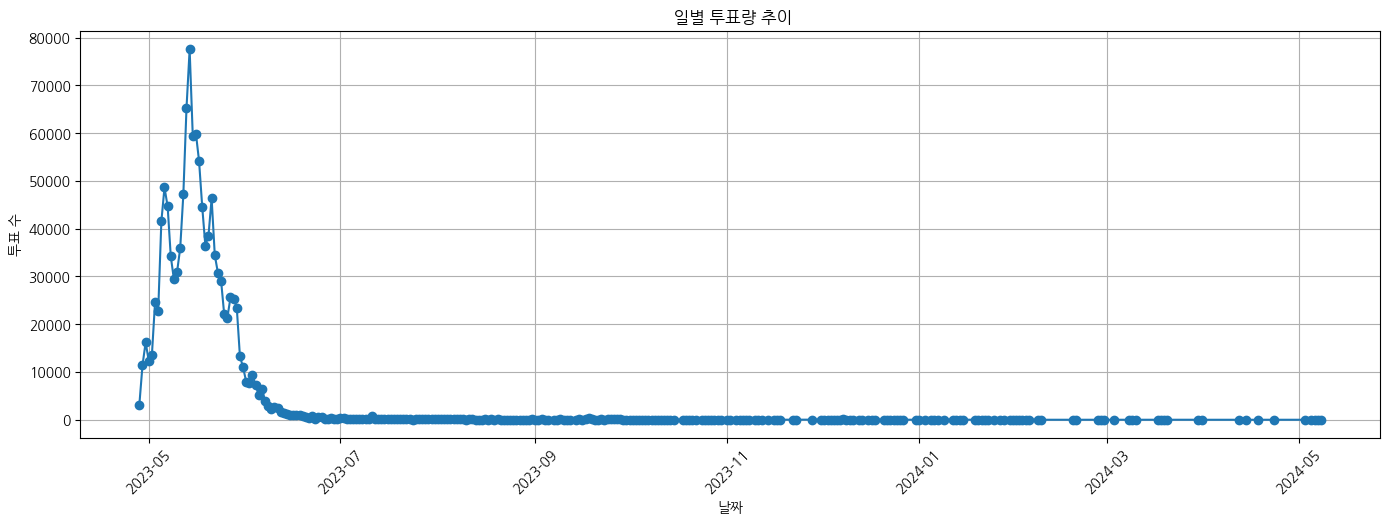

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet").copy()

# created_at Í∏∞Ï§ÄÏúºÎ°ú ÏùºÏûêÎ≥Ñ Ìà¨Ìëú Ïàò ÏßëÍ≥Ñ
daily_votes_df = (
    userquestion_df["created_at"]
    .dt.floor("D")                         # ÎÇ†ÏßúÎ°ú ÎÇ¥Î¶º
    .value_counts()                       # ÎÇ†ÏßúÎ≥Ñ Í∞úÏàò ÏÑ∏Í∏∞
    .sort_index()                         # ÎÇ†Ïßú Ïàú Ï†ïÎ†¨
    .rename_axis("date")
    .reset_index(name="vote_count")
)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(14, 5))
plt.plot(daily_votes_df["date"], daily_votes_df["vote_count"], marker='o', linestyle='-')
plt.title(" ÏùºÎ≥Ñ Ìà¨ÌëúÎüâ Ï∂îÏù¥")
plt.xlabel("ÎÇ†Ïßú")
plt.ylabel("Ìà¨Ìëú Ïàò")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# ÏßàÎ¨∏ 

In [34]:
# ÏßàÎ¨∏ ÌÖçÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
question_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_question.parquet").copy()
questionpiece_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_questionpiece.parquet").copy()
questionreport_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_questionreport.parquet").copy()
questionset_df= pd.read_parquet("/home/sprintda05/final/parquet/polls_questionset.parquet").copy()

In [16]:
# ÏßàÎ¨∏ Ï§ëÎ≥µ Ïó¨Î∂Ä
total_questions = len(question_df)
unique_questions = question_df["question_text"].nunique()
print(f"Ï†ÑÏ≤¥ ÏßàÎ¨∏ Ïàò: {total_questions}, Í≥†Ïú† ÏßàÎ¨∏ Ïàò: {unique_questions}")

Ï†ÑÏ≤¥ ÏßàÎ¨∏ Ïàò: 5025, Í≥†Ïú† ÏßàÎ¨∏ Ïàò: 3903


In [17]:

questionpiece_df["question_id"].value_counts().reset_index()

question_id  count
0             170   2030
1             290   2021
2             169   2017
3             211   2009
4             186   1991
...           ...    ...
4939         4485      1
4940         4730      1
4941         4646      1
4942         4656      1
4943         4352      1

[4944 rows x 2 columns]

In [18]:
top_question_ids = [170, 290, 169, 211, 186]

top_question_texts_df = pd.DataFrame(top_question_ids, columns=["question_id"]).merge(
    question_df, left_on="question_id", right_on="id", how="left"
)[["question_id", "question_text"]]

print(top_question_texts_df)

   question_id                  question_text
0          170  Ï≤òÏùå Î≥¥Îäî ÏÇ¨ÎûåÍ≥º Í∞ÄÏû• Îπ®Î¶¨ ÏπúÌï¥Ïßà Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?
1          290          Î™®Îì† ÏÇ¨ÎûåÍ≥º Ïûò ÏßÄÎÇº Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?
2          169       Ï∂ïÏ†úÏóêÏÑú Í≥µÏó∞ÏùÑ Ï†úÏùº Ïûò Ìï†Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?
3          211    ÏïûÏúºÎ°úÏùò Ïù∏ÏÉùÏùÑ Í∞ÄÏû• Ïû¨ÎØ∏ÏûàÍ≤å ÏÇ¥Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?
4          186                           vote


In [19]:
vote_question_df = question_df[question_df["question_text"].str.lower() == "vote"]

vote_question_count = question_df[question_df["question_text"].str.lower() == "vote"].shape[0]
print(f"'vote'ÎùºÎäî ÏßàÎ¨∏ ÌÖçÏä§Ìä∏Î•º Í∞ÄÏßÑ ÏßàÎ¨∏ Ïàò: {vote_question_count}Í∞ú")

'vote'ÎùºÎäî ÏßàÎ¨∏ ÌÖçÏä§Ìä∏Î•º Í∞ÄÏßÑ ÏßàÎ¨∏ Ïàò: 56Í∞ú


In [20]:
# Ìï¥Îãπ IDÍ∞Ä questionpieceÏóêÏÑú ÏñºÎßàÎÇò ÏûêÏ£º Îì±Ïû•ÌñàÎäîÏßÄ
if not vote_question_df.empty:
    vote_qid = vote_question_df["id"].values[0]
    vote_usage_df = questionpiece_df[questionpiece_df["question_id"] == vote_qid]

    # ÏÇ¨Ïö©, Ìà¨Ìëú, Ïä§ÌÇµ ÏßëÍ≥Ñ
    result = {
        "question_id": vote_qid,
        "question_text": "vote",
        "total_used": len(vote_usage_df),
        "voted_count": vote_usage_df["is_voted"].sum(),
        "skipped_count": vote_usage_df["is_skipped"].sum(),
        "vote_rate": round(vote_usage_df["is_voted"].mean(), 4),
        "skip_rate": round(vote_usage_df["is_skipped"].mean(), 4)
    }
else:
    result = "No question with text 'vote' found."

print(result)


{'question_id': 186, 'question_text': 'vote', 'total_used': 1991, 'voted_count': 1953, 'skipped_count': 3, 'vote_rate': 0.9809, 'skip_rate': 0.0015}


# vote 

In [22]:
# 'vote'ÎùºÎäî ÏßàÎ¨∏ ÌÖçÏä§Ìä∏Î•º Í∞ÄÏßÑ question_id Î™©Î°ù Ï∂îÏ∂ú
vote_qids = question_df[question_df["question_text"].str.lower() == "vote"]["id"].tolist()

print(f"'vote'ÎùºÎäî ÌÖçÏä§Ìä∏Î•º Í∞ÄÏßÑ ÏßàÎ¨∏ Ïàò: {len(vote_qids)}Í∞ú")


'vote'ÎùºÎäî ÌÖçÏä§Ìä∏Î•º Í∞ÄÏßÑ ÏßàÎ¨∏ Ïàò: 56Í∞ú


/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.

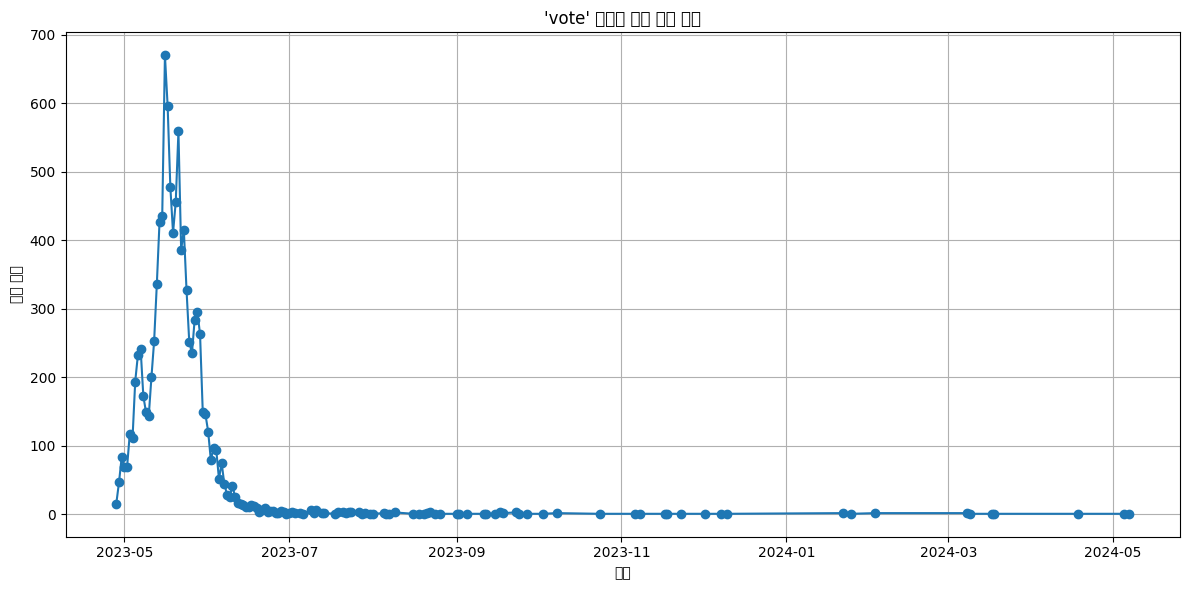

In [23]:
# questionpiece_dfÏóêÏÑú vote ÏßàÎ¨∏Îßå ÌïÑÌÑ∞ÎßÅ
vote_pieces_df = questionpiece_df[questionpiece_df["question_id"].isin(vote_qids)].copy()

# ÎÇ†Ïßú Í∏∞Ï§Ä ÏßëÍ≥Ñ
vote_pieces_df["date"] = vote_pieces_df["created_at"].dt.date
vote_daily_counts = (
    vote_pieces_df.groupby("date")
    .size()
    .reset_index(name="daily_used_count")
)

# ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(vote_daily_counts["date"], vote_daily_counts["daily_used_count"], marker='o')
plt.title("'vote' ÏßàÎ¨∏Ïùò ÏùºÎ≥Ñ ÏÇ¨Ïö© ÌöüÏàò")
plt.xlabel("ÎÇ†Ïßú")
plt.ylabel("ÏÇ¨Ïö© ÌöüÏàò")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.


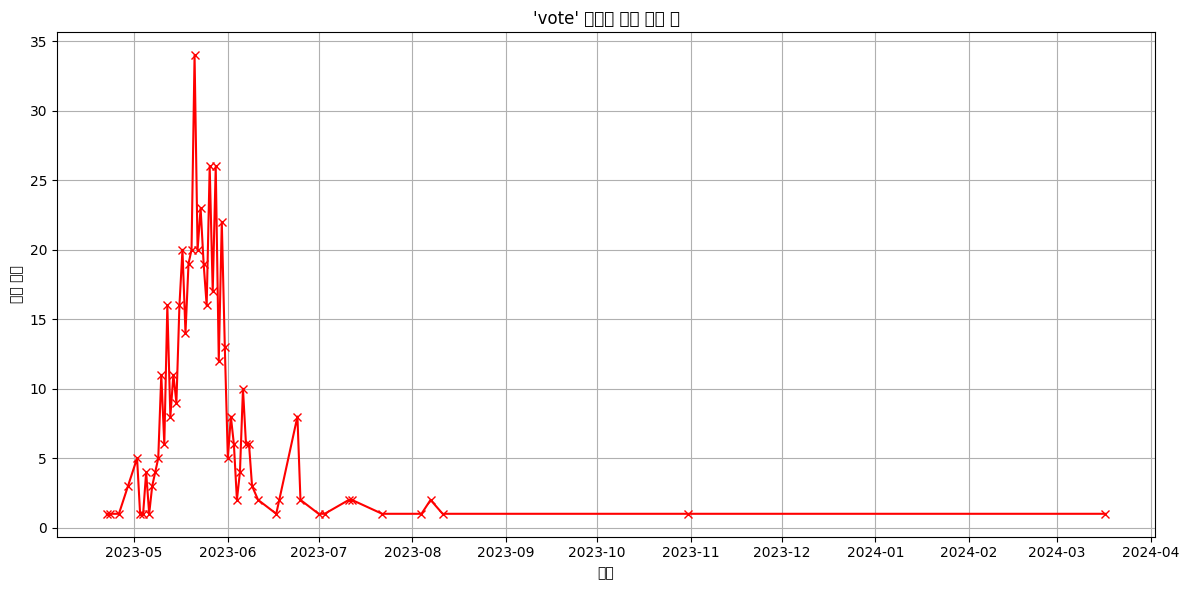

In [25]:
# vote ÏßàÎ¨∏Ïóê ÎåÄÌïú Ïã†Í≥†Îßå Ï∂îÏ∂ú
vote_reports_df = questionreport_df[questionreport_df["question_id"].isin(vote_qids)].copy()

# ÎÇ†Ïßú Í∏∞Ï§Ä Ïã†Í≥† Í±¥Ïàò ÏßëÍ≥Ñ
vote_reports_df["date"] = vote_reports_df["created_at"].dt.date
vote_report_daily = (
    vote_reports_df.groupby("date")
    .size()
    .reset_index(name="daily_report_count")
)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12,6))
plt.plot(vote_report_daily["date"], vote_report_daily["daily_report_count"], color='red', marker='x')
plt.title("'vote' ÏßàÎ¨∏Ïùò ÏùºÎ≥Ñ Ïã†Í≥† Ïàò")
plt.xlabel("ÎÇ†Ïßú")
plt.ylabel("Ïã†Í≥† Í±¥Ïàò")
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
vote_reports_df 

id                reason          created_at  question_id  user_id  \
190      200  Ïñ¥ÎñªÍ≤å Ïù¥Îü∞ ÏÉùÍ∞ÅÏùÑ? Ïù¥ ÏßàÎ¨∏ ÏµúÍ≥†! 2023-04-22 09:04:39          186   840330   
392      408  Ïñ¥ÎñªÍ≤å Ïù¥Îü∞ ÏÉùÍ∞ÅÏùÑ? Ïù¥ ÏßàÎ¨∏ ÏµúÍ≥†! 2023-04-23 13:39:31          186   841050   
612      642                    Í∏∞ÌÉÄ 2023-04-26 04:01:47          186   845438   
952     1006  Ïñ¥ÎñªÍ≤å Ïù¥Îü∞ ÏÉùÍ∞ÅÏùÑ? Ïù¥ ÏßàÎ¨∏ ÏµúÍ≥†! 2023-04-29 10:16:27          186   850129   
1060    1124  Ïñ¥ÎñªÍ≤å Ïù¥Îü∞ ÏÉùÍ∞ÅÏùÑ? Ïù¥ ÏßàÎ¨∏ ÏµúÍ≥†! 2023-04-29 14:59:47          186   845890   
...      ...                   ...                 ...          ...      ...   
50917  55228                 Í∑∏ÎÉ• Ïã´Ïñ¥ 2023-08-07 14:51:42          881  1412887   
50936  55247                 Í∑∏ÎÉ• Ïã´Ïñ¥ 2023-08-07 14:53:20          639  1412887   
50956  55267     ÎÇòÎûë ÎßûÏßÄ ÏïäÎäî ÏßàÎ¨∏Ïù∏ Í≤É Í∞ôÏùå 2023-08-11 05:18:55         4336  1577663   
51229  55573                 Í∑∏ÎÉ• Ïã´Ïñ¥ 2023-10-31 13:11:30          712   928351   
51401  55745                 Í∑∏ÎÉ• Ïã´Ïñ¥ 2024-03-17 07:32:36          940   979775   

             date  
190    2023-04-22  
392    2023-04-23  
612    2023-04-26  
952    2023-04-29  
1060   2023-04-29  
...           ...  
50917  2023-08-07  
50936  2023-08-07  
50956  2023-08-11  
51229  2023-10-31  
51401  2024-03-17  

[486 rows x 6 columns]

In [ ]:
vote_pieces_df

id  is_voted          created_at  question_id  is_skipped  \
86          999061         1 2023-04-28 12:30:30          186           0   
355        1001728         1 2023-04-28 12:37:10          186           0   
595        1006883         1 2023-04-28 12:59:52          186           0   
748        1009852         1 2023-04-28 13:15:03          186           0   
1279       1019049         1 2023-04-28 13:57:38          186           0   
...            ...       ...                 ...          ...         ...   
1265316  208350163         0 2024-03-17 08:25:21         2916           0   
1265332  208351069         0 2024-03-18 14:55:54         2843           0   
1265392  208367887         0 2024-04-18 02:23:30          946           0   
1265432  208383297         0 2024-05-05 14:06:27          712           0   
1265455  208384960         0 2024-05-07 00:15:00         1654           0   

               date  
86       2023-04-28  
355      2023-04-28  
595      2023-04-28  
748      2023-04-28  
1279     2023-04-28  
...             ...  
1265316  2024-03-17  
1265332  2024-03-18  
1265392  2024-04-18  
1265432  2024-05-05  
1265455  2024-05-07  

[10169 rows x 6 columns]

In [27]:
# "vote" ÌÖçÏä§Ìä∏Î•º Í∞ÄÏßÑ ÏßàÎ¨∏ ID Î¶¨Ïä§Ìä∏
vote_question_ids = question_df[question_df["question_text"] == "vote"]["id"].tolist()

In [ ]:
vote_question_ids


[186,
 483,
 639,
 696,
 712,
 725,
 736,
 807,
 881,
 940,
 946,
 1139,
 1219,
 1232,
 1320,
 1507,
 1591,
 1651,
 1652,
 1653,
 1654,
 1655,
 1656,
 1657,
 1658,
 1747,
 1749,
 2129,
 2246,
 2565,
 2843,
 2916,
 3200,
 3216,
 3314,
 3353,
 3367,
 3447,
 3564,
 3566,
 3695,
 3913,
 3915,
 4033,
 4183,
 4199,
 4297,
 4336,
 4350,
 4430,
 4547,
 4549,
 4678,
 4896,
 4898,
 5016]

In [28]:
vote_question_reports_df = questionreport_df[questionreport_df["question_id"].isin(vote_question_ids)].copy()


In [29]:
vote_question_reports_df["reason"].value_counts()

reason
Í∑∏ÎÉ• Ïã´Ïñ¥                   267
ÎÇòÎûë ÎßûÏßÄ ÏïäÎäî ÏßàÎ¨∏Ïù∏ Í≤É Í∞ôÏùå       106
ÏûêÍæ∏ Í∞ôÏùÄ ÎÇ¥Ïö©Ïùò ÏßàÎ¨∏ Î∞òÎ≥µ          45
Î∂àÏæåÌïú ÏßàÎ¨∏ ÎÇ¥Ïö©                35
Ìïú ÏπúÍµ¨Í∞Ä ÏßàÎ¨∏ÏùÑ Î∞òÎ≥µÏ†ÅÏúºÎ°ú Î≥¥ÎÉÑ       16
Ïñ¥ÎñªÍ≤å Ïù¥Îü∞ ÏÉùÍ∞ÅÏùÑ? Ïù¥ ÏßàÎ¨∏ ÏµúÍ≥†!      9
Í∏∞ÌÉÄ                        4
Ïù¥ ÏßàÎ¨∏ÏùÄ Ïû¨ÎØ∏ÏóÜÏñ¥Ïöî               3
Ïò§ÌÉÄÍ∞Ä ÏûàÏùå                    1
Name: count, dtype: int64

In [32]:
import ast

# ÎØ∏Î¶¨ ÌååÏã±Ìï¥ÏÑú ÏÉàÎ°úÏö¥ Ïª¨Îüº ÏÉùÏÑ±
questionset_df["parsed_list"] = questionset_df["question_piece_id_list"].apply(ast.literal_eval)

# vote Ìè¨Ìï® Ïó¨Î∂Ä ÌîåÎûòÍ∑∏ Ïª¨Îüº
questionset_df["has_vote"] = questionset_df["parsed_list"].apply(
    lambda lst: any(qid in vote_question_ids for qid in lst)
)

# ÌïÑÌÑ∞ÎßÅ
vote_questionsets = questionset_df[questionset_df["has_vote"] == True]

# ÎßåÎì† Ïú†Ï†Ä Ïàò ÌôïÏù∏
vote_creators = vote_questionsets["user_id"].value_counts().reset_index()
vote_creators.columns = ["user_id", "vote_question_count"]


In [33]:
vote_creators 

Empty DataFrame
Columns: [user_id, vote_question_count]
Index: []

In [30]:
 questionset_df["question_piece_id_list"]

0         [998458, 998459, 998460, 998461, 998462, 99846...
1         [998588, 998589, 998590, 998591, 998592, 99859...
2         [998689, 998691, 998693, 998695, 998697, 99869...
3         [998688, 998690, 998692, 998694, 998696, 99869...
4         [998768, 998769, 998770, 998771, 998772, 99877...
                                ...                        
158379    [208383291, 208383292, 208383293, 208383294, 2...
158380    [208384201, 208384202, 208384203, 208384204, 2...
158381    [208384951, 208384952, 208384953, 208384954, 2...
158382    [208385211, 208385212, 208385213, 208385214, 2...
158383    [208385221, 208385222, 208385223, 208385224, 2...
Name: question_piece_id_list, Length: 158384, dtype: object

In [37]:
# ÎßåÏïΩ vote_question_idsÍ∞Ä listÎùºÎ©¥, setÏúºÎ°ú Î≥ÄÌôò
vote_question_ids = set(vote_question_ids)

# Ïù¥Ï†ú ÍµêÏßëÌï© Ïó∞ÏÇ∞ Í∞ÄÎä•
valid_vote_ids = vote_question_ids & set(questionpiece_df["question_id"].unique())

print(f"'question_piece_df'Ïóê Ï°¥Ïû¨ÌïòÎäî 'vote' question_id Ïàò: {len(valid_vote_ids)}")


'question_piece_df'Ïóê Ï°¥Ïû¨ÌïòÎäî 'vote' question_id Ïàò: 55


In [38]:
# question_piece_dfÏóêÏÑú vote question_idÏóê Ìï¥ÎãπÌïòÎäî question_piece_id ÎΩëÍ∏∞
vote_piece_ids = set(questionpiece_df[questionpiece_df["question_id"].isin(valid_vote_ids)]["id"])
print(f"Í¥ÄÎ†®Îêú question_piece_id Ïàò: {len(vote_piece_ids)}")


Í¥ÄÎ†®Îêú question_piece_id Ïàò: 10169


In [39]:
import ast

questionset_df["parsed_list"] = questionset_df["question_piece_id_list"].apply(ast.literal_eval)

In [40]:
def contains_vote_piece(lst):
    return any(pid in vote_piece_ids for pid in lst)

questionset_df["has_vote"] = questionset_df["parsed_list"].apply(contains_vote_piece)
vote_questionsets_df = questionset_df[questionset_df["has_vote"] == True]


In [41]:
vote_creators_df = vote_questionsets_df["user_id"].value_counts().reset_index()
vote_creators_df.columns = ["user_id", "vote_question_count"]


In [43]:
print(f"Ï¥ù vote ÏßàÎ¨∏ ÏÑ∏Ìä∏ Ïàò: {vote_questionsets_df.shape[0]}")
display(vote_creators_df)

Ï¥ù vote ÏßàÎ¨∏ ÏÑ∏Ìä∏ Ïàò: 9845


user_id  vote_question_count
0      849103                   23
1     1206529                   20
2     1236004                   20
3     1379402                   18
4     1428542                   18
...       ...                  ...
3404  1207026                    1
3405  1189770                    1
3406   873635                    1
3407  1042187                    1
3408  1087583                    1

[3409 rows x 2 columns]

In [44]:
total_report_count = questionreport_df.shape[0]
vote_report_count = vote_question_reports_df.shape[0]
vote_report_ratio = vote_report_count / total_report_count * 100


In [45]:
total_report_count 

51424

In [46]:
vote_report_count

486

In [47]:
vote_report_ratio

0.9450840074673305

In [ ]:
# hackle ÌÖåÏù¥Î∏î „Ñ±„Ñ±

In [2]:
hackle_events_df = pd.read_parquet("/home/sprintda05/final/hackle/hackle_events.parquet")
hackle_properties_df = pd.read_parquet("/home/sprintda05/final/hackle/hackle_properties.parquet")
device_properties_df = pd.read_parquet("/home/sprintda05/final/hackle/device_properties.parquet")
user_properties_df = pd.read_parquet("/home/sprintda05/final/hackle/user_properties.parquet")

# hackle_events Ïù¥Î≤§Ìä∏ Î°úÍ∑∏ 

In [ ]:
print("‚ñ∂ hackle_events_df")
print(hackle_events_df.shape)
display(hackle_events_df.head())
display(hackle_events_df.info())
print(hackle_events_df.isnull().sum())
print(hackle_events_df['event_key'].value_counts().head(20))

‚ñ∂ hackle_events_df
(11441319, 11)


event_id      event_datetime  \
0  00000533-3f1c-4b3b-81f1-0c8f35754b4e 2023-07-18 19:40:17   
1  00000716-27e9-4e72-a602-d0ce61784b06 2023-07-18 21:07:24   
2  000007c8-68ce-40e6-9b1e-f0e34e8ff9cc 2023-08-06 20:18:03   
3  00000981-5e2a-4111-993e-4f1891ad9a53 2023-08-05 01:46:10   
4  00000a7a-ba72-4332-b4a9-7910670aaeb2 2023-07-24 15:03:37   

                         event_key                            session_id  \
0                   $session_start          4OzYh3seq3VKytpSn5pvQkZNQii1   
1              click_question_open          8QXy31PQxbW9qLzq0Y1dhR8Ypm52   
2  click_bottom_navigation_profile  6bcea65d-9f40-46fc-888c-700fe707483f   
3                        view_shop          XVYNT6zfhFWqIg9omwg2AHDjTLx2   
4      click_bottom_navigation_lab          XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3   

                                     id item_name page_name  friend_count  \
0  00000533-3f1c-4b3b-81f1-0c8f35754b4e                               NaN   
1  00000716-27e9-4e72-a602-d0ce61784b06                              64.0   
2  000007c8-68ce-40e6-9b1e-f0e34e8ff9cc                              26.0   
3  00000981-5e2a-4111-993e-4f1891ad9a53                              61.0   
4  00000a7a-ba72-4332-b4a9-7910670aaeb2                             119.0   

   votes_count  heart_balance  question_id  
0          NaN            NaN          NaN  
1        436.0         4830.0          NaN  
2        174.0         4729.0          NaN  
3         44.0          142.0          NaN  
4        545.0         3287.0          NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB


None

event_id                 0
event_datetime           0
event_key                0
session_id               0
id                       0
item_name                0
page_name                0
friend_count        752556
votes_count         754554
heart_balance       728643
question_id       10991835
dtype: int64
event_key
view_lab_tap                         1266665
view_timeline_tap                    1194508
$session_start                       1036852
launch_app                            986388
click_question_open                   816801
click_bottom_navigation_questions     769163
click_bottom_navigation_profile       653507
$session_end                          649658
click_bottom_navigation_timeline      536051
skip_question                         454981
click_bottom_navigation_lab           453683
view_profile_tap                      413294
view_questions_tap                    353400
click_appbar_alarm_center             253541
click_notice_detail                   229358
click

question_id 10991835Í±¥Ïùò Í≤∞Ï∏°Ïπò 96ÌîÑÎ°ú Ï†ïÎèÑ Í≤∞Ï∏°Ïπò

In [51]:
# Ïù¥Î≤§Ìä∏ Ï¢ÖÎ•òÎ≥Ñ Ïπ¥Ïö¥Ìä∏
event_key_counts = hackle_events_df["event_key"].value_counts()
display(event_key_counts.head(20))

event_key
view_lab_tap                         1266665
view_timeline_tap                    1194508
$session_start                       1036852
launch_app                            986388
click_question_open                   816801
click_bottom_navigation_questions     769163
click_bottom_navigation_profile       653507
$session_end                          649658
click_bottom_navigation_timeline      536051
skip_question                         454981
click_bottom_navigation_lab           453683
view_profile_tap                      413294
view_questions_tap                    353400
click_appbar_alarm_center             253541
click_notice_detail                   229358
click_question_start                  220385
click_random_ask_shuffle              184217
click_attendance                      157737
complete_question                     154105
click_appbar_chat_rooms               148422
Name: count, dtype: int64

event_key view_lab_tap(Ïã§ÌóòÏã§)Ïù¥ 1266665Í±¥ÏúºÎ°ú Í∞ÄÏû• ÎßéÏùÄ Í±¥ÏàòÎ•º Î≥¥Ïó¨Ï§å Ïã§ÌóòÏã§Ïù¥ Î≠îÎç∞? Î¨¥Ïä® Í∏∞Îä•ÏùÑ ÌïòÎäî ÌÉ≠? 

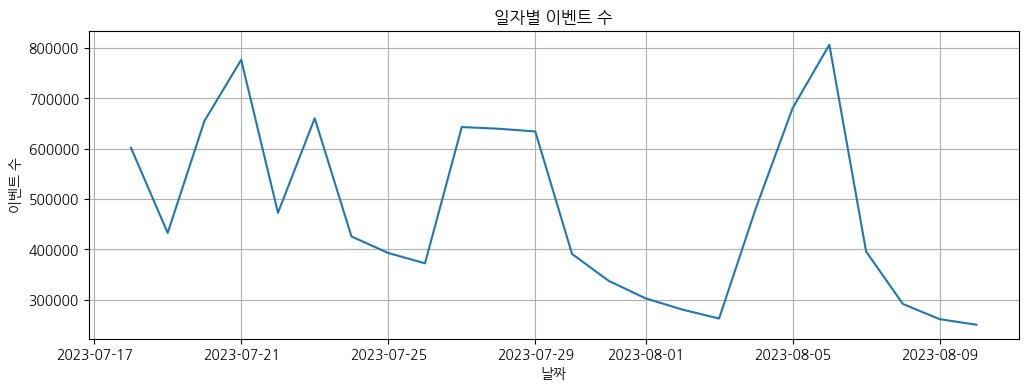

In [54]:
# Ïù¥Î≤§Ìä∏ ÏãúÍ∞Ñ Ï∂îÏ∂ú Î∞è ÏãúÍ≥ÑÏó¥ Î∂ÑÏÑù
hackle_events_df["event_date"] = pd.to_datetime(hackle_events_df["event_datetime"]).dt.date

daily_event_counts = hackle_events_df.groupby("event_date").size()

daily_event_counts.plot(figsize=(12, 4), title="ÏùºÏûêÎ≥Ñ Ïù¥Î≤§Ìä∏ Ïàò")
plt.xlabel("ÎÇ†Ïßú")
plt.ylabel("Ïù¥Î≤§Ìä∏ Ïàò")
plt.grid(True)
plt.show()

In [55]:
hackle_events_df["page_name"].value_counts().head(20)

page_name
           10652540
home         518348
notice       229358
profile       14627
ÌïôÎÖÑÏÑ†ÌÉù          10714
Î∞òÏÑ†ÌÉù            8592
ÌïôÍµêÏÑ†ÌÉù           1904
Î≤àÌò∏Ïù∏Ï¶ù           1246
ÏïÑÏù¥ÎîîÏûÖÎ†•          1072
ÏÑ±Î≥ÑÏÑ†ÌÉù           1057
ÌîÑÏÇ¨ÏÑ§Ï†ï           1020
invite          816
Ïù¥Î¶ÑÏûÖÎ†•             25
Name: count, dtype: int64

In [56]:
hackle_events_df[hackle_events_df["event_key"] == "view_lab_tap"]["page_name"].value_counts()


page_name
    1266665
Name: count, dtype: int64

In [7]:
hackle_events_df['event_datetime'].max()

Timestamp('2023-08-10 23:59:59')

In [8]:
hackle_events_df['event_datetime'].min()

Timestamp('2023-07-18 00:00:00')

event_key
view_lab_tap                         1266665
view_timeline_tap                    1194508
$session_start                       1036852
launch_app                            986388
click_question_open                   816801
click_bottom_navigation_questions     769163
click_bottom_navigation_profile       653507
$session_end                          649658
click_bottom_navigation_timeline      536051
skip_question                         454981
click_bottom_navigation_lab           453683
view_profile_tap                      413294
view_questions_tap                    353400
click_appbar_alarm_center             253541
click_notice_detail                   229358
click_question_start                  220385
click_random_ask_shuffle              184217
click_attendance                      157737
complete_question                     154105
click_appbar_chat_rooms               148422
Name: count, dtype: int64

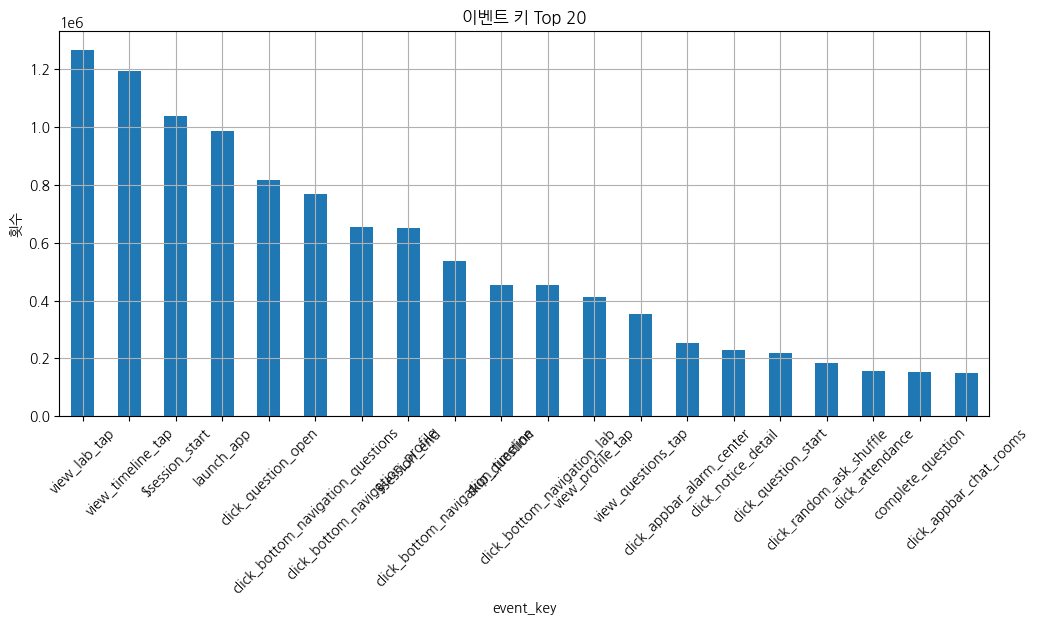

In [17]:
event_counts = hackle_events_df['event_key'].value_counts()

display(event_counts.head(20))
event_counts.head(20).plot(kind='bar', figsize=(12, 5))
plt.title("Ïù¥Î≤§Ìä∏ ÌÇ§ Top 20")
plt.ylabel("ÌöüÏàò")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [18]:
page_counts = hackle_events_df['page_name'].value_counts()
item_counts = hackle_events_df['item_name'].value_counts()

display(page_counts.head(10))
display(item_counts.head(10))

page_name
           10652540
home         518348
notice       229358
profile       14627
ÌïôÎÖÑÏÑ†ÌÉù          10714
Î∞òÏÑ†ÌÉù            8592
ÌïôÍµêÏÑ†ÌÉù           1904
Î≤àÌò∏Ïù∏Ï¶ù           1246
ÏïÑÏù¥ÎîîÏûÖÎ†•          1072
ÏÑ±Î≥ÑÏÑ†ÌÉù           1057
Name: count, dtype: int64

item_name
           11428280
Î¨¥Î£åÏ∂©Ï†ÑÏÜå          7617
777 ÌïòÌä∏         3258
1000 ÌïòÌä∏        1112
200 ÌïòÌä∏         1001
4000 ÌïòÌä∏          51
Name: count, dtype: int64

In [19]:
hackle_events_df[['friend_count', 'votes_count', 'heart_balance']].describe()


friend_count   votes_count  heart_balance
count  1.068876e+07  1.068676e+07   1.071268e+07
mean   5.434357e+01  2.572742e+02   1.626929e+04
std    3.350798e+01  2.180682e+02   3.317340e+06
min    0.000000e+00  0.000000e+00   0.000000e+00
25%    3.200000e+01  9.700000e+01   4.340000e+02
50%    4.900000e+01  2.100000e+02   1.249000e+03
75%    7.100000e+01  3.620000e+02   3.188000e+03
max    1.365000e+03  3.017000e+03   8.849998e+08

In [20]:
question_null_rate = hackle_events_df['question_id'].isnull().mean()
print(f"question_id Í≤∞Ï∏° ÎπÑÏú®: {question_null_rate:.2%}")

question_id Í≤∞Ï∏° ÎπÑÏú®: 96.07%


In [21]:
question_events_df = hackle_events_df[hackle_events_df["question_id"].notnull()]


In [29]:
question_events_df["event_key"].nunique()

1

In [30]:
question_events_df["event_key"].value_counts()

event_key
skip_question    449484
Name: count, dtype: int64

In [31]:
question_events_df

event_id      event_datetime  \
10        00001661-7e46-4e66-8e38-41ac668371eb 2023-07-18 15:41:11   
19        0000243f-8c78-4d5a-a141-8a2cfe2c80f5 2023-08-09 16:04:30   
23        00002743-3e2e-42c5-96ac-7ae15550140b 2023-08-06 19:50:21   
25        00002d55-db63-41dd-ad51-0775f3375507 2023-07-26 22:30:04   
37        0000387a-1db8-42e2-b07f-e25541160418 2023-08-07 18:07:45   
...                                        ...                 ...   
11441174  ffff31c2-2b03-4cbd-842a-5d6d92b2a1c7 2023-07-21 07:25:58   
11441196  ffff4d8a-d518-4118-a203-91a8d83c3cbf 2023-07-31 22:50:55   
11441199  ffff514f-972a-46a8-9175-d6d1464a3f0d 2023-08-09 14:14:25   
11441287  ffffcdc7-a0d0-4c01-a5b3-4386d96c5ea7 2023-07-25 11:08:22   
11441315  fffff57d-6c79-46b3-a87b-4bfa900ef11b 2023-07-23 09:30:22   

              event_key                            session_id  \
10        skip_question          V3LLobUFnpeakqUYgsVUnaWEFoe2   
19        skip_question  65e6274a-bf54-4638-83df-f37b6e6ab31c   
23        skip_question          KqT1MV9g8OhVkpaA2Jj8wrxwHO93   
25        skip_question  7f0fa1b4-41b8-4267-9033-97c741099f10   
37        skip_question          6eDbebJ76BT7AYauychTCvu3Vkl1   
...                 ...                                   ...   
11441174  skip_question          ICK1w7VR9xTsa0rUQfrW2wWsjQd2   
11441196  skip_question  e7bc6f6d-4c3d-427d-b5ca-d98a1f2de071   
11441199  skip_question  cfa76079-ab4e-4ea1-a7df-38ceaa5ef011   
11441287  skip_question          7B0UqHqSLIRsDlUmnCXoxiy2ggq2   
11441315  skip_question  CB3F11FD-4B78-4496-96E7-3B4174C123E9   

                                            id item_name page_name  \
10        00001661-7e46-4e66-8e38-41ac668371eb                       
19        0000243f-8c78-4d5a-a141-8a2cfe2c80f5                       
23        00002743-3e2e-42c5-96ac-7ae15550140b                       
25        00002d55-db63-41dd-ad51-0775f3375507                       
37        0000387a-1db8-42e2-b07f-e25541160418                       
...                                        ...       ...       ...   
11441174  ffff31c2-2b03-4cbd-842a-5d6d92b2a1c7                       
11441196  ffff4d8a-d518-4118-a203-91a8d83c3cbf                       
11441199  ffff514f-972a-46a8-9175-d6d1464a3f0d                       
11441287  ffffcdc7-a0d0-4c01-a5b3-4386d96c5ea7                       
11441315  fffff57d-6c79-46b3-a87b-4bfa900ef11b                       

          friend_count  votes_count  heart_balance  question_id  
10                21.0         71.0         4033.0        817.0  
19                48.0        351.0         1007.0       4863.0  
23                38.0        127.0         2672.0       1194.0  
25                28.0         91.0         2345.0       4189.0  
37               107.0        548.0         5741.0        804.0  
...                ...          ...            ...          ...  
11441174          37.0         93.0          293.0       4438.0  
11441196          40.0       1041.0          196.0       1580.0  
11441199          23.0        265.0        17233.0       4701.0  
11441287         191.0       1526.0        24545.0       4447.0  
11441315           0.0          0.0          300.0        799.0  

[449484 rows x 11 columns]

In [32]:
question_skip_counts = question_events_df["question_id"].value_counts()

In [33]:
question_skip_counts 


question_id
1629.0    403
5051.0    342
4435.0    338
5127.0    334
5039.0    329
         ... 
1226.0     44
1282.0     42
1200.0     42
1479.0     42
625.0      41
Name: count, Length: 3897, dtype: int64

In [36]:
# Í≤∞Ï∏°Ïπò Ï†úÍ±∞
valid_events_df =  hackle_events_df[ hackle_events_df["question_id"].notnull()].copy()

In [38]:
# ÌÉÄÏûÖ ÏùºÏπò
valid_events_df["question_id"] = valid_events_df["question_id"].astype(int)

In [39]:
valid_events_df["question_id"]

10           817
19          4863
23          1194
25          4189
37           804
            ... 
11441174    4438
11441196    1580
11441199    4701
11441287    4447
11441315     799
Name: question_id, Length: 449484, dtype: int64

In [41]:
# Î≥ëÌï©
merged_df = valid_events_df.merge(question_df, left_on="question_id", right_on="id", how="left")

In [66]:
question_df.loc[question_df['id'] == 1237, 'question_text']

1128    ÌôîÌï¥ÌïòÍ≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî?
Name: question_text, dtype: object

In [65]:
question_df.loc[question_df['question_text'] == "ÌôîÌï¥ÌïòÍ≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî?", 'id']

1128    1237
1520    1629
Name: id, dtype: int64

In [67]:
valid_events_df[valid_events_df["question_id"].isin([1237, 1629])]

event_id      event_datetime  \
6103      0023b2c5-8421-46bd-ae7a-704f665c848f 2023-07-31 01:21:45   
67123     0182e677-81ca-4b10-bf73-a75bfee45bfe 2023-07-18 11:04:03   
76768     01b9b7f9-7dae-4ac5-9b5b-0a412a4937f1 2023-07-21 01:52:14   
82969     01dd42fe-e52b-4b4f-8486-eb734439f5ae 2023-08-02 03:00:31   
147010    034af948-831b-4ee1-840d-ab0a5c1917aa 2023-08-09 13:33:47   
...                                        ...                 ...   
11335982  fda235a1-f270-4227-8fd3-2724a0ebac2f 2023-08-07 14:29:07   
11350980  fdf851ce-ceca-47df-9e9a-2d1cfc7a5536 2023-08-05 00:50:53   
11392057  fee3900e-8595-469d-90b7-3478a5a631a3 2023-07-29 00:15:15   
11429325  ffba7ffd-a03c-4d53-b0f0-46e6fea88988 2023-07-25 19:53:58   
11435230  ffdc5caf-f572-4f24-acdb-143025aea414 2023-08-05 11:04:36   

              event_key                            session_id  \
6103      skip_question          NJnt7U1ystY9NN3jQaotS97GP0v2   
67123     skip_question  ab686401-a939-4ba3-9054-f1a979d7ee85   
76768     skip_question  CAB6C502-629A-474C-8130-1D3CBE6A34FA   
82969     skip_question  44018b77-ff8d-4e5c-92e8-b0300100f512   
147010    skip_question          hyqkKSirE2gukxxGhWPY7mySoiy2   
...                 ...                                   ...   
11335982  skip_question  87faeecc-883f-4466-9c61-9fcdbc9ca807   
11350980  skip_question          mz691kH15AdmsLz0RjHDHSiaTQh1   
11392057  skip_question  fa2f733d-a4a2-47d6-931d-a692d828e7a3   
11429325  skip_question  19bf4006-fc4e-4a6d-a6dd-e3675f25ea1e   
11435230  skip_question          Gb1LHzmE8ugl59gR4dTe1bW8FO83   

                                            id item_name page_name  \
6103      0023b2c5-8421-46bd-ae7a-704f665c848f                       
67123     0182e677-81ca-4b10-bf73-a75bfee45bfe                       
76768     01b9b7f9-7dae-4ac5-9b5b-0a412a4937f1                       
82969     01dd42fe-e52b-4b4f-8486-eb734439f5ae                       
147010    034af948-831b-4ee1-840d-ab0a5c1917aa                       
...                                        ...       ...       ...   
11335982  fda235a1-f270-4227-8fd3-2724a0ebac2f                       
11350980  fdf851ce-ceca-47df-9e9a-2d1cfc7a5536                       
11392057  fee3900e-8595-469d-90b7-3478a5a631a3                       
11429325  ffba7ffd-a03c-4d53-b0f0-46e6fea88988                       
11435230  ffdc5caf-f572-4f24-acdb-143025aea414                       

          friend_count  votes_count  heart_balance  question_id  
6103              70.0        146.0         4636.0         1629  
67123             27.0         46.0         3757.0         1629  
76768             57.0        393.0         1135.0         1629  
82969             43.0        105.0         1851.0         1629  
147010            52.0        372.0         4295.0         1629  
...                ...          ...            ...          ...  
11335982          31.0        143.0         2675.0         1629  
11350980          29.0        319.0          442.0         1629  
11392057          65.0         42.0          731.0         1629  
11429325          53.0        290.0         3419.0         1629  
11435230          23.0        196.0         2663.0         1629  

[403 rows x 11 columns]

In [70]:
question_df[question_df["id"].isin([1237, 1629])]

id question_text          created_at
1128  1237  ÌôîÌï¥ÌïòÍ≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî? 2023-05-15 14:02:11
1520  1629  ÌôîÌï¥ÌïòÍ≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî? 2023-05-15 14:04:52

In [42]:
merged_df

event_id      event_datetime  \
0       00001661-7e46-4e66-8e38-41ac668371eb 2023-07-18 15:41:11   
1       0000243f-8c78-4d5a-a141-8a2cfe2c80f5 2023-08-09 16:04:30   
2       00002743-3e2e-42c5-96ac-7ae15550140b 2023-08-06 19:50:21   
3       00002d55-db63-41dd-ad51-0775f3375507 2023-07-26 22:30:04   
4       0000387a-1db8-42e2-b07f-e25541160418 2023-08-07 18:07:45   
...                                      ...                 ...   
449479  ffff31c2-2b03-4cbd-842a-5d6d92b2a1c7 2023-07-21 07:25:58   
449480  ffff4d8a-d518-4118-a203-91a8d83c3cbf 2023-07-31 22:50:55   
449481  ffff514f-972a-46a8-9175-d6d1464a3f0d 2023-08-09 14:14:25   
449482  ffffcdc7-a0d0-4c01-a5b3-4386d96c5ea7 2023-07-25 11:08:22   
449483  fffff57d-6c79-46b3-a87b-4bfa900ef11b 2023-07-23 09:30:22   

            event_key                            session_id  \
0       skip_question          V3LLobUFnpeakqUYgsVUnaWEFoe2   
1       skip_question  65e6274a-bf54-4638-83df-f37b6e6ab31c   
2       skip_question          KqT1MV9g8OhVkpaA2Jj8wrxwHO93   
3       skip_question  7f0fa1b4-41b8-4267-9033-97c741099f10   
4       skip_question          6eDbebJ76BT7AYauychTCvu3Vkl1   
...               ...                                   ...   
449479  skip_question          ICK1w7VR9xTsa0rUQfrW2wWsjQd2   
449480  skip_question  e7bc6f6d-4c3d-427d-b5ca-d98a1f2de071   
449481  skip_question  cfa76079-ab4e-4ea1-a7df-38ceaa5ef011   
449482  skip_question          7B0UqHqSLIRsDlUmnCXoxiy2ggq2   
449483  skip_question  CB3F11FD-4B78-4496-96E7-3B4174C123E9   

                                        id_x item_name page_name  \
0       00001661-7e46-4e66-8e38-41ac668371eb                       
1       0000243f-8c78-4d5a-a141-8a2cfe2c80f5                       
2       00002743-3e2e-42c5-96ac-7ae15550140b                       
3       00002d55-db63-41dd-ad51-0775f3375507                       
4       0000387a-1db8-42e2-b07f-e25541160418                       
...                                      ...       ...       ...   
449479  ffff31c2-2b03-4cbd-842a-5d6d92b2a1c7                       
449480  ffff4d8a-d518-4118-a203-91a8d83c3cbf                       
449481  ffff514f-972a-46a8-9175-d6d1464a3f0d                       
449482  ffffcdc7-a0d0-4c01-a5b3-4386d96c5ea7                       
449483  fffff57d-6c79-46b3-a87b-4bfa900ef11b                       

        friend_count  votes_count  heart_balance  question_id  id_y  \
0               21.0         71.0         4033.0          817   817   
1               48.0        351.0         1007.0         4863  4863   
2               38.0        127.0         2672.0         1194  1194   
3               28.0         91.0         2345.0         4189  4189   
4              107.0        548.0         5741.0          804   804   
...              ...          ...            ...          ...   ...   
449479          37.0         93.0          293.0         4438  4438   
449480          40.0       1041.0          196.0         1580  1580   
449481          23.0        265.0        17233.0         4701  4701   
449482         191.0       1526.0        24545.0         4447  4447   
449483           0.0          0.0          300.0          799   799   

                        question_text          created_at  
0                     Í∞úÍ∑∏ÏΩîÎìúÍ∞Ä Ïûò ÎßûÎäî ÏÇ¨ÎûåÏùÄ? 2023-05-15 13:59:16  
1                        Ï†úÏùº Í≥ÑÎûÄÌòïÏù∏ ÏÇ¨ÎûåÏùÄ? 2023-06-06 06:15:48  
2                      ÎÅàÍ∏∞Í∞Ä Ï†úÏùº Ï¢ãÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-05-15 14:01:53  
3                         ÎáåÍ∞Ä ÏÑπÏãúÌïú ÏÇ¨ÎûåÏùÄ? 2023-06-06 06:15:39  
4       ÎÇ¥ ÏûêÏãùÏùò Î∞∞Ïö∞ÏûêÍ∞Ä ÎêòÎ©¥ Í∞ÄÏû• Ï¢ãÏùÑ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-05-15 13:59:10  
...                               ...                 ...  
449479           Î™©ÏÜåÎ¶¨Ïóê Ïò§ÌÜ†Ìä† ÍπîÎ†§ÏûàÎäîÍ≤É Í∞ôÏùÄ ÏÇ¨Îûå 2023-06-06 06:15:42  
449480           ÌïôÍµê ÎÅùÎÇòÍ≥† Í∞ôÏù¥ ÌïòÍµêÌïòÍ≥† Ïã∂ÏùÄ ÏÇ¨Îûå 2023-05-15 14:04:31  
449481         ÎèôÎ¨ºÏù¥ ÎêúÎã§Î©¥ ÎßêÏù¥ Îê† Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-0

In [48]:
skip_counts = merged_df["question_text"].value_counts()
question_counts = question_df["question_text"].value_counts()
skip_rate = (skip_counts / question_counts).sort_values(ascending=False)

In [68]:
skip_counts

question_text
ÌôîÌï¥ÌïòÍ≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî?                    403
Ï†ÑÌôîÎ•º ÎßéÏù¥ Í±∞Îäî ÏÇ¨ÎûåÏùÄ?                  342
30ÏÇ¥ÍπåÏßÄ Ïï†Ïù∏Ïù¥ ÏïàÏÉùÍ∏∞Î©¥ Í≤∞ÌòºÌïòÍ≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî?     338
ÌïôÍµêÍ∞Ä ÏïÑÎãå Í≥≥ÏóêÏÑú ÎßåÎÇ¨ÏúºÎ©¥ ÏÇ¨Í∑à ÏùòÌñ•Ïù¥ ÏûàÎäî ÏπúÍµ¨    334
ÌîºÏñ¥Ïã±Ïù¥ ÎßéÏùÄ ÏÇ¨ÎûåÏùÄ?                    329
                               ... 
ÏïåÎ∞îÌïòÎ©¥ Ï†úÏùº Ïûò Ìï† Í≤É Í∞ôÏùÄ ÏÇ¨Îûå              44
Ïô∏Í≥ÑÏù∏Í≥ºÎèÑ ÏπúÌïòÍ≤å ÏßÄÎÇº Í≤É Í∞ôÏùÄ ÏπúÍµ¨Îäî?           42
Ï∂§ ÏûòÏ∂úÍ≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?                    42
Í∞êÏÑ±Ï†ÅÏù∏ ÏùåÏïÖÏùÑ Ï¢ãÏïÑÌï† Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?           42
ÏùÄÍ∑º ÏßëÎèåÏù¥ ÏßëÏàúÏù¥Ïùº Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?            41
Name: count, Length: 3897, dtype: int64

In [50]:
question_counts 

question_text
vote                    56
Ïù∏ÏÉù 2ÌöåÏ∞®Ïù∏ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?        3
2ÏÑ∏Í∞Ä Í∞ÄÏû• Í∑ÄÏó¨Ïö∏ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?     3
ÎààÏù¥ Ï†úÏùº ÌÅ∞ ÏÇ¨ÎûåÏùÄ?             3
ÏßÄÍ∏à Î≠êÌïòÎäîÏßÄ Í∂ÅÍ∏àÌïú ÏπúÍµ¨           3
                        ..
Ïû•Í∏∞ÏûêÎûë 1Îì± Ìï† Í≤É Í∞ôÏùÄ ÏπúÍµ¨Îäî?      1
ÌÇ§Í∞Ä Ï†úÏùº ÌÅ¥ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?        1
ÌïúÎ≤àÏØ§ ÏòàÏÅòÎã§Í≥† ÏÉùÍ∞ÅÌï¥Î≥∏ ÏÇ¨ÎûåÏùÄ?       1
Ïù∏Ïä§ÌÉÄ Î∂ÄÍ≥ÑÍ∞Ä Í∞ÄÏû• ÎßõÍπîÎÇòÎäî ÏπúÍµ¨Îäî?     1
Í∞úÌïô ÌïòÏûêÎßàÏûê Ïù∏ÏÇ¨ Îê†Í≤É Í∞ôÏùÄ ÏÇ¨Îûå      1
Name: count, Length: 3903, dtype: int64

In [51]:
skip_rate

question_text
ÏÇ¨Í≥ºÌï† Ïùº ÏûàÎäîÎç∞ Ïó∞ÎùΩ Î™ªÌïòÍ≥† ÏûàÎäî ÏπúÍµ¨                   219.0
ÏÜêÌÜ±Ïóê ÏóÑÏ≤≠ Ïã†Í≤ΩÏì∏ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?                     209.0
ÏÇ¨Ïã§ Ï†ÑÏóê Ïù¥ÏÑ±ÏúºÎ°ú Ï¢ãÏïÑÌñàÎçò ÏÇ¨ÎûåÏùÄ?                     204.0
Ï†ÑÏÉùÏóê ÎàÑÍ∞Ä ÎÑà Ïó¨Ïπú/ÎÇ®ÏπúÏù¥ÏòÄÏùÑ Í≤É Í∞ôÏïÑ?                  203.0
ÌôîÌï¥ÌïòÍ≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî?                             201.5
                                         ...  
ÎÑàÏóêÍ≤å Ïπ≠Ï∞¨ÏùÑ Î∞õÎäîÎã§Î©¥ Í∞ÄÏû• Í∏∞Î∂Ñ Ï¢ãÏùÑ Í≤É Í∞ôÏïÑ!                NaN
ÏÇ¨Îã¨ÎùºÎäîÍ±∞ Îã§ ÏÇ¨Ï§Ñ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?                       NaN
ÏÜêÌÜ±Ïóê ÏóÑÏ≤≠ Ïã†Í≤ΩÏì∏ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?                       NaN
Ìè¨Ïù∏Ìä∏                                        NaN
Ìï†Î®∏Îãà,  Ìï†ÏïÑÎ≤ÑÏßÄÍ∞Ä ÎèºÎèÑ Ïù¥ ÏπúÍµ¨ÎßåÌÅºÏùÄ Ïó∞ÎùΩÌïòÍ≥† ÏßÄÎÇº Í≤É Í∞ôÏïÑ!       NaN
Name: count, Length: 3903, dtype: float64

In [55]:
print(merged_df['question_id'].nunique())     # Í≥†Ïú† ÏßàÎ¨∏ Í∞úÏàò
print(merged_df['question_text'].nunique())   # Í≥†Ïú† ÏßàÎ¨∏ ÌÖçÏä§Ìä∏ Í∞úÏàò

3897
3897


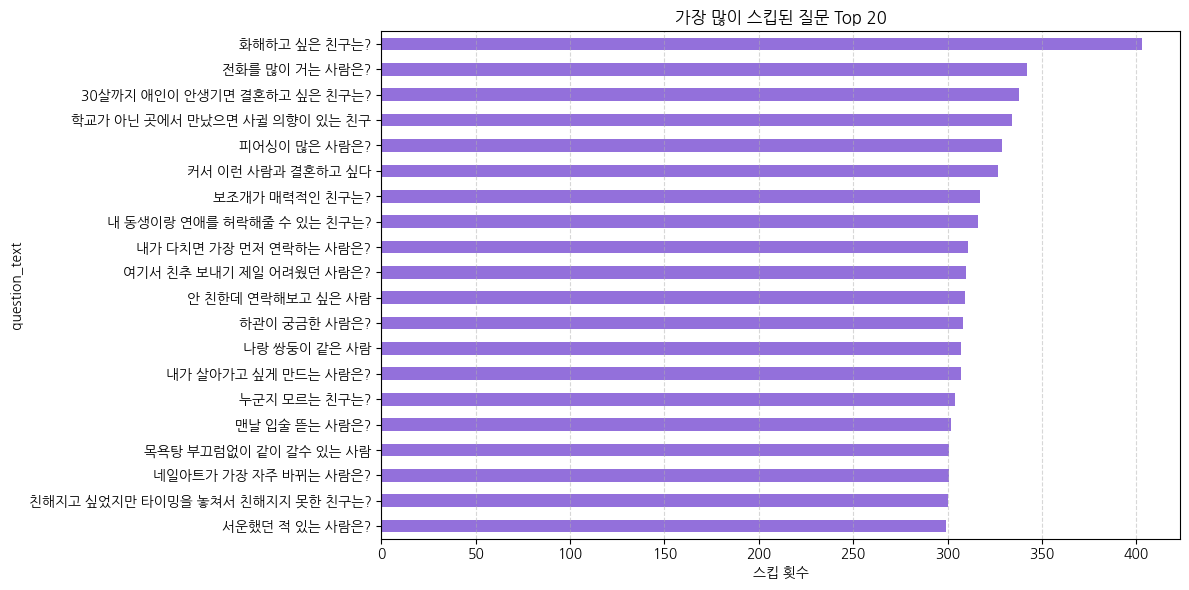

In [56]:
# Ïä§ÌÇµ Ïàò Í∏∞Ï§Ä ÏÉÅÏúÑ ÏßàÎ¨∏ ÏãúÍ∞ÅÌôî (Îã§Ïãú ÌïúÎ≤à Ï†ïÎ¶¨)
skip_counts = merged_df["question_text"].value_counts()
top_skip = skip_counts.head(20)

plt.figure(figsize=(12, 6))
top_skip.plot(kind='barh', color='mediumpurple')
plt.title("Í∞ÄÏû• ÎßéÏù¥ Ïä§ÌÇµÎêú ÏßàÎ¨∏ Top 20")
plt.xlabel("Ïä§ÌÇµ ÌöüÏàò")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# hackle_properties ÏÑ∏ÏÖò Î∞è ÏÇ¨Ïö©Ïûê Ï†ïÎ≥¥

In [14]:
print("‚ñ∂ hackle_properties_df")
print(hackle_properties_df.shape)
display(hackle_properties_df.head())
display(hackle_properties_df.info())
print(hackle_properties_df.isnull().sum())

‚ñ∂ hackle_properties_df
(525350, 8)


id                            session_id  user_id language   osname  \
0   1          4OzYh3seq3VKytpSn5pvQkZNQii1             ko-KR      iOS   
1   2          8QXy31PQxbW9qLzq0Y1dhR8Ypm52  1046711    ko-KR      iOS   
2   3  6bcea65d-9f40-46fc-888c-700fe707483f  1545130       ko  Android   
3   4          XVYNT6zfhFWqIg9omwg2AHDjTLx2  1224793       ko  Android   
4   5          XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3  1329450    ko-US      iOS   

  osversion versionname                             device_id  
0      16.0       2.0.0  590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74  
1    16.5.1       2.0.3  D5417226-F71B-4A9E-A180-CD072F2AB279  
2        13       2.0.5  6bcea65d-9f40-46fc-888c-700fe707483f  
3        13       2.0.5  a05c1595-3e05-434b-8684-218b528bd725  
4    16.5.1       2.0.5  EAC6C0B3-7CE8-40EA-8A91-9977C0BA5EF3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525350 entries, 0 to 525349
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           525350 non-null  int64 
 1   session_id   525350 non-null  object
 2   user_id      525350 non-null  object
 3   language     525350 non-null  object
 4   osname       525350 non-null  object
 5   osversion    525350 non-null  object
 6   versionname  525350 non-null  object
 7   device_id    525350 non-null  object
dtypes: int64(1), object(7)
memory usage: 32.1+ MB


None

id             0
session_id     0
user_id        0
language       0
osname         0
osversion      0
versionname    0
device_id      0
dtype: int64


In [74]:
hackle_properties_df['versionname'].value_counts().head(10)

versionname
2.0.5     309644
2.0.3     157957
2.0.0      39630
1.2.16      7847
1.2.15      7495
1.2.19      2386
1.2.10       293
1.2.8         62
2.0.4         25
1.2.4          3
Name: count, dtype: int64

In [72]:
hackle_properties_df['language'].value_counts()

language
ko-KR    340900
ko       164682
en-KR      9658
ko-US      4931
en         1122
          ...  
en-MW         1
en-AS         1
en-NG         1
en-PH         1
ar-PS         1
Name: count, Length: 151, dtype: int64

In [73]:
hackle_properties_df['osname'].value_counts()

osname
iOS        359479
Android    165871
Name: count, dtype: int64

# device_properties Ïä§ÎßàÌä∏Ìè∞ Ïû•Ïπò Ï†ïÎ≥¥

In [15]:
print("‚ñ∂ device_properties_df")
print(device_properties_df.shape)
display(device_properties_df.head())
display(device_properties_df.info())
print(device_properties_df.isnull().sum())
print(device_properties_df['device_model'].value_counts().head(10))

‚ñ∂ device_properties_df
(252380, 4)


id                             device_id device_model device_vendor
0   1  000007C9-E103-4EB5-9777-A9084D4952DF   iPhone14,7         Apple
1   2  00002245-458F-4CDD-8533-B448CD43DBD2   iPhone14,7         Apple
2   3  00012620-313A-4502-9F8D-8DAB7443215B   iPhone14,5         Apple
3   4  000137bc-80de-4bb5-b61d-df7f217a4501     SM-F711N       samsung
4   5  000227D6-B782-4367-91C4-486B76DF9E37   iPhone12,3         Apple

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252380 entries, 0 to 252379
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             252380 non-null  int64 
 1   device_id      252380 non-null  object
 2   device_model   252380 non-null  object
 3   device_vendor  252380 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.7+ MB


None

id               0
device_id        0
device_model     0
device_vendor    0
dtype: int64
device_model
iPhone14,5    27656
iPhone13,1    18276
iPhone14,7    17891
iPhone14,4    16746
iPhone15,2    14097
iPhone13,2    13792
iPhone14,2    11143
iPhone12,1    10489
iPhone12,8     8120
iPhone13,3     7325
Name: count, dtype: int64


In [75]:
device_properties_df['device_vendor'].value_counts()

device_vendor
Apple            174444
samsung           75887
LGE                1578
Xiaomi              284
OnePlus              49
Google               31
LENOVO               24
Chinoe               19
FYD                   7
motorola              6
Lenovo                5
Nothing               4
Samsung               4
HUAWEI                3
Amazon                3
ZTE                   3
vivo                  3
blackshark            3
Sony                  2
APEX                  2
Teclast               2
incar                 2
asus                  2
Shanling              1
E-dong                1
IMUZ                  1
HXY                   1
Razer                 1
realme                1
Alldocube             1
Teclast_korea         1
bnd                   1
Digital               1
vsmart                1
Foxconn               1
iMUZ                  1
Name: count, dtype: int64

In [76]:
device_properties_df['device_model'].value_counts().head(10)

device_model
iPhone14,5    27656
iPhone13,1    18276
iPhone14,7    17891
iPhone14,4    16746
iPhone15,2    14097
iPhone13,2    13792
iPhone14,2    11143
iPhone12,1    10489
iPhone12,8     8120
iPhone13,3     7325
Name: count, dtype: int64

iPhone ÎπÑÏ§ë Îß§Ïö∞ ÎÜíÏùå
ÏÉÅÏúÑ device_model 10Í∞ú Ï§ë Î™®Îëê iPhone Í≥ÑÏó¥Ïù¥Î©∞, Í∞ÄÏû• ÎßéÏù¥ ÏÇ¨Ïö©Îêú Î™®Îç∏ÏùÄ iPhone14,5, iPhone13,1 Îì±.
‚Üí Apple ÏÇ¨Ïö©Ïûê ÎπÑÏ§ëÏù¥ ÏÉÅÎãπÌûà ÎÜíÏùå ‚Üí ÌÉÄÍ≤ü Ïú†Ï†ÄÏ∏µ Ï∂îÏ†ï Í∞ÄÎä•

device_id Í∏∞Ï§Ä Ï§ëÎ≥µ ÌôïÏù∏
Í∞ôÏùÄ ÎîîÎ∞îÏù¥Ïä§ IDÍ∞Ä Ïó¨Îü¨ Î≤à Îì±Ïû•ÌïòÎäîÏßÄ, ÌïòÎÇòÏùò Ïû•ÏπòÎ•º Ïó¨Îü¨ Î™ÖÏù¥ ÏÇ¨Ïö©ÌñàÎäîÏßÄ ÌôïÏù∏ Í∞ÄÎä•

# user_properties Ïú†Ï†Ä ÏÜçÏÑ± Ï†ïÎ≥¥

In [16]:
print("‚ñ∂ user_properties_df")
print(user_properties_df.shape)
display(user_properties_df.head())
display(user_properties_df.info())
print(user_properties_df.isnull().sum())
print(user_properties_df['grade'].value_counts())

‚ñ∂ user_properties_df
(230819, 5)


user_id  class gender  grade  school_id
0  1000000      1      M      1       1885
1  1000009     10      F      2       3869
2  1000012     10      F      1       5091
3  1000013      8      F      2       1743
4  1000015      2      F      3       5078

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230819 entries, 0 to 230818
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    230819 non-null  object
 1   class      230819 non-null  int64 
 2   gender     230819 non-null  object
 3   grade      230819 non-null  int64 
 4   school_id  230819 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 8.8+ MB


None

user_id      0
class        0
gender       0
grade        0
school_id    0
dtype: int64
grade
2    96778
3    67274
1    66767
Name: count, dtype: int64


Í≤∞Ï∏°ÏπòÍ∞Ä ÏóÜÏùå 
2ÌïôÎÖÑ    96778
3ÌïôÎÖÑ    67274
1ÌïôÎÖÑ    66767

In [78]:
user_properties_df['gender'].value_counts()

gender
F    132610
M     98209
Name: count, dtype: int64

In [79]:
user_properties_df['school_id'].nunique()

5023

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'
import koreanize_matplotlib
from scipy.stats import ttest_ind


In [15]:
votes_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")
df = pd.read_csv("/home/sprintda05/final/cohor_user.csv")
top_bottom_df = pd.read_csv("/home/sprintda05/final/master_table_v6.csv")




In [3]:
# ÎÇ†Ïßú Ï†ïÏ†ú
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.date

votes_df = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] < pd.to_datetime("2023-08-01").date())
].copy()

# Ìï¥Îãπ Í∏∞Í∞Ñ(4/28 ~ 7/31)Ïóê Ìà¨ÌëúÌïú Ïú†Ï†Ä ID
target_user_ids = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] < pd.to_datetime("2023-08-01").date())
]["user_id"].unique()

# school_idÍ∞Ä Ï°¥Ïû¨ÌïòÎäî groupÎßå Ï∂îÏ∂ú
school_df_valid = school_df[school_df["school_id"].notnull()].copy()

# school_idÎ•º Ïú†Ï†ÄÏóêÍ≤å Î∂ôÏù¥Í∏∞ (users ‚Üí school_df)
users_with_school = users_df.merge(
    school_df_valid[["id", "school_id"]],
    left_on="group_id", right_on="id", how="left"
).drop(columns="id_y").rename(columns={"id_x": "user_id"})

# Ìï¥Îãπ Ïú†Ï†Ä Ï§ëÏóêÏÑú ÏúÑ Í∏∞Í∞ÑÏóê Ìà¨ÌëúÌïú Ïú†Ï†ÄÎßå ÌïÑÌÑ∞ÎßÅ
target_users = users_with_school[users_with_school["user_id"].isin(target_user_ids)]

# Ìà¨ÌëúÌïú Ïú†Ï†ÄÍ∞Ä ÏÜåÏÜçÎêú ÌïôÍµê IDÎì§ (Ïú†ÎãàÌÅ¨)
active_school_ids = target_users["school_id"].dropna().unique()
print(" Ìï¥Îãπ Í∏∞Í∞ÑÏóê Ìà¨Ìëú Î∞úÏÉùÌïú ÌïôÍµê Ïàò:", len(active_school_ids))

# Ïù¥ ÌïôÍµê IDÏóê ÏÜçÌïú Ï†ÑÏ≤¥ Ïú†Ï†Ä Ïàò
final_user_count = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].nunique()

print(" Ìï¥Îãπ ÌïôÍµêÏóê ÏÜåÏÜçÎêú Ïú†Ï†Ä Ïàò:", final_user_count)

 Ìï¥Îãπ Í∏∞Í∞ÑÏóê Ìà¨Ìëú Î∞úÏÉùÌïú ÌïôÍµê Ïàò: 10
 Ìï¥Îãπ ÌïôÍµêÏóê ÏÜåÏÜçÎêú Ïú†Ï†Ä Ïàò: 5090


In [4]:
active_school_ids

array([ 271.,  369., 5491.,  352., 4516., 4426., 1478., 5520., 5372.,
       1719.])

In [5]:
# Ìï¥Îãπ ÌïôÍµêÏóê ÏÜçÌïú Ïú†Ï†Ä ID Î™©Î°ù
target_school_user_ids = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].unique()

# Ìï¥Îãπ Ïú†Ï†Ä Ï§ëÏóêÏÑú 4/28 ~ 7/31 Í∏∞Í∞ÑÏóê Ìà¨ÌëúÌïú Ïú†Ï†Ä Ïàò
voted_users_in_target_schools = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] < pd.to_datetime("2023-05-26").date()) &
    (votes_df["user_id"].isin(target_school_user_ids))
]["user_id"].nunique()

print(" Ìï¥Îãπ 10Í∞ú ÌïôÍµê Ïú†Ï†Ä Ï§ë Ïã§Ï†ú Ìà¨ÌëúÌïú Ïú†Ï†Ä Ïàò:", voted_users_in_target_schools)

 Ìï¥Îãπ 10Í∞ú ÌïôÍµê Ïú†Ï†Ä Ï§ë Ïã§Ï†ú Ìà¨ÌëúÌïú Ïú†Ï†Ä Ïàò: 4703


In [6]:
# vote_date ÌååÏã±
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.normalize()

# cohort_day (Ï≤´ Ìà¨ÌëúÏùº) ÏÉùÏÑ±
cohort_df = votes_df.groupby("user_id")["vote_date"].min().reset_index(name="cohort_day")

# ÎåÄÏÉÅ Ïú†Ï†ÄÎßå ÌïÑÌÑ∞ÎßÅ 
votes_filtered_df = votes_df[votes_df["user_id"].isin(target_user_ids)].copy()
votes_filtered_df = votes_filtered_df.merge(cohort_df, on="user_id", how="left")

# active_day Í≥ÑÏÇ∞
votes_filtered_df["active_day"] = (votes_filtered_df["vote_date"] - votes_filtered_df["cohort_day"]).dt.days

# Í∏∞Í∞Ñ ÌïÑÌÑ∞ (cohort_day Í∏∞Ï§Ä 4/28~7/31 ÏÇ¨Ïù¥)
votes_filtered_df = votes_filtered_df[
    (votes_filtered_df["cohort_day"] >= "2023-04-28") &
    (votes_filtered_df["cohort_day"] < "2023-05-26") &
    (votes_filtered_df["active_day"] >= 0)
]

# cohort ÌÅ¨Í∏∞ Í≥ÑÏÇ∞
cohort_size_df = votes_filtered_df.groupby("cohort_day")["user_id"].nunique().reset_index(name="cohort_size")

# active_dayÎ≥Ñ Ïú†ÏßÄ Ïú†Ï†Ä Ïàò
retained_df = votes_filtered_df.groupby(["cohort_day", "active_day"])["user_id"] \
    .nunique().reset_index(name="retained")

# Î¶¨ÌÖêÏÖòÏú® Í≥ÑÏÇ∞
ret_df = retained_df.merge(cohort_size_df, on="cohort_day")
ret_df["rate"] = ret_df["retained"] / ret_df["cohort_size"]


In [7]:
cohort_size_df

cohort_day  cohort_size
0  2023-04-28          125
1  2023-04-29           99
2  2023-04-30          114
3  2023-05-01           36
4  2023-05-02           72
5  2023-05-03          383
6  2023-05-04          167
7  2023-05-05          436
8  2023-05-06          183
9  2023-05-07          105
10 2023-05-08          149
11 2023-05-09          231
12 2023-05-10          173
13 2023-05-11          365
14 2023-05-12          310
15 2023-05-13          377
16 2023-05-14          160
17 2023-05-15          202
18 2023-05-16          119
19 2023-05-17           69
20 2023-05-18           96
21 2023-05-19           57
22 2023-05-20          163
23 2023-05-21          189
24 2023-05-22          137
25 2023-05-23           87
26 2023-05-24           68
27 2023-05-25           31

In [8]:
ret_df

cohort_day  active_day  retained  cohort_size      rate
0    2023-04-28           0       125          125  1.000000
1    2023-04-28           1       122          125  0.976000
2    2023-04-28           2       113          125  0.904000
3    2023-04-28           3       101          125  0.808000
4    2023-04-28           4       113          125  0.904000
...         ...         ...       ...          ...       ...
1639 2023-05-25          23         1           31  0.032258
1640 2023-05-25          25         1           31  0.032258
1641 2023-05-25          30         1           31  0.032258
1642 2023-05-25          39         1           31  0.032258
1643 2023-05-25          44         1           31  0.032258

[1644 rows x 5 columns]

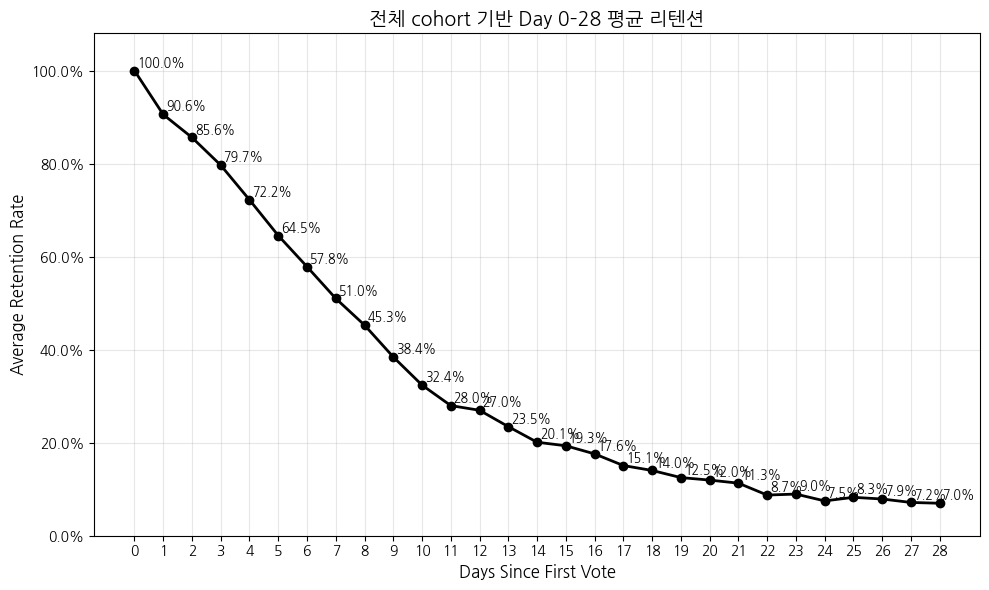

In [9]:
from matplotlib import ticker

# ÌèâÍ∑† Î¶¨ÌÖêÏÖò Í≥ÑÏÇ∞ (Day 0~28)
avg_retention = (
    ret_df[ret_df["active_day"] <= 28]
    .groupby("active_day")["rate"]
    .mean()
    .reset_index()
)

# ÎùºÏù∏ Í∑∏ÎûòÌîÑ 
plt.figure(figsize=(10, 6))
plt.plot(
    avg_retention["active_day"],
    avg_retention["rate"],
    marker="o",
    color="#000000",  #
    linewidth=2,
    label="ÌèâÍ∑† Î¶¨ÌÖêÏÖòÏú®"
)

# Í∞Å Ï†ê ÏúÑÏóê ÏàòÏπò ÌëúÏãú
# ÏàòÏπò ÌëúÏãúÎ•º Ï¢Ä Îçî Î≥¥Í∏∞ Ï¢ãÍ≤å ÎùÑÏõåÏÑú Ï∂îÍ∞Ä
for x, y in zip(avg_retention["active_day"], avg_retention["rate"]):
    plt.text(x + 0.1, y + 0.03, f"{y:.1%}", ha="left", va="top", fontsize=9, color="#000000")



# Î†àÏù¥Î∏î/Í∑∏Î¶¨Îìú/Ìè¨Îß∑ ÏÑ§Ï†ï
plt.xticks(range(0, 29))
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Average Retention Rate", fontsize=12)
plt.title("Ï†ÑÏ≤¥ cohort Í∏∞Î∞ò Day 0‚Äì28 ÌèâÍ∑† Î¶¨ÌÖêÏÖò", fontsize=14)
plt.grid(alpha=0.3)
plt.ylim(0, 1.08)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.tight_layout()
plt.show()

In [9]:
master_df = votes_filtered_df.groupby("user_id").agg(
    total_votes=("question_piece_id", "count"),
    unique_days=("vote_date", "nunique"),
    first_vote=("vote_date", "min"),
    last_vote=("vote_date", "max")
).reset_index()

In [10]:
 # ÌôúÎèô Í∏∞Í∞Ñ
master_df["active_days"] = (master_df["last_vote"] - master_df["first_vote"]).dt.days

# cohort_day Îã§Ïãú Î∂ôÏù¥Í∏∞ (ÎèôÏùºÌïú Í∏∞Ï§Ä Ïú†ÏßÄ)
master_df["cohort_day"] = master_df["first_vote"]

# Day 8 Î¶¨ÌÖêÏÖò Î≥ëÌï© (ÏïûÏóêÏÑú ÎßåÎì† ret_df Í∏∞Ï§Ä)
day8_ret_df = ret_df[ret_df["active_day"] == 8][["cohort_day", "rate"]].rename(columns={"rate": "retention_day8"})
master_df = master_df.merge(day8_ret_df, on="cohort_day", how="left")

In [11]:
print(master_df.head())

   user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0   838023           22            5 2023-04-29 2023-05-04            5   
1   838466          129            7 2023-05-02 2023-06-02           31   
2   838642           10            2 2023-04-28 2023-04-29            1   
3   839357          212            9 2023-04-29 2023-05-26           27   
4   840293          170            7 2023-05-03 2023-05-15           12   

  cohort_day  retention_day8  
0 2023-04-29        0.515152  
1 2023-05-02        0.569444  
2 2023-04-28        0.560000  
3 2023-04-29        0.515152  
4 2023-05-03        0.422977  


In [12]:
cohort_sizes = master_df.groupby("cohort_day")["user_id"].nunique().reset_index()

In [13]:
cohort_sizes['user_id'].sum()

4703

In [14]:
master_df['last_vote'].max()

Timestamp('2023-07-31 00:00:00')

In [15]:
master_df

user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0      838023           22            5 2023-04-29 2023-05-04            5   
1      838466          129            7 2023-05-02 2023-06-02           31   
2      838642           10            2 2023-04-28 2023-04-29            1   
3      839357          212            9 2023-04-29 2023-05-26           27   
4      840293          170            7 2023-05-03 2023-05-15           12   
...       ...          ...          ...        ...        ...          ...   
4698  1510561          475           19 2023-05-25 2023-06-13           19   
4699  1511957          103           11 2023-05-25 2023-06-12           18   
4700  1512422          243            8 2023-05-25 2023-06-01            7   
4701  1512542          636           12 2023-05-25 2023-06-06           12   
4702  1513236          302            9 2023-05-25 2023-06-15           21   

     cohort_day  retention_day8  
0    2023-04-29        0.515152  
1    2023-05-02        0.569444  
2    2023-04-28        0.560000  
3    2023-04-29        0.515152  
4    2023-05-03        0.422977  
...         ...             ...  
4698 2023-05-25        0.451613  
4699 2023-05-25        0.451613  
4700 2023-05-25        0.451613  
4701 2023-05-25        0.451613  
4702 2023-05-25        0.451613  

[4703 rows x 8 columns]

In [17]:
master_df.to_csv("master_last.csv", index=False)

In [16]:
# user_meta_df ÏÉùÏÑ± 
user_meta_df = users_df[["id", "gender", "group_id"]].rename(columns={"id": "user_id"})
school_info_df = school_df.rename(columns={"id": "group_id"})[["group_id", "school_id", "grade"]]
user_meta_df = user_meta_df.merge(school_info_df, on="group_id", how="left")

In [17]:
user_meta_df

user_id gender  group_id  school_id  grade
0        831956   None       NaN        NaN    NaN
1        831962      F      12.0        1.0    2.0
2        832151      M       1.0        1.0    1.0
3        832340      F       1.0        1.0    1.0
4        832520      M      12.0        1.0    2.0
...         ...    ...       ...        ...    ...
677080  1583729      M   32442.0     2389.0    3.0
677081  1583730      M   43949.0     2969.0    3.0
677082  1583731      M   18640.0     2579.0    3.0
677083  1583732      F   18640.0     2579.0    3.0
677084  1583733      F   84546.0     2240.0    3.0

[677085 rows x 5 columns]

In [ ]:
# master_dfÏóê ÏÑ±Î≥Ñ, ÌïôÍµêID, ÌïôÎÖÑ Ï†ïÎ≥¥Î•º Î≥ëÌï©
master_df = master_df.merge(
    user_meta_df[["user_id", "gender", "school$_id", "grade",'group_id']],
    on="user_id",
    how="left"
)

In [21]:
master_df = master_df.merge(user_meta_df, on="user_id", how="left")

In [19]:
master_df

user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0      838023           22            5 2023-04-29 2023-05-04            5   
1      838466          129            7 2023-05-02 2023-06-02           31   
2      838642           10            2 2023-04-28 2023-04-29            1   
3      839357          212            9 2023-04-29 2023-05-26           27   
4      840293          170            7 2023-05-03 2023-05-15           12   
...       ...          ...          ...        ...        ...          ...   
4698  1510561          475           19 2023-05-25 2023-06-13           19   
4699  1511957          103           11 2023-05-25 2023-06-12           18   
4700  1512422          243            8 2023-05-25 2023-06-01            7   
4701  1512542          636           12 2023-05-25 2023-06-06           12   
4702  1513236          302            9 2023-05-25 2023-06-15           21   

     cohort_day  retention_day8 gender  school_id  grade  group_id  
0    2023-04-29        0.515152      F      271.0    1.0     233.0  
1    2023-05-02        0.569444      F      369.0    2.0     321.0  
2    2023-04-28        0.560000      F      271.0    2.0     356.0  
3    2023-04-29        0.515152      M      271.0    1.0     519.0  
4    2023-05-03        0.422977      F      369.0    1.0     838.0  
...         ...             ...    ...        ...    ...       ...  
4698 2023-05-25        0.451613      M     4426.0    2.0   73885.0  
4699 2023-05-25        0.451613      F     5520.0    2.0   29558.0  
4700 2023-05-25        0.451613      F     4426.0    2.0   72313.0  
4701 2023-05-25        0.451613      F     4426.0    2.0   72313.0  
4702 2023-05-25        0.451613      F     4426.0    3.0   70559.0  

[4703 rows x 12 columns]

In [20]:
master_df.to_csv("master_last_v1.csv", index=False)

In [21]:
master_df

user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0      838023           22            5 2023-04-29 2023-05-04            5   
1      838466          129            7 2023-05-02 2023-06-02           31   
2      838642           10            2 2023-04-28 2023-04-29            1   
3      839357          212            9 2023-04-29 2023-05-26           27   
4      840293          170            7 2023-05-03 2023-05-15           12   
...       ...          ...          ...        ...        ...          ...   
4698  1510561          475           19 2023-05-25 2023-06-13           19   
4699  1511957          103           11 2023-05-25 2023-06-12           18   
4700  1512422          243            8 2023-05-25 2023-06-01            7   
4701  1512542          636           12 2023-05-25 2023-06-06           12   
4702  1513236          302            9 2023-05-25 2023-06-15           21   

     cohort_day  retention_day8 gender  school_id  grade  group_id  
0    2023-04-29        0.515152      F      271.0    1.0     233.0  
1    2023-05-02        0.569444      F      369.0    2.0     321.0  
2    2023-04-28        0.560000      F      271.0    2.0     356.0  
3    2023-04-29        0.515152      M      271.0    1.0     519.0  
4    2023-05-03        0.422977      F      369.0    1.0     838.0  
...         ...             ...    ...        ...    ...       ...  
4698 2023-05-25        0.451613      M     4426.0    2.0   73885.0  
4699 2023-05-25        0.451613      F     5520.0    2.0   29558.0  
4700 2023-05-25        0.451613      F     4426.0    2.0   72313.0  
4701 2023-05-25        0.451613      F     4426.0    2.0   72313.0  
4702 2023-05-25        0.451613      F     4426.0    3.0   70559.0  

[4703 rows x 12 columns]

In [22]:
df = pd.read_csv("/home/sprintda05/final/master_last_v5.csv")

In [26]:
df

user_id  total_votes  unique_days  first_vote   last_vote  active_days  \
0      838466          129            7  2023-05-02  2023-06-02           31   
1      838642           10            2  2023-04-28  2023-04-29            1   
2      840512          141            8  2023-05-02  2023-07-11           70   
3      840685          567           21  2023-05-02  2023-06-06           35   
4      840902          250           14  2023-05-02  2023-05-27           25   
...       ...          ...          ...         ...         ...          ...   
2502  1497413          335           13  2023-05-24  2023-07-28           65   
2503  1497699           15            2  2023-05-24  2023-05-25            1   
2504  1498168          268           15  2023-05-24  2023-06-09           16   
2505  1498266            4            1  2023-05-24  2023-05-24            0   
2506  1499419           37            2  2023-05-24  2023-05-25            1   

      cohort_day  retention_day8 gender  school_id  grade  group_id  \
0     2023-05-02        0.569444      F      369.0    2.0     321.0   
1     2023-04-28        0.560000      F      271.0    2.0     356.0   
2     2023-05-02        0.569444      M      369.0    1.0     930.0   
3     2023-05-02        0.569444      F      369.0    1.0     838.0   
4     2023-05-02        0.569444      F      369.0    2.0    1058.0   
...          ...             ...    ...        ...    ...       ...   
2502  2023-05-24        0.294118      M     4426.0    3.0   68957.0   
2503  2023-05-24        0.294118      M      271.0    3.0    4286.0   
2504  2023-05-24        0.294118      M     4426.0    3.0   70622.0   
2505  2023-05-24        0.294118      F     1719.0    3.0   57558.0   
2506  2023-05-24        0.294118      M     4426.0    3.0   70478.0   

      votes_within_3d  chosen_user_count  period_friend_count retention_group  
0                  77                 28                 63.0           top25  
1                  10                  6                  6.0           top25  
2                  69                 45                 16.0           top25  
3                 259                 55                 69.0           top25  
4                  73                 32                 60.0           top25  
...               ...                ...                  ...             ...  
2502              152                 32                 35.0        bottom25  
2503               15                  3                  2.0        bottom25  
2504               54                 24                 23.0        bottom25  
2505                4                  4                 28.0        bottom25  
2506               37                 17                 25.0        bottom25  

[2507 rows x 16 columns]

In [30]:
cohort_sizes = df.groupby("cohort_day")["user_id"].nunique().reset_index()

In [32]:
cohort_sizes

cohort_day  user_id
0   2023-04-28      125
1   2023-05-02       72
2   2023-05-04      167
3   2023-05-05      436
4   2023-05-06      183
5   2023-05-09      231
6   2023-05-10      173
7   2023-05-12      310
8   2023-05-15      202
9   2023-05-16      119
10  2023-05-17       69
11  2023-05-20      163
12  2023-05-21      189
13  2023-05-24       68

In [24]:
df2 = pd.read_csv("/home/sprintda05/final/master_last_v4.csv")

In [25]:
df2

user_id  total_votes  unique_days  first_vote   last_vote  active_days  \
0      838023           22            5  2023-04-29  2023-05-04            5   
1      838466          129            7  2023-05-02  2023-06-02           31   
2      838642           10            2  2023-04-28  2023-04-29            1   
3      839357          212            9  2023-04-29  2023-05-26           27   
4      840293          170            7  2023-05-03  2023-05-15           12   
...       ...          ...          ...         ...         ...          ...   
4698  1510561          475           19  2023-05-25  2023-06-13           19   
4699  1511957          103           11  2023-05-25  2023-06-12           18   
4700  1512422          243            8  2023-05-25  2023-06-01            7   
4701  1512542          636           12  2023-05-25  2023-06-06           12   
4702  1513236          302            9  2023-05-25  2023-06-15           21   

      cohort_day  retention_day8 gender  school_id  grade  group_id  \
0     2023-04-29        0.515152      F      271.0    1.0     233.0   
1     2023-05-02        0.569444      F      369.0    2.0     321.0   
2     2023-04-28        0.560000      F      271.0    2.0     356.0   
3     2023-04-29        0.515152      M      271.0    1.0     519.0   
4     2023-05-03        0.422977      F      369.0    1.0     838.0   
...          ...             ...    ...        ...    ...       ...   
4698  2023-05-25        0.451613      M     4426.0    2.0   73885.0   
4699  2023-05-25        0.451613      F     5520.0    2.0   29558.0   
4700  2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4701  2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4702  2023-05-25        0.451613      F     4426.0    3.0   70559.0   

      votes_within_3d  chosen_user_count  period_friend_count retention_group  
0                   7                 11                  0.0             mid  
1                  77                 28                 63.0           top25  
2                  10                  6                  6.0           top25  
3                 114                 46                 53.0             mid  
4                 130                 32                 20.0             mid  
...               ...                ...                  ...             ...  
4698               68                 46                 32.0             mid  
4699               23                 19                 15.0             mid  
4700              127                 11                 11.0             mid  
4701              167                 31                 28.0             mid  
4702              137                 45                 46.0             mid  

[4703 rows x 16 columns]

In [33]:
cohort_sizes = df2.groupby("cohort_day")["user_id"].nunique().reset_index()

In [34]:
cohort_sizes 

cohort_day  user_id
0   2023-04-28      125
1   2023-04-29       99
2   2023-04-30      114
3   2023-05-01       36
4   2023-05-02       72
5   2023-05-03      383
6   2023-05-04      167
7   2023-05-05      436
8   2023-05-06      183
9   2023-05-07      105
10  2023-05-08      149
11  2023-05-09      231
12  2023-05-10      173
13  2023-05-11      365
14  2023-05-12      310
15  2023-05-13      377
16  2023-05-14      160
17  2023-05-15      202
18  2023-05-16      119
19  2023-05-17       69
20  2023-05-18       96
21  2023-05-19       57
22  2023-05-20      163
23  2023-05-21      189
24  2023-05-22      137
25  2023-05-23       87
26  2023-05-24       68
27  2023-05-25       31

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [27]:
master_df = pd.read_csv("/home/sprintda05/final/master-last_v3.csv")


In [28]:
cohort_sizes = master_df.groupby("cohort_day")["user_id"].nunique().reset_index()


In [29]:
cohort_sizes

cohort_day  user_id
0   2023-04-28      125
1   2023-04-29       99
2   2023-04-30      114
3   2023-05-01       36
4   2023-05-02       72
5   2023-05-03      383
6   2023-05-04      167
7   2023-05-05      436
8   2023-05-06      183
9   2023-05-07      105
10  2023-05-08      149
11  2023-05-09      231
12  2023-05-10      173
13  2023-05-11      365
14  2023-05-12      310
15  2023-05-13      377
16  2023-05-14      160
17  2023-05-15      202
18  2023-05-16      119
19  2023-05-17       69
20  2023-05-18       96
21  2023-05-19       57
22  2023-05-20      163
23  2023-05-21      189
24  2023-05-22      137
25  2023-05-23       87
26  2023-05-24       68
27  2023-05-25       31

In [30]:
master_df["period_friend_count"]

0        0.0
1       63.0
2        6.0
3       53.0
4       20.0
        ... 
4698    32.0
4699    15.0
4700    11.0
4701    28.0
4702    46.0
Name: period_friend_count, Length: 4703, dtype: float64

In [31]:
# Ï§ëÎ≥µ Ï†úÍ±∞Ìï¥ÏÑú cohortÎ≥Ñ 8ÏùºÏ∞® Î¶¨ÌÖêÏÖòÍ∞íÎßå ÎΩëÍ∏∞
cohort_retention_df = master_df[["cohort_day", "retention_day8"]].drop_duplicates()

# Î∂ÑÏúÑÏàò Í≥ÑÏÇ∞
q25 = cohort_retention_df["retention_day8"].quantile(0.25)
q75 = cohort_retention_df["retention_day8"].quantile(0.75)

# ÏÉÅÌïòÏúÑ 25% cohort_day Î¶¨Ïä§Ìä∏ Ï∂îÏ∂ú
top25_cohorts = cohort_retention_df[cohort_retention_df["retention_day8"] >= q75]["cohort_day"].tolist()
bottom25_cohorts = cohort_retention_df[cohort_retention_df["retention_day8"] <= q25]["cohort_day"].tolist()

# ÎùºÎ≤®ÎßÅ
master_df["retention_group"] = "mid"
master_df.loc[master_df["cohort_day"].isin(top25_cohorts), "retention_group"] = "top25"
master_df.loc[master_df["cohort_day"].isin(bottom25_cohorts), "retention_group"] = "bottom25"


In [32]:
master_df['retention_group']

0         mid
1       top25
2       top25
3         mid
4         mid
        ...  
4698      mid
4699      mid
4700      mid
4701      mid
4702      mid
Name: retention_group, Length: 4703, dtype: object

In [33]:
# Í∑∏Î£πÎ≥Ñ Ïú†Ï†Ä Ïàò Í≥ÑÏÇ∞
user_counts = master_df["retention_group"].value_counts().rename("user_count")

# Í∑∏Î£πÎ≥Ñ cohort_day Ïàò Í≥ÑÏÇ∞
cohort_counts = (
    master_df[["retention_group", "cohort_day"]]
    .drop_duplicates()
    .groupby("retention_group")
    .size()
    .rename("cohort_day_count")
)

In [34]:
summary = pd.concat([user_counts, cohort_counts], axis=1).reset_index().rename(columns={"index": "retention_group"})


In [35]:
summary

retention_group  user_count  cohort_day_count
0             mid        2196                14
1           top25        1263                 7
2        bottom25        1244                 7

In [36]:
# top25 Í∑∏Î£πÏóê Ìè¨Ìï®Îêú ÎÇ†Ïßú
top25_dates = sorted(master_df.loc[master_df["retention_group"] == "top25", "cohort_day"].unique())
print(" Top25 Cohort Dates:")
print(top25_dates)

# bottom25 Í∑∏Î£πÏóê Ìè¨Ìï®Îêú ÎÇ†Ïßú
bottom25_dates = sorted(master_df.loc[master_df["retention_group"] == "bottom25", "cohort_day"].unique())
print("\n Bottom25 Cohort Dates:")
print(bottom25_dates)

# mid Í∑∏Î£πÏóê Ìè¨Ìï®Îêú ÎÇ†Ïßú
mid_dates = sorted(master_df.loc[master_df["retention_group"] == "mid", "cohort_day"].unique())
print("\n Mid Cohort Dates:")
print(mid_dates)

 Top25 Cohort Dates:
['2023-04-28', '2023-05-02', '2023-05-09', '2023-05-10', '2023-05-12', '2023-05-20', '2023-05-21']

 Bottom25 Cohort Dates:
['2023-05-04', '2023-05-05', '2023-05-06', '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-24']

 Mid Cohort Dates:
['2023-04-29', '2023-04-30', '2023-05-01', '2023-05-03', '2023-05-07', '2023-05-08', '2023-05-11', '2023-05-13', '2023-05-14', '2023-05-18', '2023-05-19', '2023-05-22', '2023-05-23', '2023-05-25']


In [ ]:
# top25 Í∑∏Î£πÏóê Ìè¨Ìï®Îêú ÎÇ†Ïßú
top25_dates = sorted(master_df.loc[master_df["retention_group"] == "top25", "cohort_day"].unique())
print(" Top25 Cohort Dates:")
print(top25_dates)

# bottom25 Í∑∏Î£πÏóê Ìè¨Ìï®Îêú ÎÇ†Ïßú
bottom25_dates = sorted(master_df.loc[master_df["retention_group"] == "bottom25", "cohort_day"].unique())
print("\n Bottom25 Cohort Dates:")
print(bottom25_dates)

# mid Í∑∏Î£πÏóê Ìè¨Ìï®Îêú ÎÇ†Ïßú
mid_dates = sorted(master_df.loc[master_df["retention_group"] == "mid", "cohort_day"].unique())
print("\n Mid Cohort Dates:")
print(mid_dates)

 Top25 Cohort Dates:
['2023-04-30', '2023-05-02', '2023-05-09', '2023-05-10', '2023-05-12', '2023-05-20', '2023-05-21']

 Bottom25 Cohort Dates:
['2023-05-04', '2023-05-05', '2023-05-06', '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-24']

 Mid Cohort Dates:
['2023-04-29', '2023-05-01', '2023-05-03', '2023-05-07', '2023-05-08', '2023-05-11', '2023-05-13', '2023-05-14', '2023-05-18', '2023-05-19', '2023-05-22', '2023-05-23', '2023-05-25']


In [41]:
master_df.to_csv("master_last_v4.csv", index=False)

In [37]:
master_df

user_id  total_votes  unique_days  first_vote   last_vote  active_days  \
0      838023           22            5  2023-04-29  2023-05-04            5   
1      838466          129            7  2023-05-02  2023-06-02           31   
2      838642           10            2  2023-04-28  2023-04-29            1   
3      839357          212            9  2023-04-29  2023-05-26           27   
4      840293          170            7  2023-05-03  2023-05-15           12   
...       ...          ...          ...         ...         ...          ...   
4698  1510561          475           19  2023-05-25  2023-06-13           19   
4699  1511957          103           11  2023-05-25  2023-06-12           18   
4700  1512422          243            8  2023-05-25  2023-06-01            7   
4701  1512542          636           12  2023-05-25  2023-06-06           12   
4702  1513236          302            9  2023-05-25  2023-06-15           21   

      cohort_day  retention_day8 gender  school_id  grade  group_id  \
0     2023-04-29        0.515152      F      271.0    1.0     233.0   
1     2023-05-02        0.569444      F      369.0    2.0     321.0   
2     2023-04-28        0.560000      F      271.0    2.0     356.0   
3     2023-04-29        0.515152      M      271.0    1.0     519.0   
4     2023-05-03        0.422977      F      369.0    1.0     838.0   
...          ...             ...    ...        ...    ...       ...   
4698  2023-05-25        0.451613      M     4426.0    2.0   73885.0   
4699  2023-05-25        0.451613      F     5520.0    2.0   29558.0   
4700  2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4701  2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4702  2023-05-25        0.451613      F     4426.0    3.0   70559.0   

      votes_within_3d  chosen_user_count  period_friend_count retention_group  
0                   7                 11                  0.0             mid  
1                  77                 28                 63.0           top25  
2                  10                  6                  6.0           top25  
3                 114                 46                 53.0             mid  
4                 130                 32                 20.0             mid  
...               ...                ...                  ...             ...  
4698               68                 46                 32.0             mid  
4699               23                 19                 15.0             mid  
4700              127                 11                 11.0             mid  
4701              167                 31                 28.0             mid  
4702              137                 45                 46.0             mid  

[4703 rows x 16 columns]

In [38]:
top_bottom_df = master_df[master_df["retention_group"].isin(["top25", "bottom25"])].copy()

In [40]:
top_bottom_df

user_id  total_votes  unique_days  first_vote   last_vote  active_days  \
1      838466          129            7  2023-05-02  2023-06-02           31   
2      838642           10            2  2023-04-28  2023-04-29            1   
7      840512          141            8  2023-05-02  2023-07-11           70   
8      840685          567           21  2023-05-02  2023-06-06           35   
9      840902          250           14  2023-05-02  2023-05-27           25   
...       ...          ...          ...         ...         ...          ...   
4672  1497413          335           13  2023-05-24  2023-07-28           65   
4673  1497699           15            2  2023-05-24  2023-05-25            1   
4674  1498168          268           15  2023-05-24  2023-06-09           16   
4675  1498266            4            1  2023-05-24  2023-05-24            0   
4676  1499419           37            2  2023-05-24  2023-05-25            1   

      cohort_day  retention_day8 gender  school_id  grade  group_id  \
1     2023-05-02        0.569444      F      369.0    2.0     321.0   
2     2023-04-28        0.560000      F      271.0    2.0     356.0   
7     2023-05-02        0.569444      M      369.0    1.0     930.0   
8     2023-05-02        0.569444      F      369.0    1.0     838.0   
9     2023-05-02        0.569444      F      369.0    2.0    1058.0   
...          ...             ...    ...        ...    ...       ...   
4672  2023-05-24        0.294118      M     4426.0    3.0   68957.0   
4673  2023-05-24        0.294118      M      271.0    3.0    4286.0   
4674  2023-05-24        0.294118      M     4426.0    3.0   70622.0   
4675  2023-05-24        0.294118      F     1719.0    3.0   57558.0   
4676  2023-05-24        0.294118      M     4426.0    3.0   70478.0   

      votes_within_3d  chosen_user_count  period_friend_count retention_group  
1                  77                 28                 63.0           top25  
2                  10                  6                  6.0           top25  
7                  69                 45                 16.0           top25  
8                 259                 55                 69.0           top25  
9                  73                 32                 60.0           top25  
...               ...                ...                  ...             ...  
4672              152                 32                 35.0        bottom25  
4673               15                  3                  2.0        bottom25  
4674               54                 24                 23.0        bottom25  
4675                4                  4                 28.0        bottom25  
4676               37                 17                 25.0        bottom25  

[2507 rows x 16 columns]

In [42]:
top_bottom_df.to_csv("master_last_v5.csv", index=False)

In [13]:
master_df

Unnamed: 0  user_id  total_votes  unique_days  first_vote   last_vote  \
0              0   838023           22            5  2023-04-29  2023-05-04   
1              1   838466          127            6  2023-05-02  2023-05-07   
2              2   838642            1            1  2023-04-29  2023-04-29   
3              3   839357          205            8  2023-04-29  2023-05-07   
4              4   840293          170            7  2023-05-03  2023-05-15   
...          ...      ...          ...          ...         ...         ...   
4698        4698  1510561            9            1  2023-05-25  2023-05-25   
4699        4699  1511957            8            1  2023-05-25  2023-05-25   
4700        4700  1512422           22            1  2023-05-25  2023-05-25   
4701        4701  1512542            7            1  2023-05-25  2023-05-25   
4702        4702  1513236            7            1  2023-05-25  2023-05-25   

      active_days  cohort_day  retention_day8 ret_group  ... candidate_count  \
0               5  2023-04-29        0.515152     50 Ïù¥ÏÉÅ  ...            27.0   
1               5  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            82.0   
2               0  2023-04-29        0.515152     50 Ïù¥ÏÉÅ  ...            44.0   
3               8  2023-04-29        0.515152     50 Ïù¥ÏÉÅ  ...            42.0   
4              12  2023-05-03        0.422977     50 ÎØ∏Îßå  ...            74.0   
...           ...         ...             ...       ...  ...             ...   
4698            0  2023-05-25        0.451613     50 ÎØ∏Îßå  ...             NaN   
4699            0  2023-05-25        0.451613     50 ÎØ∏Îßå  ...             NaN   
4700            0  2023-05-25        0.451613     50 ÎØ∏Îßå  ...             NaN   
4701            0  2023-05-25        0.451613     50 ÎØ∏Îßå  ...             NaN   
4702            0  2023-05-25        0.451613     50 ÎØ∏Îßå  ...             NaN   

     chosen_count     ratio       address  student_count  school_type  \
0            10.0  0.370370  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨            491            H   
1            37.0  0.451220      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
2             5.0  0.113636  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨            491            H   
3            10.0  0.238095  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨            491            H   
4            31.0  0.418919      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
...           ...       ...           ...            ...          ...   
4698          NaN       NaN      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   
4699          NaN       NaN       Í≤ΩÍ∏∞ÎèÑ Í¥ëÎ™ÖÏãú            500            M   
4700          NaN       NaN      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   
4701          NaN       NaN      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   
4702          NaN       NaN      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   

      firstquestion_id       first_question_text  first_question_category  \
0                  121             Í∞ÄÏû• Ïñ¥Î•∏Ïä§Îü¨Ïö¥ ÏÇ¨ÎûåÏùÄ?       ['Ïã¨Î¶¨' 'ÏÑ±Í≤©' 'Ïù∏Í∞ÑÍ¥ÄÍ≥Ñ']   
1                  298        Ïò∑Ïù¥ Ï†úÏùº ÎßéÏùÑ Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?        ['ÏùºÏÉÅ' 'Ïä§ÌÉÄÏùº' 'Í¥ÄÏ∞∞']   
2                  161       ÌôîÎ™©Ìïú Í∞ÄÏ†ïÏùÑ Íæ∏Î¶¥Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   ['ÏùºÏÉÅ' 'ÎùºÏù¥ÌîÑÏä§ÌÉÄÏùº' 'Ïù∏Í∞ÑÍ¥ÄÍ≥Ñ']   
3                  179     Ï±ÖÏùÑ Ï†úÏùº ÎßéÏù¥ ÏùΩÏùÄ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?         ['ÏùºÏÉÅ' 'ÏßÄÏãù' 'Í¥ÄÏ∞∞']   
4                  464  Î≠îÍ∞Ä Ï†úÎåÄÎ°ú Ìïú Î≤à Î≥¥Ïó¨Ï§Ñ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?         ['ÏÑ±Í≤©' 'ÎØ∏Îûò' 'Í¥ÄÏ∞∞']   
...                ...                       ...                      ...   
4698               504    ÏñòÎûë ÏûàÏúºÎ©¥ ÏãúÍ∞ÑÏù¥ ÎÑàÎ¨¥ Îπ®Î¶¨Í∞ÄÎäîÍ≤É Í∞ôÏïÑ       ['ÏùºÏÉÅ' 'Í∞êÏÑ±' 'Ïù∏Í∞ÑÍ¥ÄÍ≥Ñ']   
4699              1576  Ï£ΩÍ∏∞ Ï†ÑÏóê ÎßàÏßÄÎßâÏúºÎ°ú ÎåÄÌôîÌïòÍ≥† Ïã∂ÏùÄ ÏÇ¨ÎûåÏùÄ?       ['ÎØ∏Îûò' 'ÎåÄÌôî' 'Ïù∏Í∞ÑÍ¥ÄÍ≥Ñ']   
4700              

In [14]:
group_mean = master_df.groupby("retention_group")["votes_within_3d_count"].mean()
print(group_mean)

retention_group
bottom25    106.104502
mid         106.570263
top25       107.517159
Name: votes_within_3d_count, dtype: float64


In [15]:
top_bottom_df = master_df[master_df["retention_group"].isin(["top25", "bottom25"])].copy()


In [16]:
top_bottom_df

Unnamed: 0  user_id  total_votes  unique_days  first_vote   last_vote  \
1              1   838466          127            6  2023-05-02  2023-05-07   
7              7   840512          131            7  2023-05-02  2023-05-16   
8              8   840685          547           16  2023-05-02  2023-05-23   
9              9   840902          245           13  2023-05-02  2023-05-17   
11            11   841576          227           11  2023-05-09  2023-05-21   
...          ...      ...          ...          ...         ...         ...   
4672        4672  1497413          118            2  2023-05-24  2023-05-25   
4673        4673  1497699           15            2  2023-05-24  2023-05-25   
4674        4674  1498168           30            2  2023-05-24  2023-05-25   
4675        4675  1498266            4            1  2023-05-24  2023-05-24   
4676        4676  1499419           37            2  2023-05-24  2023-05-25   

      active_days  cohort_day  retention_day8 ret_group  ... candidate_count  \
1               5  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            82.0   
7              14  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            90.0   
8              21  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...           102.0   
9              15  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            86.0   
11             12  2023-05-09        0.731602     50 Ïù¥ÏÉÅ  ...            89.0   
...           ...         ...             ...       ...  ...             ...   
4672            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...            11.0   
4673            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             NaN   
4674            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             8.0   
4675            0  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             NaN   
4676            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             4.0   

     chosen_count     ratio       address  student_count  school_type  \
1            37.0  0.451220      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
7            28.0  0.311111      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
8            27.0  0.264706      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
9            18.0  0.209302      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
11           23.0  0.258427       Í≤ΩÍ∏∞ÎèÑ Í¥ëÏ£ºÏãú            486            H   
...           ...       ...           ...            ...          ...   
4672          7.0  0.636364      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   
4673          NaN       NaN  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨            491            H   
4674          1.0  0.125000      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   
4675          NaN       NaN     Ïö∏ÏÇ∞Í¥ëÏó≠Ïãú Ïö∏Ï£ºÍµ∞            550            H   
4676          2.0  0.500000      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   

      firstquestion_id               first_question_text  \
1                  298                Ïò∑Ïù¥ Ï†úÏùº ÎßéÏùÑ Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
7                  219  ÎßàÏà†Ïù¥ ÎààÏÜçÏûÑÏù¥ ÏïÑÎãàÎùº ÎßàÎ≤ïÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌï† Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
8                  120             Î≥∏Ïù∏ Î∞©Ïù¥ Ï†úÏùº Íπ®ÎÅóÌï†Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
9                  332        ÏÑ†Î¨º Í≥†Î•¥Îäî ÏÑºÏä§Í∞Ä Í∞ÄÏû• Ï¢ãÏùÑ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
11                 410           Î∞úÎÉÑÏÉàÍ∞Ä Ìò∏ÎëêÍ≥ºÏûê ÎÉÑÏÉàÏùº Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
...                ...                               ...   
4672              1046       Ï°∏ÏóÖ ÌõÑ ÎèôÏ∞ΩÌöåÏóêÏÑú Ï≤≠Ï≤©Ïû• ÎèåÎ¶¥ Í≤É Í∞ôÏùÄ ÏπúÍµ¨Îäî?   
4673               336               Ï†úÎåÄÎ°ú ÎÜÄ Îïå Î∂ÄÎ•¥Í≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî?   
4674               911                 ÎãµÏû• ÏÜçÎèÑÍ∞Ä Í∞ÄÏû• Îπ†Î•∏ ÏÇ¨ÎûåÏùÄ?   
4675               914                 ÏòàÏà†Í∞êÍ∞ÅÏù¥ Í∞ÄÏû• Îõ∞Ïñ¥ÎÇú ÏπúÍµ¨Îäî?   
4676               831                         Í≥ºÏ¶ôÏÉÅÏù∏ ÏπúÍµ¨Îäî?   

      first_

In [17]:
group_mean = top_bottom_df.groupby("retention_group")["votes_within_3d_count"].mean()
print(group_mean)

retention_group
bottom25    106.104502
top25       107.517159
Name: votes_within_3d_count, dtype: float64


/tmp/ipykernel_671051/4121814856.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


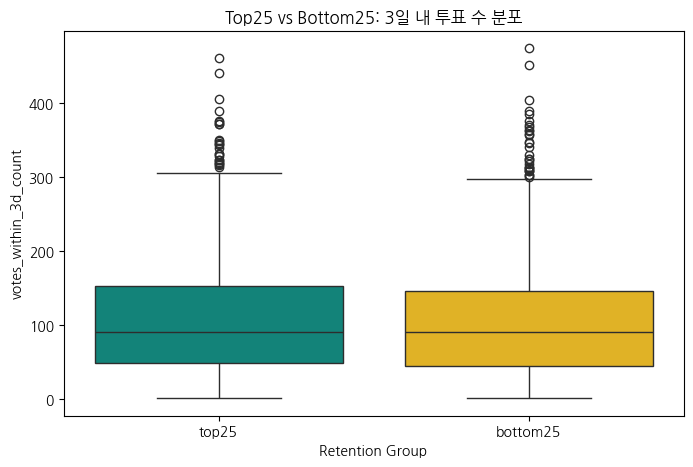

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=top_bottom_df,
    x="retention_group",
    y="votes_within_3d_count",
    palette={"top25": "#009688", "bottom25": "#ffc107"}
)
plt.title("Top25 vs Bottom25: 3Ïùº ÎÇ¥ Ìà¨Ìëú Ïàò Î∂ÑÌè¨")
plt.ylabel("votes_within_3d_count")
plt.xlabel("Retention Group")
plt.show()

In [ ]:
from scipy.stats import ttest_ind

# Îëê Í∑∏Î£π Î∂ÑÎ¶¨
top25_vals = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["votes_within_3d_count"]
bottom25_vals = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["votes_within_3d_count"]

In [20]:
t_stat, p_val = ttest_ind(top25_vals, bottom25_vals, equal_var=False)  

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")

t-statistic: 0.4490
p-value: 0.6534


top  25 bottom 25 Îëê Í∑∏Î£πÏúºÎ°ú ÎÇòÎàÑÏñ¥ votes_within_3d_count (3Ïùº Ìà¨Ìëú ÌöüÏàò) Ïª¨Îüº ÌèâÍ∑† Í∞í

In [43]:
top_bottom_df.to_csv("master-top_bottom.csv", index=False)

In [44]:
top_bottom_df

Unnamed: 0  user_id  total_votes  unique_days  first_vote   last_vote  \
1              1   838466          127            6  2023-05-02  2023-05-07   
7              7   840512          131            7  2023-05-02  2023-05-16   
8              8   840685          547           16  2023-05-02  2023-05-23   
9              9   840902          245           13  2023-05-02  2023-05-17   
11            11   841576          227           11  2023-05-09  2023-05-21   
...          ...      ...          ...          ...         ...         ...   
4672        4672  1497413          118            2  2023-05-24  2023-05-25   
4673        4673  1497699           15            2  2023-05-24  2023-05-25   
4674        4674  1498168           30            2  2023-05-24  2023-05-25   
4675        4675  1498266            4            1  2023-05-24  2023-05-24   
4676        4676  1499419           37            2  2023-05-24  2023-05-25   

      active_days  cohort_day  retention_day8 ret_group  ... candidate_count  \
1               5  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            82.0   
7              14  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            90.0   
8              21  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...           102.0   
9              15  2023-05-02        0.569444     50 Ïù¥ÏÉÅ  ...            86.0   
11             12  2023-05-09        0.731602     50 Ïù¥ÏÉÅ  ...            89.0   
...           ...         ...             ...       ...  ...             ...   
4672            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...            11.0   
4673            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             NaN   
4674            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             8.0   
4675            0  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             NaN   
4676            1  2023-05-24        0.294118     50 ÎØ∏Îßå  ...             4.0   

     chosen_count     ratio       address  student_count  school_type  \
1            37.0  0.451220      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
7            28.0  0.311111      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
8            27.0  0.264706      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
9            18.0  0.209302      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú            578            H   
11           23.0  0.258427       Í≤ΩÍ∏∞ÎèÑ Í¥ëÏ£ºÏãú            486            H   
...           ...       ...           ...            ...          ...   
4672          7.0  0.636364      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   
4673          NaN       NaN  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨            491            H   
4674          1.0  0.125000      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   
4675          NaN       NaN     Ïö∏ÏÇ∞Í¥ëÏó≠Ïãú Ïö∏Ï£ºÍµ∞            550            H   
4676          2.0  0.500000      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú            483            H   

      firstquestion_id               first_question_text  \
1                  298                Ïò∑Ïù¥ Ï†úÏùº ÎßéÏùÑ Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
7                  219  ÎßàÏà†Ïù¥ ÎààÏÜçÏûÑÏù¥ ÏïÑÎãàÎùº ÎßàÎ≤ïÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌï† Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
8                  120             Î≥∏Ïù∏ Î∞©Ïù¥ Ï†úÏùº Íπ®ÎÅóÌï†Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
9                  332        ÏÑ†Î¨º Í≥†Î•¥Îäî ÏÑºÏä§Í∞Ä Í∞ÄÏû• Ï¢ãÏùÑ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
11                 410           Î∞úÎÉÑÏÉàÍ∞Ä Ìò∏ÎëêÍ≥ºÏûê ÎÉÑÏÉàÏùº Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ?   
...                ...                               ...   
4672              1046       Ï°∏ÏóÖ ÌõÑ ÎèôÏ∞ΩÌöåÏóêÏÑú Ï≤≠Ï≤©Ïû• ÎèåÎ¶¥ Í≤É Í∞ôÏùÄ ÏπúÍµ¨Îäî?   
4673               336               Ï†úÎåÄÎ°ú ÎÜÄ Îïå Î∂ÄÎ•¥Í≥† Ïã∂ÏùÄ ÏπúÍµ¨Îäî?   
4674               911                 ÎãµÏû• ÏÜçÎèÑÍ∞Ä Í∞ÄÏû• Îπ†Î•∏ ÏÇ¨ÎûåÏùÄ?   
4675               914                 ÏòàÏà†Í∞êÍ∞ÅÏù¥ Í∞ÄÏû• Îõ∞Ïñ¥ÎÇú ÏπúÍµ¨Îäî?   
4676               831                         Í≥ºÏ¶ôÏÉÅÏù∏ ÏπúÍµ¨Îäî?   

      first_

In [46]:
# Ìà¨Ìëú ÎåÄÏÉÅ Ïàò ÌèâÍ∑†
print("\nÎ¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† Ìà¨Ìëú ÎåÄÏÉÅ Ïàò")
print(top_bottom_df.groupby("retention_group")["vote_nunique_user_count"].mean())


Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† Ìà¨Ìëú ÎåÄÏÉÅ Ïàò
retention_group
bottom25    32.532958
top25       35.512370
Name: vote_nunique_user_count, dtype: float64


In [58]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["vote_nunique_user_count"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["vote_nunique_user_count"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)  # Welch‚Äôs t-test Í∂åÏû•

print("t-statistic:", round(t_stat, 4))
print("p-value:", round(p_val, 4))

t-statistic: 3.8812
p-value: 0.0001


In [59]:
# ÏπúÍµ¨ Ïàò
top_friends = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["period_friend_count"]
bottom_friends = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["period_friend_count"]

t_stat2, p_val2 = ttest_ind(top_friends, bottom_friends, equal_var=False)
print("ÏπúÍµ¨ Ïàò t-stat:", round(t_stat2, 4), "| p-value:", round(p_val2, 4))

ÏπúÍµ¨ Ïàò t-stat: 4.1038 | p-value: 0.0


In [50]:
print("\nÎ¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏπúÍµ¨ Ïàò")
print(top_bottom_df.groupby("retention_group")["period_friend_count"].mean())


Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏπúÍµ¨ Ïàò
retention_group
bottom25    41.172026
top25       45.509178
Name: period_friend_count, dtype: float64


/tmp/ipykernel_582262/3455075902.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


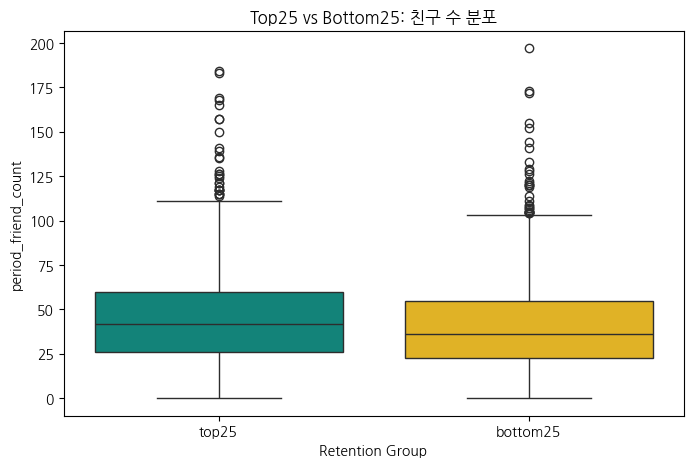

In [57]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=top_bottom_df,
    x="retention_group",
    y="period_friend_count",
    palette={"top25": "#009688", "bottom25": "#ffc107"}
)
plt.title("Top25 vs Bottom25: ÏπúÍµ¨ Ïàò Î∂ÑÌè¨")
plt.ylabel("period_friend_count")
plt.xlabel("Retention Group")
plt.show()

In [ ]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["days_to_vote"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["days_to_vote"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(" Í∞ÄÏûÖ ÌõÑ Ï≤´ Ìà¨ÌëúÍπåÏßÄ Í±∏Î¶∞ ÏùºÏàò t-test")
print(f"Top25 ÌèâÍ∑†: {top.mean():.2f}, Bottom25 ÌèâÍ∑†: {bottom.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

‚úÖ Í∞ÄÏûÖ ÌõÑ Ï≤´ Ìà¨ÌëúÍπåÏßÄ Í±∏Î¶∞ ÏùºÏàò t-test
Top25 ÌèâÍ∑†: 0.65, Bottom25 ÌèâÍ∑†: 0.25
T-statistic: 5.882, P-value: 0.0000


In [ ]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["total_read"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["total_read"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(" Î∞õÏùÄ ÏßàÎ¨∏ Ïó¥Îûå Ïàò t-test")
print(f"Top25 ÌèâÍ∑†: {top.mean():.2f}, Bottom25 ÌèâÍ∑†: {bottom.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

‚úÖ Î∞õÏùÄ ÏßàÎ¨∏ Ïó¥Îûå Ïàò t-test
Top25 ÌèâÍ∑†: 161.19, Bottom25 ÌèâÍ∑†: 90.75
T-statistic: 14.454, P-value: 0.0000


In [66]:
top_bottom_df["total_read"]

1        19.0
7        80.0
8       182.0
9       138.0
11      281.0
        ...  
4672    120.0
4673      0.0
4674    145.0
4675      0.0
4676     27.0
Name: total_read, Length: 2497, dtype: float64

In [67]:
top_bottom_df["total_read"] = top_bottom_df["total_read"].fillna(0)


In [68]:
top_bottom_df["total_read"].isnull().sum()

0

In [ ]:
top1 = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["total_read"]
bottom1 = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["total_read"]

t_stat, p_val = ttest_ind(top1, bottom1, equal_var=False)
print(" Î∞õÏùÄ ÏßàÎ¨∏ Ïó¥Îûå Ïàò t-test")
print(f"Top25 ÌèâÍ∑†: {top1.mean():.2f}, Bottom25 ÌèâÍ∑†: {bottom1.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

‚úÖ Î∞õÏùÄ ÏßàÎ¨∏ Ïó¥Îûå Ïàò t-test
Top25 ÌèâÍ∑†: 161.19, Bottom25 ÌèâÍ∑†: 90.75
T-statistic: 14.454, P-value: 0.0000


In [82]:
top1.count()

1253

In [83]:
bottom1.count()

1244

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [3]:
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")

In [17]:
userquestion_df


id status          created_at  chosen_user_id  question_id  \
0           771777      C 2023-04-28 12:27:49          849469          252   
1           771800      C 2023-04-28 12:28:02          849446          244   
2           771812      C 2023-04-28 12:28:09          849454          183   
3           771828      C 2023-04-28 12:28:16          847375          101   
4           771851      C 2023-04-28 12:28:26          849477          209   
...            ...    ...                 ...             ...          ...   
1217553  161666166      C 2024-05-07 11:29:07          945560         2614   
1217554  161666461      C 2024-05-08 01:34:56          850774         1679   
1217555  161666462      C 2024-05-08 01:35:02          855509         2605   
1217556  161666463      C 2024-05-08 01:36:00          855526         3801   
1217557  161666464      C 2024-05-08 01:36:18          874566         3117   

         user_id  question_piece_id  has_read answer_status  \
0         849436             998458         0             N   
1         849436             998459         0             N   
2         849436             998460         1             N   
3         849436             998461         0             N   
4         849436             998462         1             N   
...          ...                ...       ...           ...   
1217553  1001607          190864020         1             N   
1217554   855525          200139931         0             N   
1217555   855525          200139932         0             N   
1217556   855525          200139933         0             N   
1217557   855525          200139934         0             N   

          answer_updated_at  report_count  opened_times  
0       2023-04-28 12:27:49             0             0  
1       2023-04-28 12:28:02             0             0  
2       2023-04-28 12:28:09             0             0  
3       2023-04-28 12:28:16             0             0  
4       2023-04-28 12:28:26             0             0  
...                     ...           ...           ...  
1217553 2024-05-07 11:29:07             0             0  
1217554 2024-05-08 01:34:56             0             0  
1217555 2024-05-08 01:35:02             0             0  
1217556 2024-05-08 01:36:00             0             0  
1217557 2024-05-08 01:36:18             0             0  

[1217558 rows x 12 columns]

In [5]:
userquestion_df['report_count'].value_counts()

report_count
0     1217389
1         147
2          15
3           3
5           1
4           1
6           1
14          1
Name: count, dtype: int64

In [5]:
# Ï†ÑÏ≤¥ Ìà¨Ìëú Ïàò
total_votes = len(userquestion_df)

# Í≥†Ïú† Ïú†Ï†Ä Ïàò
unique_users = userquestion_df['user_id'].nunique()

# Í≥†Ïú† ÏßàÎ¨∏ Ïàò
unique_questions = userquestion_df['question_id'].nunique()

# Ïú†Ï†ÄÎãπ ÌèâÍ∑† Ìà¨Ìëú Ïàò
avg_votes_per_user = total_votes / unique_users

# Ï∂úÎ†•
print("Í∏∞Î≥∏ ÏßÄÌëú ÏöîÏïΩ")
print(f"Ï†ÑÏ≤¥ Ìà¨Ìëú Ïàò: {total_votes:,}")
print(f"Í≥†Ïú† Ïú†Ï†Ä Ïàò: {unique_users:,}")
print(f"Í≥†Ïú† ÏßàÎ¨∏ Ïàò: {unique_questions:,}")
print(f"Ïú†Ï†ÄÎãπ ÌèâÍ∑† Ìà¨Ìëú Ïàò: {avg_votes_per_user:.2f}")

Í∏∞Î≥∏ ÏßÄÌëú ÏöîÏïΩ
Ï†ÑÏ≤¥ Ìà¨Ìëú Ïàò: 1,217,558
Í≥†Ïú† Ïú†Ï†Ä Ïàò: 4,849
Í≥†Ïú† ÏßàÎ¨∏ Ïàò: 4,805
Ïú†Ï†ÄÎãπ ÌèâÍ∑† Ìà¨Ìëú Ïàò: 251.09


In [6]:
# ÏùëÎãµÎ•† Í¥ÄÎ†® Î≥ÄÏàò Î∂ÑÌè¨ ÏöîÏïΩ
response_summary = {
    "Ï¥ù Ìà¨Ìëú Ïàò": len(userquestion_df),
    "ÏùΩÏùÄ ÎπÑÏú® (has_read == 1)": userquestion_df["has_read"].mean(),
    "ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨ (answer_status)": userquestion_df["answer_status"].value_counts(normalize=True),
    "Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)": userquestion_df["opened_times"].value_counts(normalize=True).sort_index()
}

# ÏùëÎãµÎ•† Ï†ïÎ¶¨Ïö©
summary_df = pd.DataFrame({
    "Ìï≠Î™©": ["ÏùΩÏùÄ ÎπÑÏú®", "ÎØ∏ÎãµÎ≥Ä(N)", "ÎπÑÍ≥µÍ∞ú(P)", "Í≥µÍ∞ú(A)", "Ïó¥Îûå 0Ìöå", "Ïó¥Îûå 1Ìöå", "Ïó¥Îûå 2Ìöå", "Ïó¥Îûå 3Ìöå"],
    "ÎπÑÏú®": [
        response_summary["ÏùΩÏùÄ ÎπÑÏú® (has_read == 1)"],
        response_summary["ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨ (answer_status)"].get("N", 0),
        response_summary["ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨ (answer_status)"].get("P", 0),
        response_summary["ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨ (answer_status)"].get("A", 0),
        response_summary["Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)"].get(0, 0),
        response_summary["Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)"].get(1, 0),
        response_summary["Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)"].get(2, 0),
        response_summary["Ìà¨Ìëú Ïó¥Îûå ÌöüÏàò (opened_times)"].get(3, 0)
    ]
})

print(summary_df)

       Ìï≠Î™©        ÎπÑÏú®
0   ÏùΩÏùÄ ÎπÑÏú®  0.555153
1  ÎØ∏ÎãµÎ≥Ä(N)  0.901749
2  ÎπÑÍ≥µÍ∞ú(P)  0.006460
3   Í≥µÍ∞ú(A)  0.091791
4   Ïó¥Îûå 0Ìöå  0.950177
5   Ïó¥Îûå 1Ìöå  0.038505
6   Ïó¥Îûå 2Ìöå  0.009133
7   Ïó¥Îûå 3Ìöå  0.002185


In [8]:
read_but_not_answered = userquestion_df[(userquestion_df["has_read"] == 1) & (userquestion_df["answer_status"] == "N")]
read_but_not_answered_ratio = len(read_but_not_answered) / len(userquestion_df)
print(f"ÏùΩÏóàÏßÄÎßå ÎØ∏ÎãµÎ≥Ä ÎπÑÏú®: {read_but_not_answered_ratio:.2%}")


ÏùΩÏóàÏßÄÎßå ÎØ∏ÎãµÎ≥Ä ÎπÑÏú®: 45.69%


In [9]:
opened_answer_pivot = pd.crosstab(userquestion_df["opened_times"], userquestion_df["answer_status"], normalize='index')
print(opened_answer_pivot)

answer_status         A         N         P
opened_times                               
0              0.087398  0.906999  0.005604
1              0.164093  0.814876  0.021032
2              0.213219  0.759712  0.027068
3              0.220677  0.743609  0.035714


In [18]:
# ÏÉÅÌÉú Î∂ÑÌè¨
status_dist = userquestion_df["status"].value_counts(normalize=True)
print("üìä status Î∂ÑÌè¨:\n", status_dist)

# ÏÉÅÌÉúÎ≥Ñ ÎãµÎ≥Ä ÏÉÅÌÉú ÍµêÏ∞®Ìëú
status_answer_pivot = pd.crosstab(userquestion_df["status"], userquestion_df["answer_status"], normalize='index')
print("\nüìä status vs answer_status ÎπÑÏú® (row-wise):\n", status_answer_pivot)


üìä status Î∂ÑÌè¨:
 status
C    0.949706
I    0.049754
B    0.000540
Name: proportion, dtype: float64

üìä status vs answer_status ÎπÑÏú® (row-wise):
 answer_status         A         N         P
status                                     
B              0.071429  0.922492  0.006079
C              0.087415  0.906978  0.005607
I              0.175542  0.801710  0.022748


In [19]:
# 1. ÏùëÎãµ Ïú†Ï†Ä ÎπÑÏú®
responded_user_ids = userquestion_df[userquestion_df['answer_status'].isin(['A', 'P'])]['user_id'].unique()
responded_user_count = len(responded_user_ids)
total_user_count = userquestion_df['user_id'].nunique()
response_user_ratio = responded_user_count / total_user_count

# 2. Ïú†Ï†ÄÎãπ ÌèâÍ∑† ÏùëÎãµ Ïàò
total_response_count = len(userquestion_df[userquestion_df['answer_status'].isin(['A', 'P'])])
avg_responses_per_user = total_response_count / total_user_count

# Ï∂úÎ†•
print(f"‚úÖ ÏùëÎãµ Ïú†Ï†Ä ÎπÑÏú®: {response_user_ratio:.2%}")
print(f"‚úÖ Ïú†Ï†ÄÎãπ ÌèâÍ∑† ÏùëÎãµ Ïàò: {avg_responses_per_user:.2f}")

‚úÖ ÏùëÎãµ Ïú†Ï†Ä ÎπÑÏú®: 91.63%
‚úÖ Ïú†Ï†ÄÎãπ ÌèâÍ∑† ÏùëÎãµ Ïàò: 24.67


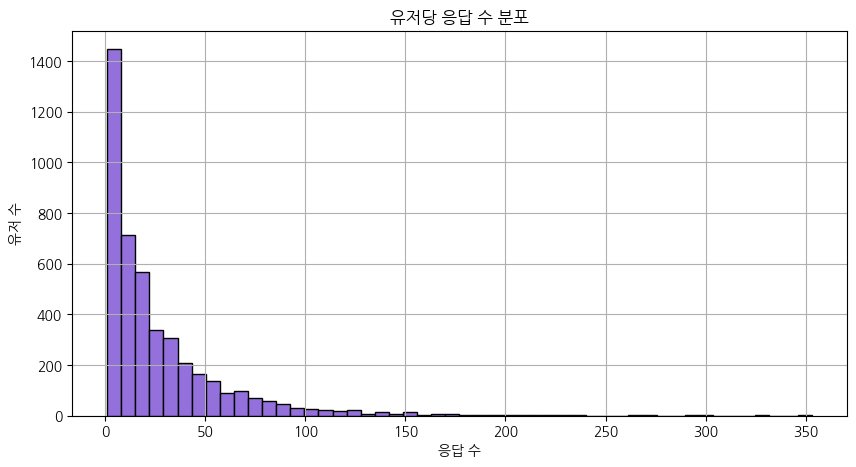

‚úÖ 1ÌöåÎßå ÏùëÎãµÌïú Ïú†Ï†Ä ÎπÑÏú®: 6.62%
‚úÖ ÏÉÅÏúÑ 10% Ïú†Ï†ÄÏùò ÏùëÎãµ Í∏∞Ïó¨Ïú®: 38.09%


In [20]:
import matplotlib.pyplot as plt

# 1. ÏùëÎãµ Ïú†Ï†Ä Îç∞Ïù¥ÌÑ∞ (Í≥µÍ∞ú or ÎπÑÍ≥µÍ∞ú ÏùëÎãµÎßå)
responded_df = userquestion_df[userquestion_df['answer_status'].isin(['A', 'P'])]

# 2. Ïú†Ï†ÄÎ≥Ñ ÏùëÎãµ Ïàò ÏßëÍ≥Ñ
user_response_counts = responded_df['user_id'].value_counts()

# 3. 1ÌöåÎßå ÏùëÎãµÌïú Ïú†Ï†Ä ÎπÑÏú®
one_time_users = (user_response_counts == 1).sum()
one_time_ratio = one_time_users / len(user_response_counts)

# 4. ÏÉÅÏúÑ 10% Ïú†Ï†ÄÍ∞Ä Ï†ÑÏ≤¥ ÏùëÎãµÏóê Í∏∞Ïó¨Ìïú ÎπÑÏú®
top_10pct_count = int(len(user_response_counts) * 0.1)
top_responders_total = user_response_counts.sort_values(ascending=False).head(top_10pct_count).sum()
total_responses = user_response_counts.sum()
top_10pct_ratio = top_responders_total / total_responses

# 5. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 5))
plt.hist(user_response_counts, bins=50, color='mediumpurple', edgecolor='black')
plt.title("Ïú†Ï†ÄÎãπ ÏùëÎãµ Ïàò Î∂ÑÌè¨")
plt.xlabel("ÏùëÎãµ Ïàò")
plt.ylabel("Ïú†Ï†Ä Ïàò")
plt.grid(True)
plt.show()

# 6. ÏöîÏïΩ Ï∂úÎ†•
print(f"‚úÖ 1ÌöåÎßå ÏùëÎãµÌïú Ïú†Ï†Ä ÎπÑÏú®: {one_time_ratio:.2%}")
print(f"‚úÖ ÏÉÅÏúÑ 10% Ïú†Ï†ÄÏùò ÏùëÎãµ Í∏∞Ïó¨Ïú®: {top_10pct_ratio:.2%}")


In [21]:
one_time_users

294

In [24]:
user_response_counts.count()

4443

In [6]:
# 1. ÏùΩÏóàÏßÄÎßå ÏùëÎãµÌïòÏßÄ ÏïäÏùÄ Í≤ΩÏö∞
read_not_answered_df = userquestion_df[(userquestion_df['has_read'] == 1) & (userquestion_df['answer_status'] == 'N')]
read_not_answered_ratio = len(read_not_answered_df) / len(userquestion_df)

# 2. Í∑∏ Ï§ëÏóêÏÑú opened_times >= 3Ïù∏ Í≤ΩÏö∞
hesitant_df = read_not_answered_df[read_not_answered_df['opened_times'] >= 3]
hesitant_ratio = len(hesitant_df) / len(userquestion_df)

# 3. Í≥†Ïú† Ïú†Ï†Ä Ïàò
unique_hesitant_users = hesitant_df['chosen_user_id'].nunique()

# Ï∂úÎ†•
print(f" ÏùΩÏóàÏßÄÎßå ÏùëÎãµÌïòÏßÄ ÏïäÏùÄ ÎπÑÏú®: {read_not_answered_ratio:.2%}")
print(f" (Ïó¥Îûå 3Ìöå Ïù¥ÏÉÅ) ÎßùÏÑ§Ïù∏ ÎØ∏ÏùëÎãµ ÎπÑÏú®: {hesitant_ratio:.2%}")
print(f" ÎßùÏÑ§Ïù∏ ÎØ∏ÏùëÎãµ Ïú†Ï†Ä Ïàò: {unique_hesitant_users:,}Î™Ö")


 ÏùΩÏóàÏßÄÎßå ÏùëÎãµÌïòÏßÄ ÏïäÏùÄ ÎπÑÏú®: 45.69%
 (Ïó¥Îûå 3Ìöå Ïù¥ÏÉÅ) ÎßùÏÑ§Ïù∏ ÎØ∏ÏùëÎãµ ÎπÑÏú®: 0.16%
 ÎßùÏÑ§Ïù∏ ÎØ∏ÏùëÎãµ Ïú†Ï†Ä Ïàò: 1,401Î™Ö


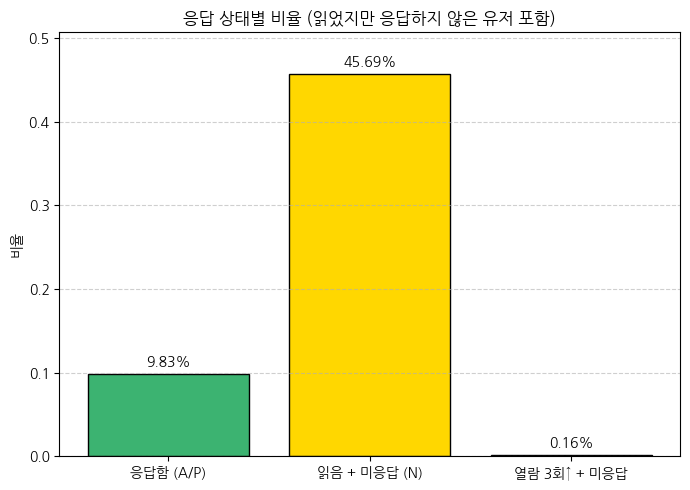

In [7]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
labels = ['ÏùëÎãµÌï® (A/P)', 'ÏùΩÏùå + ÎØ∏ÏùëÎãµ (N)', 'Ïó¥Îûå 3Ìöå‚Üë + ÎØ∏ÏùëÎãµ']
sizes = [
    userquestion_df['answer_status'].isin(['A', 'P']).mean(),
    read_not_answered_ratio,
    hesitant_ratio
]

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(7, 5))
bars = plt.bar(labels, sizes, color=['mediumseagreen', 'gold', 'tomato'], edgecolor='black')
plt.title("ÏùëÎãµ ÏÉÅÌÉúÎ≥Ñ ÎπÑÏú® (ÏùΩÏóàÏßÄÎßå ÏùëÎãµÌïòÏßÄ ÏïäÏùÄ Ïú†Ï†Ä Ìè¨Ìï®)")
plt.ylim(0, max(sizes) + 0.05)
plt.ylabel("ÎπÑÏú®")

# Í∞í ÌëúÏãú
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2%}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

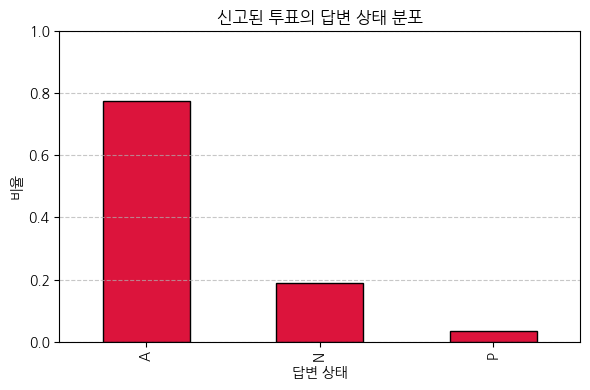

Ïã†Í≥†Îêú Ìà¨Ìëú ÎπÑÏú®: 0.01%
Ïã†Í≥†Îêú Ìà¨ÌëúÏùò ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨:
answer_status
A    0.775148
N    0.189349
P    0.035503
Name: proportion, dtype: float64
Ï∞®Îã®Îêú Ìà¨Ìëú ÎπÑÏú®: 0.0540%
Ïã†Í≥† + Ï∞®Îã® Î™®Îëê Î∞úÏÉùÌïú ÎπÑÏú®: 0.0001%


In [8]:
# 1. Ïã†Í≥†Îêú Ìà¨Ìëú ÎπÑÏú®
reported_df = userquestion_df[userquestion_df['report_count'] > 0]
report_ratio = len(reported_df) / len(userquestion_df)

# 2. Ïã†Í≥†Îêú Ìà¨ÌëúÏùò answer_status Î∂ÑÌè¨
report_answer_dist = reported_df['answer_status'].value_counts(normalize=True)

# 3. Ï∞®Îã® ÏÉÅÌÉú ÎπÑÏú®
block_ratio = (userquestion_df['status'] == 'B').mean()

# 4. Ïã†Í≥† + Ï∞®Îã® Î™®Îëê Î∞úÏÉùÌïú Ìà¨Ìëú ÎπÑÏú®
report_and_block_df = userquestion_df[(userquestion_df['report_count'] > 0) & (userquestion_df['status'] == 'B')]
report_block_ratio = len(report_and_block_df) / len(userquestion_df)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 4))
report_answer_dist.sort_index().plot(kind='bar', color='crimson', edgecolor='black')
plt.title("Ïã†Í≥†Îêú Ìà¨ÌëúÏùò ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨")
plt.xlabel("ÎãµÎ≥Ä ÏÉÅÌÉú")
plt.ylabel("ÎπÑÏú®")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Ï∂úÎ†•
print(f"Ïã†Í≥†Îêú Ìà¨Ìëú ÎπÑÏú®: {report_ratio:.2%}")
print("Ïã†Í≥†Îêú Ìà¨ÌëúÏùò ÎãµÎ≥Ä ÏÉÅÌÉú Î∂ÑÌè¨:")
print(report_answer_dist)
print(f"Ï∞®Îã®Îêú Ìà¨Ìëú ÎπÑÏú®: {block_ratio:.4%}")
print(f"Ïã†Í≥† + Ï∞®Îã® Î™®Îëê Î∞úÏÉùÌïú ÎπÑÏú®: {report_block_ratio:.4%}")


Ïù¥Ï†ú Îã§Î•∏ Í±∞ ÏßàÎ¨∏ÏÑ∏Ìä∏ Ïò§ÌîàÏú® Î¥êÎ≥ºÍπå

In [10]:
#ÏßàÎ¨∏ ÏÑ∏Ìä∏ Îç∞Ïù¥ÌÑ∞
questionset_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_questionset.parquet")
# ÏßàÎ¨∏ Ï°∞Í∞Å Îç∞Ïù¥ÌÑ∞
questionpiece_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_questionpiece.parquet")
# Ïú†Ï†Ä Ìà¨Ìëú Í∏∞Î°ù
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")

In [11]:
# Ï†ÑÏ≤¥ ÏÑ∏Ìä∏ Ïàò
total_qset = len(questionset_df)

# Ïò§Ìîà ÏÉÅÌÉú ('O': Opened, 'F': Finished)
opened_qset = questionset_df[questionset_df['status'].isin(['O', 'F'])]
open_rate = len(opened_qset) / total_qset

print(f"ÏßàÎ¨∏ ÏÑ∏Ìä∏ Ïò§ÌîàÏú®: {open_rate:.2%}")

ÏßàÎ¨∏ ÏÑ∏Ìä∏ Ïò§ÌîàÏú®: 99.64%


In [17]:
total_qset 

158384

In [13]:
import ast

# Î¨∏ÏûêÏó¥ ‚Üí Ïã§Ï†ú Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
questionset_df['question_piece_id_list'] = questionset_df['question_piece_id_list'].dropna().apply(ast.literal_eval)

# Ïò§Ìîà ÏÉÅÌÉú ÏßàÎ¨∏ ÏÑ∏Ìä∏Îßå ÌïÑÌÑ∞ÎßÅ
opened_qset = questionset_df[questionset_df['status'].isin(['O', 'F'])]

# ÏßàÎ¨∏ Ï°∞Í∞Å Î¶¨Ïä§Ìä∏ ÌéºÏπòÍ∏∞ (explode)
opened_piece_ids = opened_qset.explode('question_piece_id_list')['question_piece_id_list'].dropna().astype(int).unique()


In [ ]:
ÏßàÎ¨∏ ÏÑ∏Ìä∏ Ïò§ÌîàÏú®: polls_questionset ÌÖåÏù¥Î∏îÏóêÏÑú statusÍ∞Ä "O" (Ïó¥Î¶º) ÎòêÎäî "F" (Ï¢ÖÎ£å)Ïù∏ ÏÑ∏Ìä∏Îßå ÌïÑÌÑ∞ÎßÅÌïú Í≤É.

In [16]:
# ÏùëÎãµÌïú ÏßàÎ¨∏ Ï°∞Í∞Å ÌïÑÌÑ∞ÎßÅ
answered_df = userquestion_df[
    (userquestion_df['question_piece_id'].isin(opened_piece_ids)) &
    (userquestion_df['answer_status'].isin(['A', 'P']))
]

# Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
conversion_rate = answered_df['question_piece_id'].nunique() / len(opened_piece_ids)
print(f" ÏùëÎãµ Ï†ÑÌôòÏú® (ÏßàÎ¨∏ Ï°∞Í∞Å Í∏∞Ï§Ä): {conversion_rate:.2%}")

 ÏùëÎãµ Ï†ÑÌôòÏú® (ÏßàÎ¨∏ Ï°∞Í∞Å Í∏∞Ï§Ä): 7.58%


In [ ]:
ÏùëÎãµ Ï†ÑÌôòÏú®: Ïò§ÌîàÎêú ÏßàÎ¨∏ ÏÑ∏Ìä∏Ïóê ÏÜçÌïú ÏßàÎ¨∏ Ï°∞Í∞ÅÎì§ Ï§ë Ïã§Ï†úÎ°ú ÏùëÎãµ(Í≥µÍ∞ú or ÎπÑÍ≥µÍ∞ú)Îêú ÏßàÎ¨∏ Ï°∞Í∞Å ÎπÑÏú®.

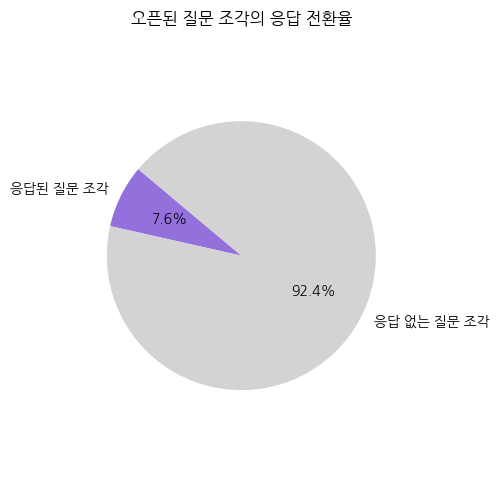

In [15]:

# Í∞í Ï§ÄÎπÑ
labels = ['ÏùëÎãµÎêú ÏßàÎ¨∏ Ï°∞Í∞Å', 'ÏùëÎãµ ÏóÜÎäî ÏßàÎ¨∏ Ï°∞Í∞Å']
sizes = [conversion_rate, 1 - conversion_rate]

# ÌååÏù¥ Ï∞®Ìä∏
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['mediumpurple', 'lightgray'])
plt.title('Ïò§ÌîàÎêú ÏßàÎ¨∏ Ï°∞Í∞ÅÏùò ÏùëÎãµ Ï†ÑÌôòÏú®')
plt.axis('equal')  # ÏõêÌòï Ïú†ÏßÄ
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
vote_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")
master_df = pd.read_csv("/home/sprintda05/final/master_last_v2.csv",parse_dates=["first_vote", "last_vote", "cohort_day"])
friend_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_friendrequest.parquet")


In [3]:
master_df 

user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0      838023           22            5 2023-04-29 2023-05-04            5   
1      838466          129            7 2023-05-02 2023-06-02           31   
2      838642           10            2 2023-04-28 2023-04-29            1   
3      839357          212            9 2023-04-29 2023-05-26           27   
4      840293          170            7 2023-05-03 2023-05-15           12   
...       ...          ...          ...        ...        ...          ...   
4698  1510561          475           19 2023-05-25 2023-06-13           19   
4699  1511957          103           11 2023-05-25 2023-06-12           18   
4700  1512422          243            8 2023-05-25 2023-06-01            7   
4701  1512542          636           12 2023-05-25 2023-06-06           12   
4702  1513236          302            9 2023-05-25 2023-06-15           21   

     cohort_day  retention_day8 gender  school_id  grade  group_id  \
0    2023-04-29        0.515152      F      271.0    1.0     233.0   
1    2023-05-02        0.569444      F      369.0    2.0     321.0   
2    2023-04-28        0.560000      F      271.0    2.0     356.0   
3    2023-04-29        0.515152      M      271.0    1.0     519.0   
4    2023-05-03        0.422977      F      369.0    1.0     838.0   
...         ...             ...    ...        ...    ...       ...   
4698 2023-05-25        0.451613      M     4426.0    2.0   73885.0   
4699 2023-05-25        0.451613      F     5520.0    2.0   29558.0   
4700 2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4701 2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4702 2023-05-25        0.451613      F     4426.0    3.0   70559.0   

      votes_within_3d  chosen_user_count  
0                   7                 11  
1                  77                 28  
2                  10                  6  
3                 114                 46  
4                 130                 32  
...               ...                ...  
4698               68                 46  
4699               23                 19  
4700              127                 11  
4701              167                 31  
4702              137                 45  

[4703 rows x 14 columns]

In [4]:
friend_df 

id status          created_at          updated_at  \
0                7      P 2023-04-17 18:29:11 2023-04-17 18:29:11   
1               10      A 2023-04-17 18:29:11 2023-04-22 06:02:53   
2               11      A 2023-04-17 18:29:11 2023-04-18 19:28:41   
3               13      A 2023-04-17 18:29:11 2023-04-19 11:05:04   
4               20      P 2023-04-17 18:29:11 2023-04-17 18:29:11   
...            ...    ...                 ...                 ...   
17147170  19692975      P 2024-05-09 07:24:50 2024-05-09 07:24:50   
17147171  19692976      A 2024-05-09 07:31:41 2024-05-09 07:33:06   
17147172  19692977      P 2024-05-09 08:20:44 2024-05-09 08:20:44   
17147173  19692978      R 2024-05-09 09:19:40 2024-05-09 09:19:43   
17147174  19692979      P 2024-05-09 09:21:47 2024-05-09 09:21:47   

          receive_user_id  send_user_id  
0                  831962        837521  
1                  832151        837521  
2                  832340        837521  
3                  833041        837521  
4                  834415        837521  
...                   ...           ...  
17147170          1583730       1583731  
17147171          1583731       1583673  
17147172          1299129       1575671  
17147173          1304403       1392729  
17147174          1304403       1392729  

[17147175 rows x 6 columns]

In [5]:
# status == 'A' ‚Üí ÏàòÎùΩÎêú ÏπúÍµ¨ ÏöîÏ≤≠Îßå
accepted_df = friend_df[
    (friend_df["status"] == "A") &
    (friend_df["created_at"] >= pd.to_datetime("2023-04-28")) &
    (friend_df["created_at"] < pd.to_datetime("2023-08-01"))
].copy()

In [6]:
# Î≥¥ÎÇ∏ ÏÇ¨Îûå Í∏∞Ï§Ä
sent_df = accepted_df.groupby("send_user_id")["receive_user_id"].nunique().reset_index()
sent_df.columns = ["user_id", "sent_friend_count"]

# Î∞õÏùÄ ÏÇ¨Îûå Í∏∞Ï§Ä
recv_df = accepted_df.groupby("receive_user_id")["send_user_id"].nunique().reset_index()
recv_df.columns = ["user_id", "recv_friend_count"]

In [7]:
# Î≥¥ÎÇ∏ Ï™ΩÍ≥º Î∞õÏùÄ Ï™Ω Î≥ëÌï©
friend_count_df = pd.merge(sent_df, recv_df, on="user_id", how="outer").fillna(0)

# Ï¥ù ÏπúÍµ¨ Ïàò
friend_count_df["period_friend_count"] = (
    friend_count_df["sent_friend_count"] + friend_count_df["recv_friend_count"]
)


In [9]:
friend_count_df.isnull().sum()

user_id                0
sent_friend_count      0
recv_friend_count      0
period_friend_count    0
dtype: int64

In [18]:
friend_count_df['period_friend_count'].min()

1.0

In [11]:
# ÎßàÏä§ÌÑ∞ ÌÖåÏù¥Î∏îÏóê ÏπúÍµ¨ Ïàò Î≥ëÌï©
master_df = master_df.merge(
    friend_count_df[["user_id", "period_friend_count"]],
    on="user_id",
    how="left"
)



In [12]:
master_df.isnull().sum()

user_id                 0
total_votes             0
unique_days             0
first_vote              0
last_vote               0
active_days             0
cohort_day              0
retention_day8          0
gender                  0
school_id               0
grade                   0
group_id                0
votes_within_3d         0
chosen_user_count       0
period_friend_count    15
dtype: int64

In [13]:
# Í≤∞Ï∏°Í∞íÏùÄ ÏπúÍµ¨Í∞Ä ÏóÜÎäî Í≤ÉÏúºÎ°ú Ï≤òÎ¶¨
master_df["period_friend_count"] = master_df["period_friend_count"].fillna(0)

In [14]:
master_df['period_friend_count'].isnull().sum()

0

In [15]:
master_df['period_friend_count'].count()

4703

In [19]:
master_df

user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0      838023           22            5 2023-04-29 2023-05-04            5   
1      838466          129            7 2023-05-02 2023-06-02           31   
2      838642           10            2 2023-04-28 2023-04-29            1   
3      839357          212            9 2023-04-29 2023-05-26           27   
4      840293          170            7 2023-05-03 2023-05-15           12   
...       ...          ...          ...        ...        ...          ...   
4698  1510561          475           19 2023-05-25 2023-06-13           19   
4699  1511957          103           11 2023-05-25 2023-06-12           18   
4700  1512422          243            8 2023-05-25 2023-06-01            7   
4701  1512542          636           12 2023-05-25 2023-06-06           12   
4702  1513236          302            9 2023-05-25 2023-06-15           21   

     cohort_day  retention_day8 gender  school_id  grade  group_id  \
0    2023-04-29        0.515152      F      271.0    1.0     233.0   
1    2023-05-02        0.569444      F      369.0    2.0     321.0   
2    2023-04-28        0.560000      F      271.0    2.0     356.0   
3    2023-04-29        0.515152      M      271.0    1.0     519.0   
4    2023-05-03        0.422977      F      369.0    1.0     838.0   
...         ...             ...    ...        ...    ...       ...   
4698 2023-05-25        0.451613      M     4426.0    2.0   73885.0   
4699 2023-05-25        0.451613      F     5520.0    2.0   29558.0   
4700 2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4701 2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4702 2023-05-25        0.451613      F     4426.0    3.0   70559.0   

      votes_within_3d  chosen_user_count  period_friend_count  
0                   7                 11                  0.0  
1                  77                 28                 63.0  
2                  10                  6                  6.0  
3                 114                 46                 53.0  
4                 130                 32                 20.0  
...               ...                ...                  ...  
4698               68                 46                 32.0  
4699               23                 19                 15.0  
4700              127                 11                 11.0  
4701              167                 31                 28.0  
4702              137                 45                 46.0  

[4703 rows x 15 columns]

In [20]:
master_df.to_csv("master-last_v3.csv", index=False)

In [ ]:
group_friend_mean = master_df.groupby("ret_group")["period_friend_count"].mean()
print(group_friend_mean)

ret_group
50 ÎØ∏Îßå    43.276187
50 Ïù¥ÏÉÅ    45.156063
Name: period_friend_count, dtype: float64


In [15]:
print(" Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏπúÍµ¨ Ïàò")
for group, avg in group_friend_mean.items():
    print(f"- {group}: ÌèâÍ∑† ÏπúÍµ¨ Ïàò = {avg:.2f}")

 Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏπúÍµ¨ Ïàò
- 50 ÎØ∏Îßå: ÌèâÍ∑† ÏπúÍµ¨ Ïàò = 43.28
- 50 Ïù¥ÏÉÅ: ÌèâÍ∑† ÏπúÍµ¨ Ïàò = 45.16


In [14]:
from scipy.stats import ttest_ind

group_high = master_df[master_df["ret_group"] == "50 Ïù¥ÏÉÅ"]["period_friend_count"]
group_low = master_df[master_df["ret_group"] == "50 ÎØ∏Îßå"]["period_friend_count"]

t_stat, p_val = ttest_ind(group_high, group_low, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.3f}")

T-statistic: 2.184, P-value: 0.029


/tmp/ipykernel_497916/4046183191.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


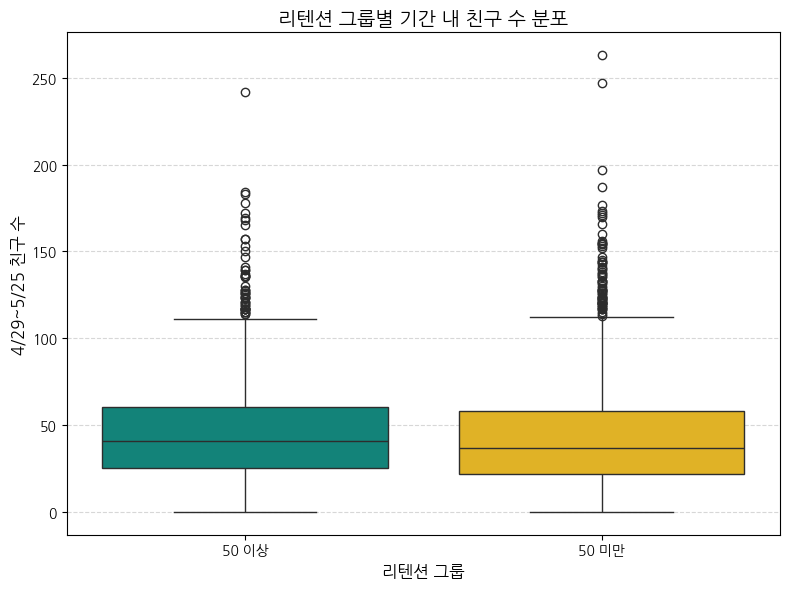

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# ÏãúÍ∞ÅÌôî Ïä§ÌÉÄÏùº
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=master_df,
    x="ret_group",
    y="period_friend_count",
    palette={"50 Ïù¥ÏÉÅ": "#009688", "50 ÎØ∏Îßå": "#ffc107"}
)

plt.title("Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ Í∏∞Í∞Ñ ÎÇ¥ ÏπúÍµ¨ Ïàò Î∂ÑÌè¨", fontsize=14)
plt.xlabel("Î¶¨ÌÖêÏÖò Í∑∏Î£π", fontsize=12)
plt.ylabel("4/29~5/25 ÏπúÍµ¨ Ïàò", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# ÌïôÍµê 10Í∞ú 

In [ ]:
# Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ school_id Í∞úÏàò ÏßëÍ≥Ñ
school_counts = (
    master_df.groupby(["ret_group", "school_id"])["user_id"]
    .count()
    .reset_index()
    .rename(columns={"user_id": "user_count"})
)

# Î≥¥Í∏∞ Ï¢ãÍ≤å ÌîºÎ≤ó (Ìñâ: school_id, Ïó¥: ret_group)
school_pivot = school_counts.pivot(index="school_id", columns="ret_group", values="user_count").fillna(0)

# Ï†ïÎ†¨: Ï†ÑÏ≤¥ Ïú†Ï†Ä Ïàò Í∏∞Ï§ÄÏúºÎ°ú ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
school_pivot["total"] = school_pivot.sum(axis=1)
school_pivot_sorted = school_pivot.sort_values(by="total", ascending=False)

# ÏÉÅÏúÑ NÍ∞ú ÌïôÍµêÎßå Î≥¥Í∏∞ (Ïòà: ÏÉÅÏúÑ 10Í∞ú)
top_schools = school_pivot_sorted.head(10)
print(top_schools[["50 Ïù¥ÏÉÅ", "50 ÎØ∏Îßå"]])

ret_group  50 Ïù¥ÏÉÅ  50 ÎØ∏Îßå
school_id              
1719.0        14    524
369.0         47    488
5372.0       257    219
271.0        361     99
352.0         29    430
5520.0       328    128
5491.0       291    164
1478.0       236    209
4516.0        61    381
4426.0       215    222


In [43]:
top_schools["50 Ïù¥ÏÉÅ"].sum()

1839

In [42]:
top_schools["50 ÎØ∏Îßå"].sum()

2864

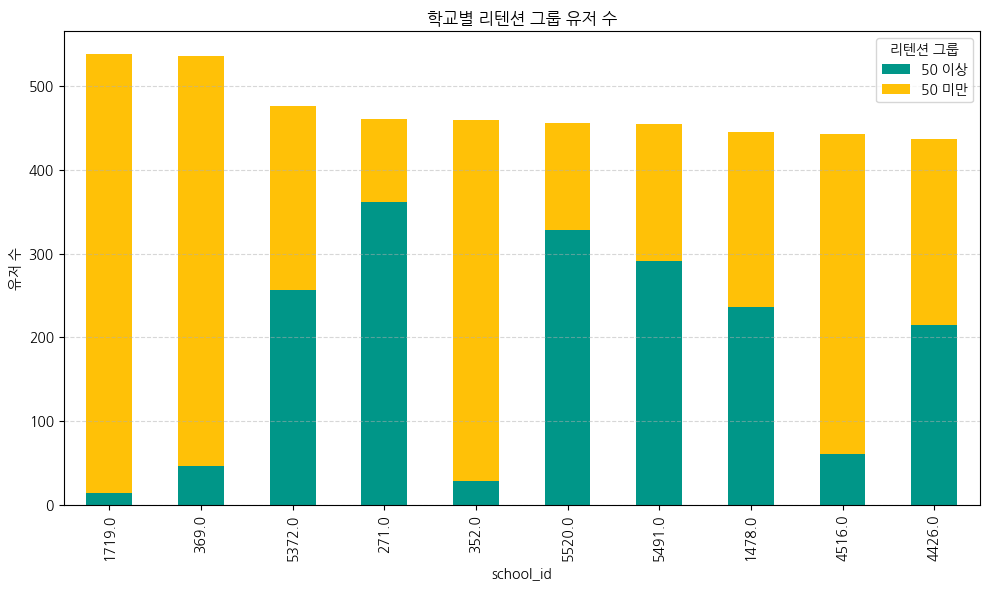

In [45]:
top_schools[["50 Ïù¥ÏÉÅ", "50 ÎØ∏Îßå"]].plot(kind="bar", figsize=(10, 6), stacked=True, color=["#009688", "#ffc107"])
plt.title("ÌïôÍµêÎ≥Ñ Î¶¨ÌÖêÏÖò Í∑∏Î£π Ïú†Ï†Ä Ïàò")
plt.xlabel("school_id")
plt.ylabel("Ïú†Ï†Ä Ïàò")
plt.legend(title="Î¶¨ÌÖêÏÖò Í∑∏Î£π")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [22]:
top_schools['total'].sum()

4703

In [23]:
school_df

id  grade  class_num  school_id
0          1      1          1          1
1          8      3          2          1
2          9      3          3          1
3         10      2          2          1
4         11      2          3          1
...      ...    ...        ...        ...
84510  84542      3          2       5107
84511  84543      2          7       3487
84512  84544      3          1       5043
84513  84545      2          7        416
84514  84546      3         11       2240

[84515 rows x 4 columns]

In [24]:
school2_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_school.parquet")


In [25]:
school2_df 

id   address  student_count school_type
0        4  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            239           H
1        5  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            160           M
2        6  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            200           H
3        7  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            114           H
4        8  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            139           M
...    ...       ...            ...         ...
5946  5960  Í≤ΩÏÉÅÎÇ®ÎèÑ ÏñëÏÇ∞Ïãú            166           H
5947  5961  Ïù∏Ï≤úÍ¥ëÏó≠Ïãú ÏÑúÍµ¨             77           M
5948  5963    Í≤ΩÎ∂Å ÍπÄÏ≤úÏãú             17           H
5949  5964         -              1           H
5950  5965  Í≤ΩÍ∏∞ÎèÑ ÎèôÎëêÏ≤úÏãú             37           H

[5951 rows x 4 columns]

In [30]:
# ÌïÑÏöîÌïú Ï†ïÎ≥¥ ÌïÑÌÑ∞ÎßÅ
school_info_top = school2_df[
    school2_df["id"].isin(top_school_ids)
][["id", "address", "school_type"]].copy()

# Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨
school_info_top = school_info_top.rename(columns={"id": "school_id"})

In [31]:
school_info_top

school_id       address school_type
267         271  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨           H
348         352      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú           H
365         369      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú           H
1472       1478      Ïù∏Ï≤úÍ¥ëÏó≠Ïãú ÏÑúÍµ¨           M
1713       1719     Ïö∏ÏÇ∞Í¥ëÏó≠Ïãú Ïö∏Ï£ºÍµ∞           H
4419       4426      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú           H
4509       4516       Í≤ΩÍ∏∞ÎèÑ ÌôîÏÑ±Ïãú           H
5365       5372      Í≤ΩÍ∏∞ÎèÑ ÎÇ®ÏñëÏ£ºÏãú           H
5484       5491       Í≤ΩÍ∏∞ÎèÑ Í¥ëÏ£ºÏãú           H
5513       5520       Í≤ΩÍ∏∞ÎèÑ Í¥ëÎ™ÖÏãú           M

In [ ]:
# school_pivotÏùÑ Î¶¨ÏÖãÌï¥ÏÑú Î≥ëÌï© Ï§ÄÎπÑ
school_stats = school_pivot.reset_index()

# ÌïÑÏöîÌïú ÌïôÍµêÎßå ÌïÑÌÑ∞ÎßÅ
school_stats = school_stats[school_stats["school_id"].isin(top_school_ids)]

# retention ÎπÑÏú® Í≥ÑÏÇ∞
school_stats["retention_rate"] = (
    school_stats["50 Ïù¥ÏÉÅ"] / (school_stats["50 Ïù¥ÏÉÅ"] + school_stats["50 ÎØ∏Îßå"])
) * 100

# ÌïôÍµê Ï£ºÏÜå Î∞è Ïú†ÌòïÍ≥º Î≥ëÌï©
school_stats = school_stats.merge(school_info_top, on="school_id", how="left")

# Î≥¥Í∏∞ Ï¢ãÍ≤å Ï†ïÎ†¨
school_stats = school_stats.sort_values(by="retention_rate", ascending=False)


In [33]:
school_stats

school_id  50 ÎØ∏Îßå  50 Ïù¥ÏÉÅ  total  retention_rate       address school_type
0      271.0     99    361    460       78.478261  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨           H
9     5520.0    128    328    456       71.929825       Í≤ΩÍ∏∞ÎèÑ Í¥ëÎ™ÖÏãú           M
8     5491.0    164    291    455       63.956044       Í≤ΩÍ∏∞ÎèÑ Í¥ëÏ£ºÏãú           H
7     5372.0    219    257    476       53.991597      Í≤ΩÍ∏∞ÎèÑ ÎÇ®ÏñëÏ£ºÏãú           H
3     1478.0    209    236    445       53.033708      Ïù∏Ï≤úÍ¥ëÏó≠Ïãú ÏÑúÍµ¨           M
5     4426.0    222    215    437       49.199085      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú           H
6     4516.0    381     61    442       13.800905       Í≤ΩÍ∏∞ÎèÑ ÌôîÏÑ±Ïãú           H
2      369.0    488     47    535        8.785047      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú           H
1      352.0    430     29    459        6.318083      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú           H
4     1719.0    524     14    538        2.602230     Ïö∏ÏÇ∞Í¥ëÏó≠Ïãú Ïö∏Ï£ºÍµ∞           H

In [36]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="school_locator")

def get_lat_lon(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except:
        return pd.Series([None, None])

school_stats[["lat", "lon"]] = school_stats["address"].apply(get_lat_lon)
time.sleep(1)

In [37]:
school_stats

school_id  50 ÎØ∏Îßå  50 Ïù¥ÏÉÅ  total  retention_rate       address school_type  \
0      271.0     99    361    460       78.478261  Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨           H   
9     5520.0    128    328    456       71.929825       Í≤ΩÍ∏∞ÎèÑ Í¥ëÎ™ÖÏãú           M   
8     5491.0    164    291    455       63.956044       Í≤ΩÍ∏∞ÎèÑ Í¥ëÏ£ºÏãú           H   
7     5372.0    219    257    476       53.991597      Í≤ΩÍ∏∞ÎèÑ ÎÇ®ÏñëÏ£ºÏãú           H   
3     1478.0    209    236    445       53.033708      Ïù∏Ï≤úÍ¥ëÏó≠Ïãú ÏÑúÍµ¨           M   
5     4426.0    222    215    437       49.199085      Í≤ΩÏÉÅÎÇ®ÎèÑ Í±∞Ï†úÏãú           H   
6     4516.0    381     61    442       13.800905       Í≤ΩÍ∏∞ÎèÑ ÌôîÏÑ±Ïãú           H   
2      369.0    488     47    535        8.785047      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú           H   
1      352.0    430     29    459        6.318083      Ï∂©Ï≤≠ÎÇ®ÎèÑ ÏïÑÏÇ∞Ïãú           H   
4     1719.0    524     14    538        2.602230     Ïö∏ÏÇ∞Í¥ëÏó≠Ïãú Ïö∏Ï£ºÍµ∞           H   

         lat         lon  
0  36.878394  127.155273  
9  37.481054  126.863128  
8  37.429084  127.255189  
7  37.635940  127.216505  
3  37.545000  126.676000  
5  34.880468  128.621207  
6  37.199465  126.831263  
2  36.789950  127.002677  
1  36.789950  127.002677  
4  35.522236  129.242369

In [39]:
pip install folium

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3/3 [folium]
Note: you may need to restart the kernel to use updated packages.


In [40]:
import folium
m = folium.Map(location=[36.5, 127.5], zoom_start=7)

for _, row in school_stats.iterrows():
    if pd.notnull(row["lat"]) and pd.notnull(row["lon"]):
        popup_text = f"{row['address']}<br>Î¶¨ÌÖêÏÖòÏú®: {row['retention_rate']:.1f}%<br>Ï¥ùÏõê: {row['total']}"
        color = "green" if row["retention_rate"] >= 50 else "red"
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=8,
            color=color,
            fill=True,
            fill_color=color,
            popup=popup_text
        ).add_to(m)

m.save("school_retention_map.html")

In [15]:
master3_df = pd.read_csv("/home/sprintda05/final/master-v1.csv",parse_dates=["first_vote", "last_vote", "cohort_day"])


In [19]:
mastersoomin_df = pd.read_csv("/home/sprintda05/final/integrated_master_table.csv")


In [20]:
mastersoomin_df

user_id  total_votes  unique_days  first_vote   last_vote  active_days  \
0      838023           22            5  2023-04-29  2023-05-04            5   
1      838466          127            6  2023-05-02  2023-05-07            5   
2      838642            1            1  2023-04-29  2023-04-29            0   
3      839357          205            8  2023-04-29  2023-05-07            8   
4      840293          170            7  2023-05-03  2023-05-15           12   
...       ...          ...          ...         ...         ...          ...   
4698  1510561            9            1  2023-05-25  2023-05-25            0   
4699  1511957            8            1  2023-05-25  2023-05-25            0   
4700  1512422           22            1  2023-05-25  2023-05-25            0   
4701  1512542            7            1  2023-05-25  2023-05-25            0   
4702  1513236            7            1  2023-05-25  2023-05-25            0   

      cohort_day  retention_day8 ret_group ret_group_over  ...  \
0     2023-04-29        0.515152     50 Ïù¥ÏÉÅ          50 Ïù¥ÏÉÅ  ...   
1     2023-05-02        0.569444     50 Ïù¥ÏÉÅ          50 Ïù¥ÏÉÅ  ...   
2     2023-04-29        0.515152     50 Ïù¥ÏÉÅ          50 Ïù¥ÏÉÅ  ...   
3     2023-04-29        0.515152     50 Ïù¥ÏÉÅ          50 Ïù¥ÏÉÅ  ...   
4     2023-05-03        0.422977     50 ÎØ∏Îßå            NaN  ...   
...          ...             ...       ...            ...  ...   
4698  2023-05-25        0.451613     50 ÎØ∏Îßå            NaN  ...   
4699  2023-05-25        0.451613     50 ÎØ∏Îßå            NaN  ...   
4700  2023-05-25        0.451613     50 ÎØ∏Îßå            NaN  ...   
4701  2023-05-25        0.451613     50 ÎØ∏Îßå            NaN  ...   
4702  2023-05-25        0.451613     50 ÎØ∏Îßå            NaN  ...   

     days_to_point_after_vote first_vote_hour  first_voteday_question_count  \
0                         0.0              16                             1   
1                         2.0              22                             9   
2                         1.0              14                             9   
3                         0.0              16                             1   
4                         2.0               2                            52   
...                       ...             ...                           ...   
4698                      1.0              14                             9   
4699                      NaN              15                             8   
4700                      0.0              16                            22   
4701                      0.0              22                             7   
4702                      0.0              23                             7   

      total_voted  total_read  opposite_sex_votes_received_count  \
0           262.0         0.0                                 33   
1           343.0        19.0                                 46   
2            40.0        10.0                                  4   
3           173.0        15.0                                138   
4           241.0        39.0                                 50   
...           ...         ...                                ...   
4698         37.0        37.0                                 10   
4699        149.0       133.0                                 87   
4700         51.0        51.0                                 10   
4701         87.0        86.0                                 29   
4702        212.0       212.0                                111   

      opposite_sex_vote_received_ratio  candidate_count  chosen_count  \
0                             0.125954             27.0          10.0   
1                             0.134111             82.0          37.0   
2                             0.100000             44.0           5.0   
3                             0.797688             42.0          10.0   
4                             0.207469             74.0          

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [14]:
vote_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")
master_df = pd.read_csv("/home/sprintda05/final/master_last_v1.csv",parse_dates=["first_vote", "last_vote", "cohort_day"])


In [15]:
master_df

user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0      838023           22            5 2023-04-29 2023-05-04            5   
1      838466          129            7 2023-05-02 2023-06-02           31   
2      838642           10            2 2023-04-28 2023-04-29            1   
3      839357          212            9 2023-04-29 2023-05-26           27   
4      840293          170            7 2023-05-03 2023-05-15           12   
...       ...          ...          ...        ...        ...          ...   
4698  1510561          475           19 2023-05-25 2023-06-13           19   
4699  1511957          103           11 2023-05-25 2023-06-12           18   
4700  1512422          243            8 2023-05-25 2023-06-01            7   
4701  1512542          636           12 2023-05-25 2023-06-06           12   
4702  1513236          302            9 2023-05-25 2023-06-15           21   

     cohort_day  retention_day8 gender  school_id  grade  group_id  
0    2023-04-29        0.515152      F      271.0    1.0     233.0  
1    2023-05-02        0.569444      F      369.0    2.0     321.0  
2    2023-04-28        0.560000      F      271.0    2.0     356.0  
3    2023-04-29        0.515152      M      271.0    1.0     519.0  
4    2023-05-03        0.422977      F      369.0    1.0     838.0  
...         ...             ...    ...        ...    ...       ...  
4698 2023-05-25        0.451613      M     4426.0    2.0   73885.0  
4699 2023-05-25        0.451613      F     5520.0    2.0   29558.0  
4700 2023-05-25        0.451613      F     4426.0    2.0   72313.0  
4701 2023-05-25        0.451613      F     4426.0    2.0   72313.0  
4702 2023-05-25        0.451613      F     4426.0    3.0   70559.0  

[4703 rows x 12 columns]

In [16]:
print(master_df.dtypes)

user_id                    int64
total_votes                int64
unique_days                int64
first_vote        datetime64[ns]
last_vote         datetime64[ns]
active_days                int64
cohort_day        datetime64[ns]
retention_day8           float64
gender                    object
school_id                float64
grade                    float64
group_id                 float64
dtype: object


In [17]:
print(master_df["user_id"].nunique(), master_df.shape[0])

4703 4703


# ÌååÏÉùÎ≥ÄÏàò ÏãúÏûë
first_voteÎ°úÎ∂ÄÌÑ∞ 3Ïùº Ïù¥ÎÇ¥Ïùò Ìà¨Ìëú ÌöüÏàò

In [21]:
# ÎßàÏä§ÌÑ∞ Ïú†Ï†ÄÎßå ÌïÑÌÑ∞ÎßÅÎêú vote Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
vote_df = vote_df[vote_df["user_id"].isin(master_df["user_id"])].copy()

In [22]:
vote_df['user_id'].nunique()

4703

In [23]:
# first_vote Î≥ëÌï©
vote_df = vote_df.merge(master_df[["user_id", "first_vote"]], on="user_id", how="left")

In [24]:
# ÎÇ†Ïßú Ï∞®Ïù¥ Í≥ÑÏÇ∞ (Ïú†Ï†ÄÎ≥Ñ ÏÉÅÎåÄ Í∏∞Ï§Ä)
vote_df["days_from_first"] = (vote_df["created_at"] - vote_df["first_vote"]).dt.days

In [25]:
# first_vote + 0~2Ïùº ÏÇ¨Ïù¥ Ìà¨ÌëúÎßå ÌïÑÌÑ∞ÎßÅ
vote_within_3d = vote_df[vote_df["days_from_first"].between(0, 2)]

In [26]:
# Ïú†Ï†ÄÎ≥Ñ Ìà¨Ìëú Ïàò ÏßëÍ≥Ñ
votes_within_3d_df = vote_within_3d.groupby("user_id").size().reset_index(name="votes_within_3d")

In [27]:
# ÎßàÏä§ÌÑ∞ ÌÖåÏù¥Î∏îÏóê Î≥ëÌï©
master_df = master_df.merge(votes_within_3d_df, on="user_id", how="left")

In [28]:
master_df['votes_within_3d'].isnull().sum()

0

In [29]:
master_df

user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0      838023           22            5 2023-04-29 2023-05-04            5   
1      838466          129            7 2023-05-02 2023-06-02           31   
2      838642           10            2 2023-04-28 2023-04-29            1   
3      839357          212            9 2023-04-29 2023-05-26           27   
4      840293          170            7 2023-05-03 2023-05-15           12   
...       ...          ...          ...        ...        ...          ...   
4698  1510561          475           19 2023-05-25 2023-06-13           19   
4699  1511957          103           11 2023-05-25 2023-06-12           18   
4700  1512422          243            8 2023-05-25 2023-06-01            7   
4701  1512542          636           12 2023-05-25 2023-06-06           12   
4702  1513236          302            9 2023-05-25 2023-06-15           21   

     cohort_day  retention_day8 gender  school_id  grade  group_id  \
0    2023-04-29        0.515152      F      271.0    1.0     233.0   
1    2023-05-02        0.569444      F      369.0    2.0     321.0   
2    2023-04-28        0.560000      F      271.0    2.0     356.0   
3    2023-04-29        0.515152      M      271.0    1.0     519.0   
4    2023-05-03        0.422977      F      369.0    1.0     838.0   
...         ...             ...    ...        ...    ...       ...   
4698 2023-05-25        0.451613      M     4426.0    2.0   73885.0   
4699 2023-05-25        0.451613      F     5520.0    2.0   29558.0   
4700 2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4701 2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4702 2023-05-25        0.451613      F     4426.0    3.0   70559.0   

      votes_within_3d  
0                   7  
1                  77  
2                  10  
3                 114  
4                 130  
...               ...  
4698               68  
4699               23  
4700              127  
4701              167  
4702              137  

[4703 rows x 13 columns]

In [34]:
# Ìà¨Ìëú ÎåÄÏÉÅ Ïàò 

In [34]:
uqr_df= pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")


In [35]:
# Í∏∞Í∞Ñ ÌïÑÌÑ∞ÎßÅ
uqr_df = uqr_df[
    (uqr_df["created_at"] >= "2023-04-28") &
    (uqr_df["created_at"] < "2023-08-01")
]

In [36]:
# Ïú†Ï†ÄÎ≥Ñ Ìà¨Ìëú ÎåÄÏÉÅ Ïú†Ï†Ä Ïàò (Ï§ëÎ≥µ Ï†úÍ±∞)
chosen_user_count_df = (
    uqr_df.groupby("user_id")["chosen_user_id"]
    .nunique()
    .reset_index()
    .rename(columns={"chosen_user_id": "chosen_user_count"})
)

In [37]:
chosen_user_count_df

user_id  chosen_user_count
0      838023                 11
1      838466                 28
2      838642                  6
3      839357                 46
4      840293                 32
...       ...                ...
4840  1577436                  4
4841  1577437                 17
4842  1577440                  7
4843  1578095                  8
4844  1579418                 16

[4845 rows x 2 columns]

In [38]:
# Î≥ëÌï©
master_df = master_df.merge(chosen_user_count_df, on="user_id", how="left")
master_df["chosen_user_count"] = master_df["chosen_user_count"].fillna(0)

In [39]:
master_df["chosen_user_count"]

0       11
1       28
2        6
3       46
4       32
        ..
4698    46
4699    19
4700    11
4701    31
4702    45
Name: chosen_user_count, Length: 4703, dtype: int64

In [40]:
master_df

user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0      838023           22            5 2023-04-29 2023-05-04            5   
1      838466          129            7 2023-05-02 2023-06-02           31   
2      838642           10            2 2023-04-28 2023-04-29            1   
3      839357          212            9 2023-04-29 2023-05-26           27   
4      840293          170            7 2023-05-03 2023-05-15           12   
...       ...          ...          ...        ...        ...          ...   
4698  1510561          475           19 2023-05-25 2023-06-13           19   
4699  1511957          103           11 2023-05-25 2023-06-12           18   
4700  1512422          243            8 2023-05-25 2023-06-01            7   
4701  1512542          636           12 2023-05-25 2023-06-06           12   
4702  1513236          302            9 2023-05-25 2023-06-15           21   

     cohort_day  retention_day8 gender  school_id  grade  group_id  \
0    2023-04-29        0.515152      F      271.0    1.0     233.0   
1    2023-05-02        0.569444      F      369.0    2.0     321.0   
2    2023-04-28        0.560000      F      271.0    2.0     356.0   
3    2023-04-29        0.515152      M      271.0    1.0     519.0   
4    2023-05-03        0.422977      F      369.0    1.0     838.0   
...         ...             ...    ...        ...    ...       ...   
4698 2023-05-25        0.451613      M     4426.0    2.0   73885.0   
4699 2023-05-25        0.451613      F     5520.0    2.0   29558.0   
4700 2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4701 2023-05-25        0.451613      F     4426.0    2.0   72313.0   
4702 2023-05-25        0.451613      F     4426.0    3.0   70559.0   

      votes_within_3d  chosen_user_count  
0                   7                 11  
1                  77                 28  
2                  10                  6  
3                 114                 46  
4                 130                 32  
...               ...                ...  
4698               68                 46  
4699               23                 19  
4700              127                 11  
4701              167                 31  
4702              137                 45  

[4703 rows x 14 columns]

In [41]:
master_df.to_csv("master_last_v2.csv", index=False)

In [22]:
# ÏπúÍµ¨ Ïàò 

In [23]:
user_df= pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")


In [24]:
friend_df = user_df[["id", "friend_id_list"]].rename(columns={"id": "user_id"})

In [25]:
friend_df

user_id                                     friend_id_list
0        831956  [1292473, 913158, 1488461, 1064695, 1043565, 1...
1        831962  [833025, 832642, 982531, 879496, 838541, 83752...
2        832151  [838785, 982531, 882567, 879496, 838541, 83649...
3        832340  [841345, 982531, 838785, 963714, 882567, 83252...
4        832520  [874050, 849763, 874212, 844297, 838541, 84004...
...         ...                                                ...
677080  1583729                                                 []
677081  1583730  [1109507, 1110921, 1111072, 1110054, 1108393, ...
677082  1583731                                 [1583732, 1583673]
677083  1583732                        [1583673, 1583730, 1583731]
677084  1583733                                                 []

[677085 rows x 2 columns]

In [26]:
import ast
# friend_count Í≥ÑÏÇ∞
friend_df["friend_count"] = (
    friend_df["friend_id_list"]
    .dropna()
    .apply(lambda x: len(ast.literal_eval(x)))
)
friend_df["friend_count"] = friend_df["friend_count"].fillna(0)

In [73]:
friend_df["friend_count"].isnull().sum()

0

In [27]:
master_df = master_df.merge(friend_df[["user_id", "friend_count"]], on="user_id", how="left")


In [28]:
master_df['friend_count']

0       52
1       73
2       79
3       81
4       37
        ..
4698    48
4699    32
4700    12
4701    32
4702    56
Name: friend_count, Length: 4703, dtype: int64